# Varying testing policies

This notebook contains code to generate some of the data in the paper "Optimizing testing policies for detecting COVID-19 within institutions"
by Boaz Barak, Mor Nitzan, Neta Ravid Tannenbaum, and Janni Yuval.

## Load dependencies

In [10]:
import networkx
import numpy as np
import pandas as pd
import os

In [ ]:
from models import *
from helpers import *

### Parameter setup



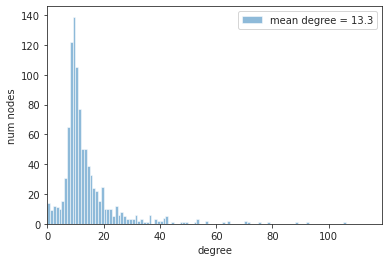

In [12]:
G_normal , G_quarantine = make_graphs(numNodes = 1000, m=9, scale = 100 , plot_degree = True)


In [13]:
base = {
    "G": {"numNodes" : 1000, "m" : 9, "scale":100 , "plot_degree": False}, #Network adjacency matrix (numpy array) or Networkx graph object.
    "beta":0.2,# Rate of transmission (exposure) (global)
    "sigma":1/5.2, # Rate of infection (upon exposure)
    "gamma" : 1/14, # Rate of recovery (upon infection)
    "mu_I": 0.0004, # Rate of infection-related death
    "mu_0": 0,# Rate of baseline death
    "nu":0, # Rate of baseline birth
     "xi":0, # Rate of re-susceptibility (upon recovery)
     "p":0.5, # Probability of interaction outside adjacent nodes
     "Q": None, # Quarantine adjacency matrix (numpy array) or Networkx graph object.
     "beta_D": 0, # Rate of transmission (exposure) for individuals with detected infections (global), changed from 0.155 to set so detected individuals can't transmit
     "sigma_D": 1/5.2,   # Rate of infection (upon exposure) for individuals with detected infections
     "gamma_D":1/14, # Rate of recovery (upon infection) for individuals with detected infections
      "mu_D":0.0004, # Rate of infection-related death for individuals with detected infections
      "theta_E":0, # probability that exposed person is tested (i.e., becomes symptomatic)
      "theta_I":0, # probability that infected person is tested (i.e., becomes symptomatic)
      "phi_E":0, # each detected contact adds phi_E chance for probability of infection for exposed individual
      "phi_I": 0, # each detected contact adds phi_I chance for probability of infection for infected individual
      "psi_E": 1.0, #Probability of positive test results for exposed individuals. 1 =  no false negatives
      "psi_I": 1.0, # Probability of positive test results for exposed individuals. 1 = no false negatives
       "q":0.0, # Probability of quarantined individuals interaction outside adjacent nodes.   changed to 0 to make it strong quarantine
       "initI": 0, # Init number of infectious individuals
       "initE":0, # Init number of exposed  individuals
       "initD_E":0, # Init number of detected exposed individuals
       "initD_I":0, # Init number of detected infectious individuals
       "initR":0, # Init number of recovered individuals
      "initF":0, # Init number of infection -related fatalities
      "p_extern": 1/1000, # Rate of spontanous (external) infection
      "p_periodic": 0, # Fraction of people tested in a periodic subsample tests
      "period": 1, # Period for periodic testing
      "batch" : True, # Test people in batch (True) or test each person with probability p_periodic (False)
      "min_time" : 0, # Minimum time to pass between two tests for the same individual
      "store_Xseries" : False, # Store the full data per node
      "count_non_random" : False, #  True: count tests done to symptomatic or traced people
      "T": 84, # time to run the execution
      "verbose": False, # print log messages during run
       "checkpoints": None, # checkpoints (see SIERPlus documentation - we don't use this)
       "stopping": "1st", # function for stopping policy '1st' means stop at first detection
       "policy": None, # policy function for adaptive policies
       "policyInterval": 1, # period to apply policy function
        "type": "[UNKNOWN]", # type of simulation - useful for aggragating data
        "runTillEnd": True, # True - don't stop even if zero infections (makes sense when external infections > 0),
        "test_recovered": True, # Test people in "recovered" state - makes sense when we stop at first detection, not so much otherwise
        "initT": 0 # Initial time step
}

orig_base = dict(base)

In [14]:
# Testing symptomatic and tracing (unused when we stop at first detection)

symp_ratio = 0.2 # fraction of people that develop symptoms significant enough to be tested and isolated sometime during the time they spend in infected or exposed state
# this number is necessarily guessed, since it depends heavily on the demographics of the workplace
# as well as policies in place for self isolation and testing.
#symp_affin  =symp_ratio* base["sigma"] * base["gamma"] / ( base["gamma"] + base["sigma"] )

symp_affin = 0.2 * base["gamma"]

# Chosen so that symp_affin/sigma + symp_affin/sigma = symp_ratio

# probability of developing infection

symptomatic = {
    "theta_E" : 0 , # probability that exposed person is tested (i.e., becomes symptomatic)
    "theta_I" : symp_affin  # probability that infected person is tested (i.e., becomes symptomatic)
}


# a/sigma = 0.2*(1/sigma / (1/gamma + 1/delta)) = gamma*sigma/

# Contact tracing - a detected E/I neighbor increases the chance to be tested by 50%
tracing =  {
    "phi_E": 0.8,
    "phi_I": 0.8
}

# Uncomment lines below to include tracing & testing of symptomatic people 

#base.update(tracing)
#base.update(symptomatic)

We set a false negative rate of 67% for exposed individuals and 20% for infected individuals.

In [15]:
# False negatives 

base.update({
    "psi_E": 0.33, #Probability of positive test results for exposed individuals. 1 =  no false negatives
    "psi_I": 0.8, # Probability of positive test results for exposed individuals. 1 = no false negatives
})

#  Experiments



In [16]:
def test(days,batches):
    """Modify parameters to test 1/batches of the population every days/batches days"""
    return { "p_periodic" : 1/batches, "period": days/batches }

def product(A,B):
    return [(a,b) for a in A for b in B]

In [18]:

to_do =product([28],[1,2,3,28]) + \
       product([14],[1,2,3,14])


    

base["T"] = 108

In [19]:
settings = [{**base, **test(d,k), "type":f"{d}/{k}" } for (d,k) in to_do ]



settings += [{**base , "type": "No testing (56 days)", "T": 56 } ]

settings  += [{**base , "type": "No testing (108 days)", "T": 108 } ]

#settings  += [{**base , "type": "No testing (84 days)", "T": 84 } ]

#settings += [{**base, "G":G_quarantine , "p":0, "beta":0, "type": "Business closed (28 days)", "T":28}]

settings += [{**base, "G":G_quarantine , "p":0, "beta":0, "type": "Business closed (56 days)", "T":56}]

settings += [{**base, "G":G_quarantine , "p":0, "beta":0, "type": "Business closed (56 days)", "T":108}]

#settings += [{**base, "G":G_quarantine , "p":0, "beta":0, "type": "Business closed (84 days)", "T":84}]

#settings  += [{**base, "type": "Test everyone", "period":1, "min_time":0, "p_periodic":1 }]


In [20]:
base

{'G': {'numNodes': 1000, 'm': 9, 'scale': 100, 'plot_degree': False},
 'beta': 0.2,
 'sigma': 0.1923076923076923,
 'gamma': 0.07142857142857142,
 'mu_I': 0.0004,
 'mu_0': 0,
 'nu': 0,
 'xi': 0,
 'p': 0.5,
 'Q': None,
 'beta_D': 0,
 'sigma_D': 0.1923076923076923,
 'gamma_D': 0.07142857142857142,
 'mu_D': 0.0004,
 'theta_E': 0,
 'theta_I': 0,
 'phi_E': 0,
 'phi_I': 0,
 'psi_E': 0.33,
 'psi_I': 0.8,
 'q': 0.0,
 'initI': 0,
 'initE': 0,
 'initD_E': 0,
 'initD_I': 0,
 'initR': 0,
 'initF': 0,
 'p_extern': 0.001,
 'p_periodic': 0,
 'period': 1,
 'batch': True,
 'min_time': 0,
 'store_Xseries': False,
 'count_non_random': False,
 'T': 108,
 'verbose': False,
 'checkpoints': None,
 'stopping': '1st',
 'policy': None,
 'policyInterval': 1,
 'type': '[UNKNOWN]',
 'runTillEnd': True,
 'test_recovered': True,
 'initT': 0}

## Get variants for p_extern, beta

In [21]:
from fractions import Fraction

std_graph =   {"numNodes" : 1000, "m" : 9, "scale":100 , "plot_degree": False}

options = [(beta,p,std_graph) for beta in [0.025,0.05,0.1] for p in [0.0001,0.00005,"r28"]]


In [22]:
def name(G):
    if G["m"] <=9:
        return "" 
    else: 
        return " (more edges)"

to_run = [] 
variants = {}
for beta,p,G in options:
    print(beta,p,G)
    q = Fraction(p).limit_denominator(100000) if (p and (not isinstance(p,str))) else 0
    for d in settings:
        e = dict(d)
        
        v = f"beta={beta},pextern={q}"+name(G)
        if p==0:
            e["initI"] = 1
            v += " (1 initial infection)"
        if isinstance(p,str) and p[0]=='r':
            a = float(p[1:])
            e["initT"]=(0,a)
            e["initI"]=1
            e["p_extern"] = 0
            v += f" (random start 0-{a})"
        else:
            e["p_extern"] = p
        if e["type"][:15] != "Business closed":
            e["G"] = G
            e["beta"] = beta
            
        #e["verbose"] = True
        variants[v] = { "beta":beta, "p_extern": p, "G":G }
        e["variant"] =  v
        to_run += [e]
        
print(len(variants.keys()))
variants

0.025 0.0001 {'numNodes': 1000, 'm': 9, 'scale': 100, 'plot_degree': False}
0.025 5e-05 {'numNodes': 1000, 'm': 9, 'scale': 100, 'plot_degree': False}
0.025 r28 {'numNodes': 1000, 'm': 9, 'scale': 100, 'plot_degree': False}
0.05 0.0001 {'numNodes': 1000, 'm': 9, 'scale': 100, 'plot_degree': False}
0.05 5e-05 {'numNodes': 1000, 'm': 9, 'scale': 100, 'plot_degree': False}
0.05 r28 {'numNodes': 1000, 'm': 9, 'scale': 100, 'plot_degree': False}
0.1 0.0001 {'numNodes': 1000, 'm': 9, 'scale': 100, 'plot_degree': False}
0.1 5e-05 {'numNodes': 1000, 'm': 9, 'scale': 100, 'plot_degree': False}
0.1 r28 {'numNodes': 1000, 'm': 9, 'scale': 100, 'plot_degree': False}
9


{'beta=0.025,pextern=1/10000': {'beta': 0.025,
  'p_extern': 0.0001,
  'G': {'numNodes': 1000, 'm': 9, 'scale': 100, 'plot_degree': False}},
 'beta=0.025,pextern=1/20000': {'beta': 0.025,
  'p_extern': 5e-05,
  'G': {'numNodes': 1000, 'm': 9, 'scale': 100, 'plot_degree': False}},
 'beta=0.025,pextern=0 (random start 0-28.0)': {'beta': 0.025,
  'p_extern': 'r28',
  'G': {'numNodes': 1000, 'm': 9, 'scale': 100, 'plot_degree': False}},
 'beta=0.05,pextern=1/10000': {'beta': 0.05,
  'p_extern': 0.0001,
  'G': {'numNodes': 1000, 'm': 9, 'scale': 100, 'plot_degree': False}},
 'beta=0.05,pextern=1/20000': {'beta': 0.05,
  'p_extern': 5e-05,
  'G': {'numNodes': 1000, 'm': 9, 'scale': 100, 'plot_degree': False}},
 'beta=0.05,pextern=0 (random start 0-28.0)': {'beta': 0.05,
  'p_extern': 'r28',
  'G': {'numNodes': 1000, 'm': 9, 'scale': 100, 'plot_degree': False}},
 'beta=0.1,pextern=1/10000': {'beta': 0.1,
  'p_extern': 0.0001,
  'G': {'numNodes': 1000, 'm': 9, 'scale': 100, 'plot_degree': Fals

## This is the time consuming part


In [23]:
# commented out - this is just when debugging
#to_run = [{**base, "p_periodic":1/20, "period":1, "T":200, "p_extern":1/30000 , "type":"Trial", "verbose":False, "min_time":0}]

In [24]:
realizations = 400
#lview = None 
len(to_run)*realizations

43200

In [25]:
#datadir = "data/20200605_14_47_38_300"

In [26]:
if not os.path.exists("data/"):
    os.makedirs("data")

timestamp = datetime.now().strftime('%Y%m%d_%H_%M_%S')
datadir = f"data/{timestamp}_{realizations}"
os.makedirs(datadir)
print(datadir)

data/20200617_18_25_52_400


In [27]:
def pline(L,n=None):
    T = []
    for a in L:
        if isinstance(a,float):
            if a > 0.001:
                T += [f"{a:.3f}"]
            else:
                q = Fraction(p).limit_denominator(100000) 
                T += [f"{q}"]
        else:
            T += [str(a) ]
    if not n:
        n = max([len(a)+2 for a in T])
    
    return "|".join([a.ljust(n) for a in T])+"\n"
                
        
    
readme = fr"""
# Description

The above is results of simulations done at {timestamp}

We use {len(settings)} parameter settings, each with {len(list(variants.keys()))} variants. We describe the main settings below:

We use {realizations} realizations, for a total of {realizations * len(to_run)} executions.

## Variants:

"""
for v in variants.keys():
    readme += f"   *  {v}\n"

readme += "## Settings \n"

keys = ["type", "p_periodic", "period"]
readme += pline(keys,25)
readme += "|".join(["-"*25]*len(keys))+"\n"
for s in settings:
    readme += pline([s["type"], s["p_periodic"],s["period"] ],25)


with open(f"{datadir}/readme.md", 'a') as out:
    out.write(readme + '\n')

from IPython.display import display, Markdown

display(Markdown(readme))


# Description

The above is results of simulations done at 20200617_18_25_52

We use 12 parameter settings, each with 9 variants. We describe the main settings below:

We use 400 realizations, for a total of 43200 executions.

## Variants:

   *  beta=0.025,pextern=1/10000
   *  beta=0.025,pextern=1/20000
   *  beta=0.025,pextern=0 (random start 0-28.0)
   *  beta=0.05,pextern=1/10000
   *  beta=0.05,pextern=1/20000
   *  beta=0.05,pextern=0 (random start 0-28.0)
   *  beta=0.1,pextern=1/10000
   *  beta=0.1,pextern=1/20000
   *  beta=0.1,pextern=0 (random start 0-28.0)
## Settings 
type                     |p_periodic               |period                   
-------------------------|-------------------------|-------------------------
28/1                     |1.000                    |28.000                   
28/2                     |0.500                    |14.000                   
28/3                     |0.333                    |9.333                    
28/28                    |0.036                    |1.000                    
14/1                     |1.000                    |14.000                   
14/2                     |0.500                    |7.000                    
14/3                     |0.333                    |4.667                    
14/14                    |0.071                    |1.000                    
No testing (56 days)     |0                        |1                        
No testing (108 days)    |0                        |1                        
Business closed (56 days)|0                        |1                        
Business closed (56 days)|0                        |1                        


In [28]:
import pickle
with open(f'{datadir}/to_run.pickle', 'wb') as handle:
    pickle.dump(to_run, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [29]:
import os
os.chdir(datadir)

In [30]:
!pwd

/home/jupyter/covidtesting/data/20200617_18_25_52_400


In [31]:
%%time
!python ../../par_run.py $realizations

Loading to_run
Loaded
Preparing list to run
We have 96 CPUs
Starting execution of 43200 runs
000: beta=0.1,pextern=1/20000
000: beta=0.1,pextern=1/20000 -- DONE
942: beta=0.1,pextern=1/20000
942: beta=0.1,pextern=1/20000 -- DONE
351: beta=0.025,pextern=0 (random start 0-28.0)
351: beta=0.025,pextern=0 (random start 0-28.0) -- DONE
853: beta=0.1,pextern=1/20000
853: beta=0.1,pextern=1/20000 -- DONE
494: beta=0.025,pextern=1/10000
494: beta=0.025,pextern=1/10000 -- DONE
332: beta=0.1,pextern=0 (random start 0-28.0)
332: beta=0.1,pextern=0 (random start 0-28.0) -- DONE
664: beta=0.05,pextern=1/10000
664: beta=0.05,pextern=1/10000 -- DONE
680: beta=0.1,pextern=1/20000
680: beta=0.1,pextern=1/20000 -- DONE
744: beta=0.025,pextern=1/20000
744: beta=0.025,pextern=1/20000 -- DONE
727: beta=0.05,pextern=0 (random start 0-28.0)
727: beta=0.05,pextern=0 (random start 0-28.0) -- DONE
637: beta=0.05,pextern=1/20000
637: beta=0.05,pextern=1/20000 -- DONE
566: beta=0.1,pextern=1/10000
566: beta=0.1,p

In [32]:
os.chdir("/home/jupyter/covidtesting/")

In [33]:
7

7

**End of time consuming part**


In [36]:
data = pd.read_pickle(f'{datadir}/data.zip')

In [37]:
data["variant"].unique()




array(['beta=0.025,pextern=1/10000', 'beta=0.025,pextern=1/20000',
       'beta=0.025,pextern=0 (random start 0-28.0)',
       'beta=0.05,pextern=1/10000', 'beta=0.05,pextern=1/20000',
       'beta=0.05,pextern=0 (random start 0-28.0)',
       'beta=0.1,pextern=1/10000', 'beta=0.1,pextern=1/20000',
       'beta=0.1,pextern=0 (random start 0-28.0)'], dtype=object)

Create summary for all variants

In [38]:
summaries = {}
for v in data["variant"].unique():    
    d = data[data["variant"]==v]
    summaries[v] = summary(d, excel = False, csv = True, prefix = v, datadir = datadir)

Saved summary as data/20200617_18_25_52_400/data/20200617_18_25_52_400/summary_beta=0.025,pextern=1_10000.csv
Saved summary as data/20200617_18_25_52_400/data/20200617_18_25_52_400/summary_beta=0.025,pextern=1_20000.csv
Saved summary as data/20200617_18_25_52_400/data/20200617_18_25_52_400/summary_beta=0.025,pextern=0 (random start 0-28.0).csv
Saved summary as data/20200617_18_25_52_400/data/20200617_18_25_52_400/summary_beta=0.05,pextern=1_10000.csv
Saved summary as data/20200617_18_25_52_400/data/20200617_18_25_52_400/summary_beta=0.05,pextern=1_20000.csv
Saved summary as data/20200617_18_25_52_400/data/20200617_18_25_52_400/summary_beta=0.05,pextern=0 (random start 0-28.0).csv
Saved summary as data/20200617_18_25_52_400/data/20200617_18_25_52_400/summary_beta=0.1,pextern=1_10000.csv
Saved summary as data/20200617_18_25_52_400/data/20200617_18_25_52_400/summary_beta=0.1,pextern=1_20000.csv
Saved summary as data/20200617_18_25_52_400/data/20200617_18_25_52_400/summary_beta=0.1,pextern

# Figures

In [ ]:
line_plots = [
#    { "col": "Excess risk over baseline (percentage)"},
  #  {"col": "Total undetected person days", "title" : "Average undetected infected", "scale": 1/(1000*base["T"]) },
    {"col": "Avg undetected/day till detection", "title":"Average undetected infectious per day until 1st detection",  "ylabel":  "infectious/day (out of 1000)", "scale": 1/(base["T"]), "base_lines": ["Business closed (28 days)", "No testing (28 days)" ] },
    {"col": "Time 1st detection", "title": "Time of first detection", "base_lines": [], "ylabel": "day of detection" } #,
#    {"col": "Number infected at time of 1st detection", "title":"Number infected at time of first detection", "base_lines": [] },
#    {"col": "Avg tests per day", "title":"Average number of tests per day", "base_lines": [] } #,
#    {"col": "Overall infected throughout", "title": "Overall number of infected people"}
]

for v in variants:
    for d in line_plots:
        plot_batches(**{**d, "title":f"{d['title']} ({v})"}, sumdata = summaries[v], prefix =v, filename = f"{datadir}/{d['title'].replace(' ','_')}_{v.replace(' ','_').replace('/','-')}.png")
        plt.show()

In [ ]:
scatter_plots = [
    {"col": "Total undetected person days until 1st", "title":"Average undetected infected until 1st detection", "scale": 1/(1000*base["T"]) }
#    {"col": "Total undetected person days", "title" : "Average undetected infected", "scale": 1/(1000*base["T"]) },
#    {"col": "Overall infected throughout", "title": "Overall number of infected people"}
]

types = ["14/1","14/14", "28/1","28/28","7/1","7/7"]

for v in variants:
    for d in scatter_plots:
        df = summaries[v].loc[types,:]
        scatter(**d, sumdata = df, prefix = v, filename = f"{datadir}/scatter_{d['title'].replace(' ','_')}_{v.replace(' ','_').replace('/','-')}.png")
        plt.show()

Plotting two figures for variant beta=0.025,pextern=1/10000 type 28/1


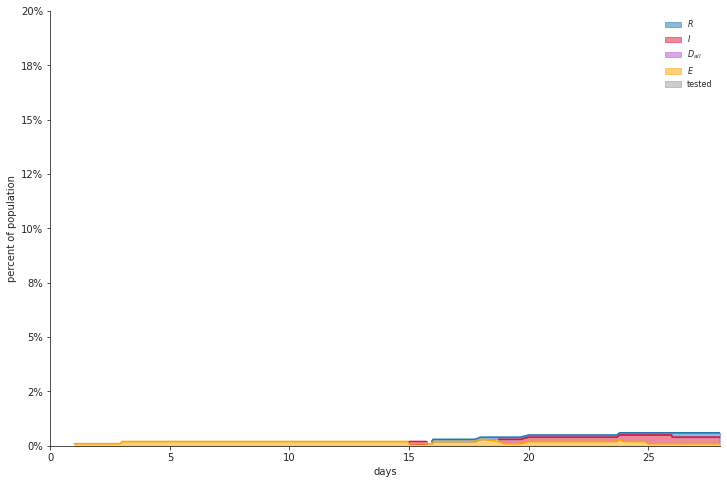

<Figure size 432x288 with 0 Axes>

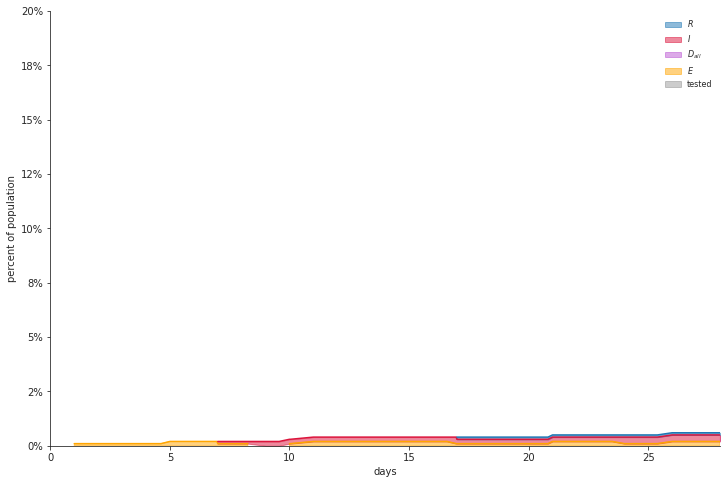

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/10000 type 28/2


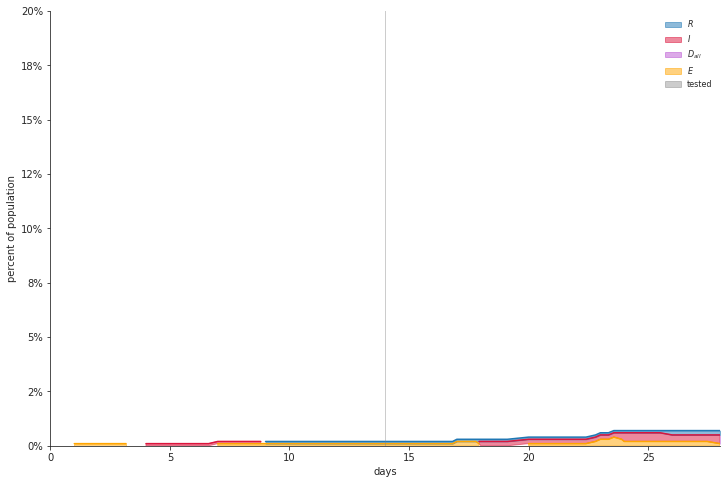

<Figure size 432x288 with 0 Axes>

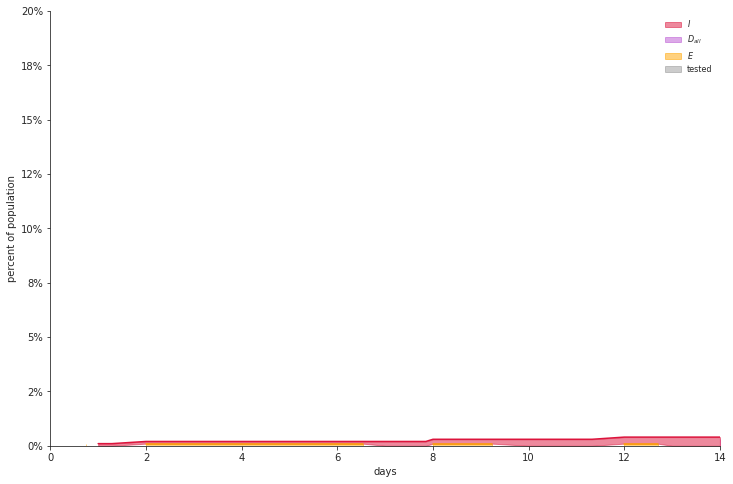

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/10000 type 28/3


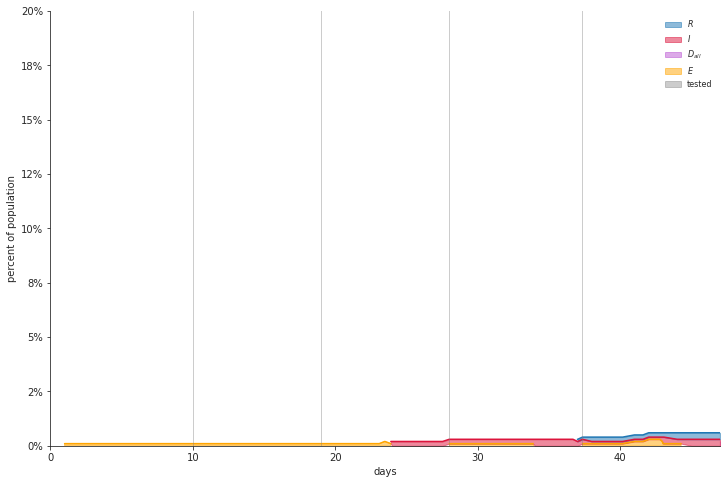

<Figure size 432x288 with 0 Axes>

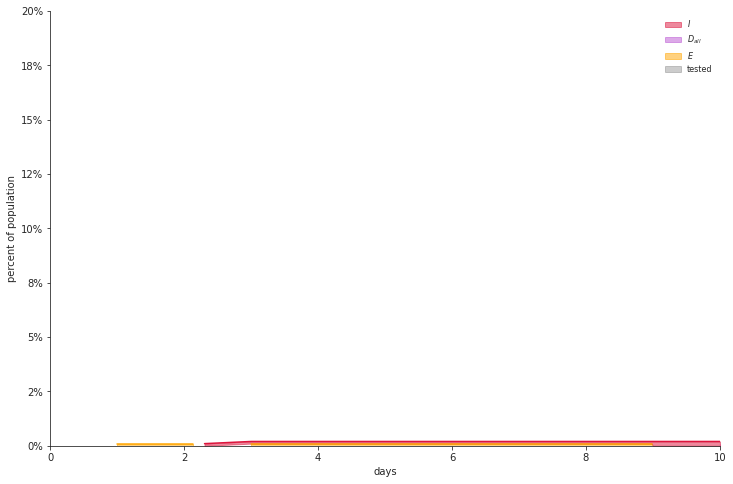

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/10000 type 28/28


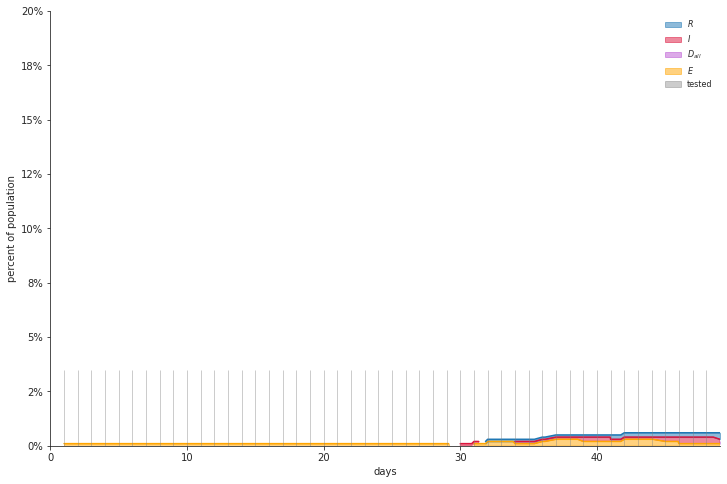

<Figure size 432x288 with 0 Axes>

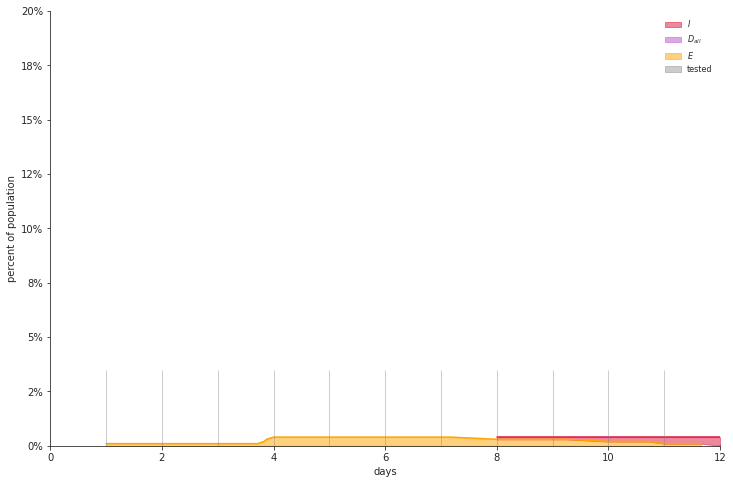

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/10000 type 14/1


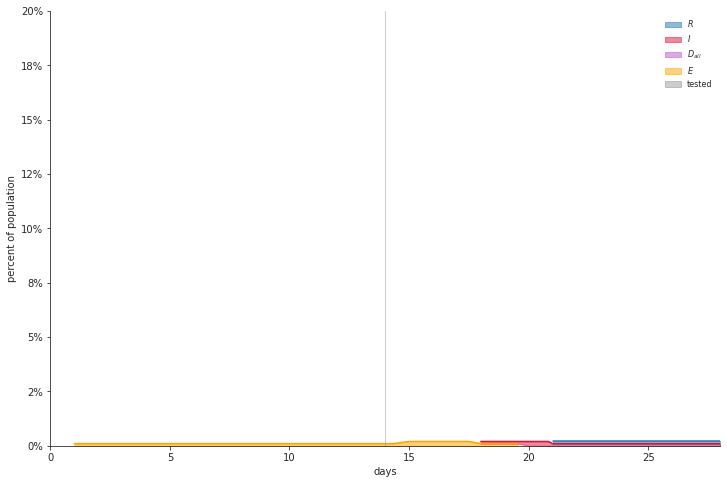

<Figure size 432x288 with 0 Axes>

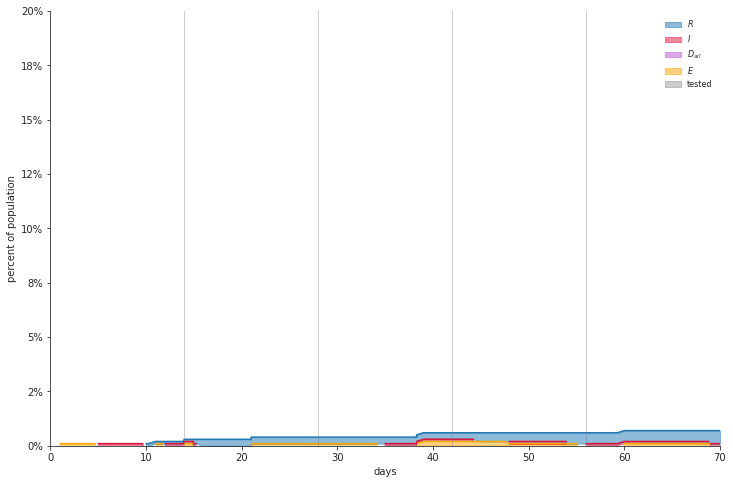

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/10000 type 14/2


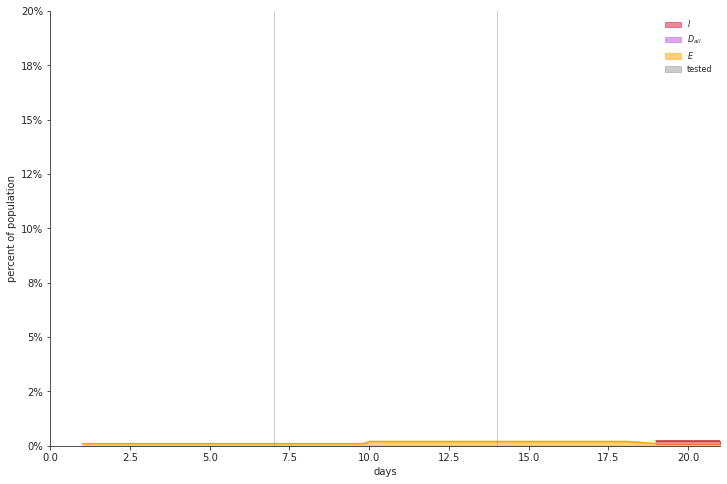

<Figure size 432x288 with 0 Axes>

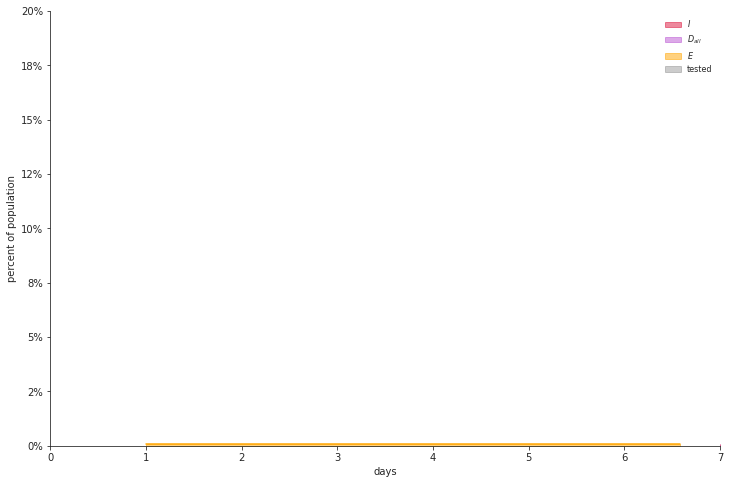

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/10000 type 14/3


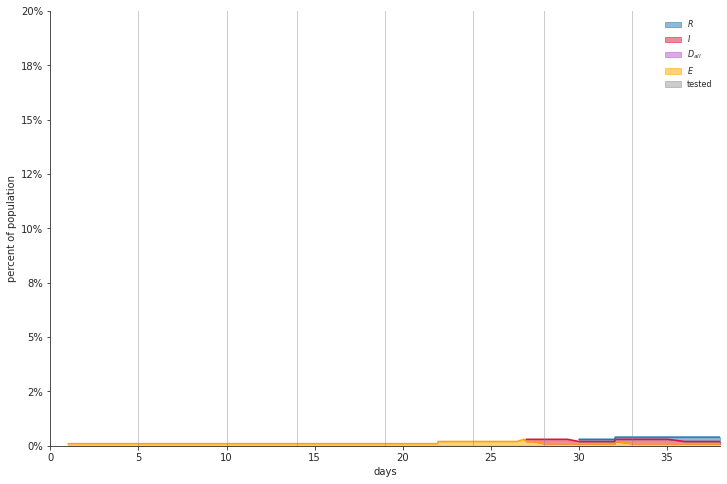

<Figure size 432x288 with 0 Axes>

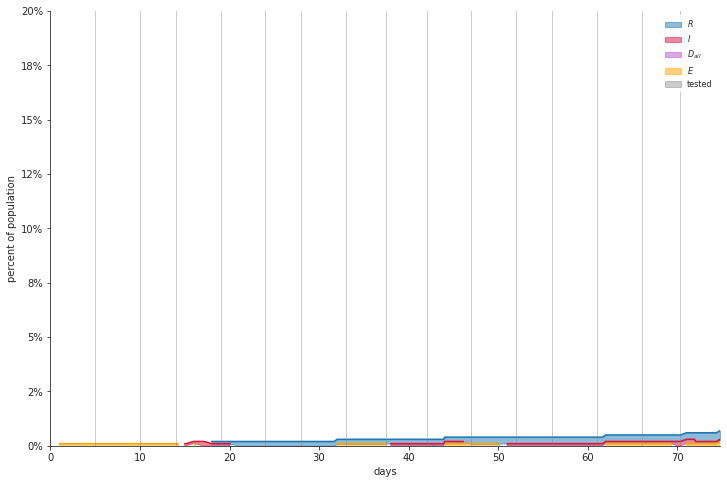

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/10000 type 14/14


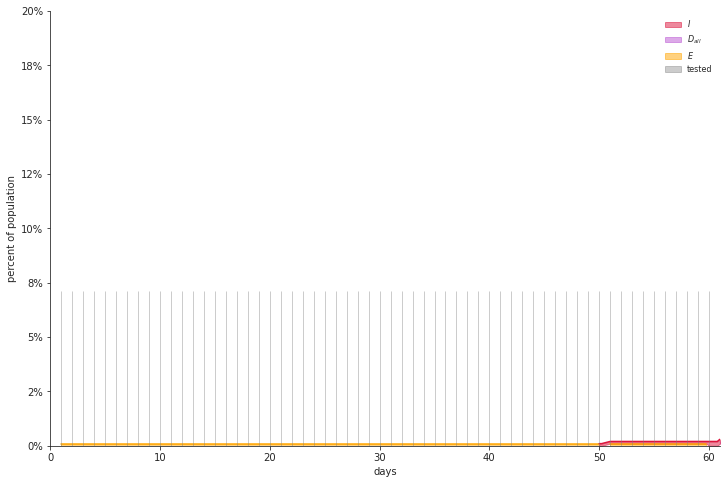

<Figure size 432x288 with 0 Axes>

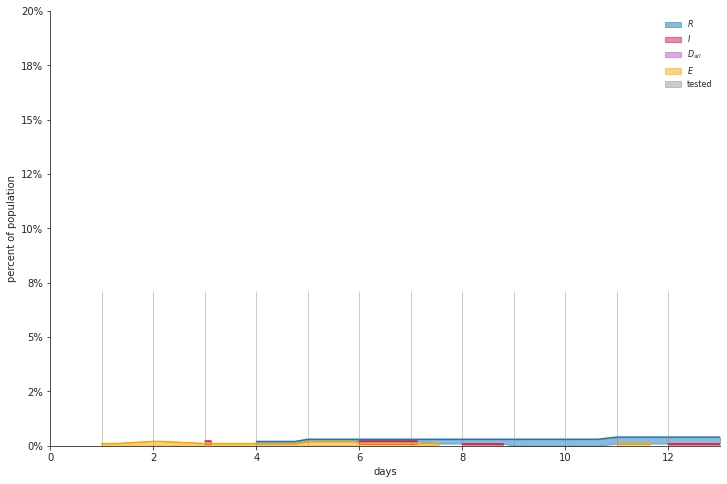

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/10000 type No testing (56 days)


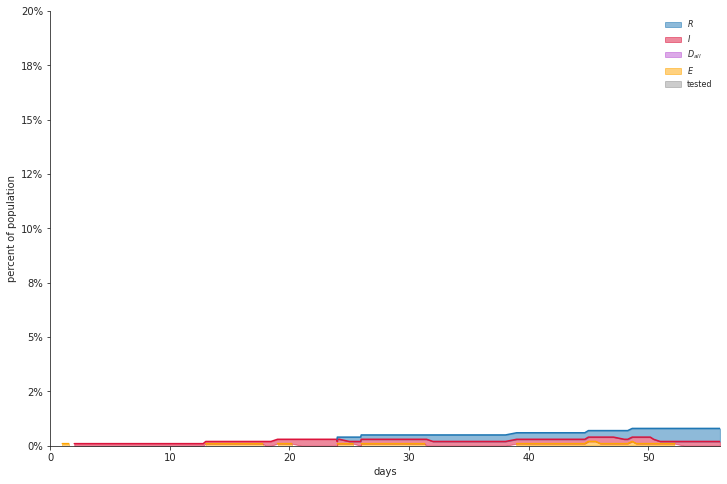

<Figure size 432x288 with 0 Axes>

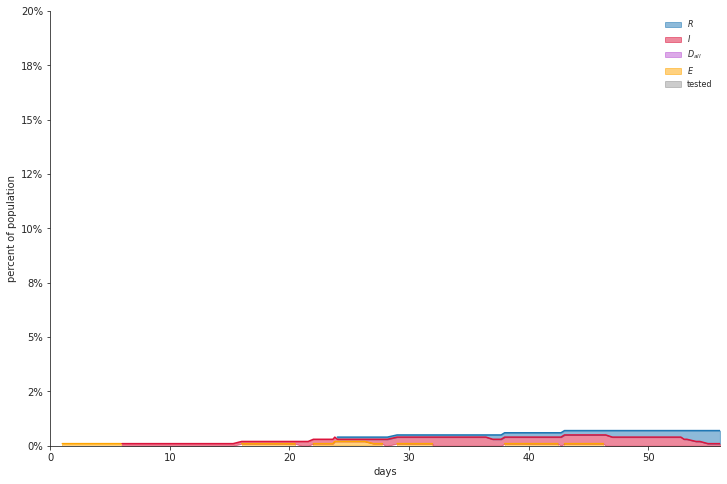

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/10000 type No testing (108 days)


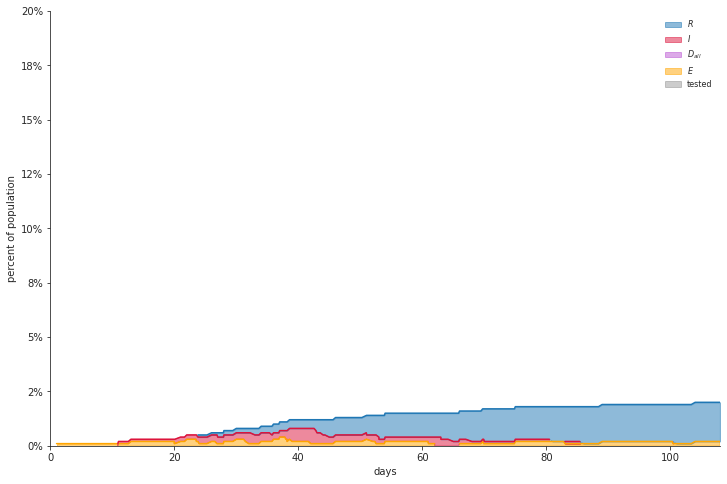

<Figure size 432x288 with 0 Axes>

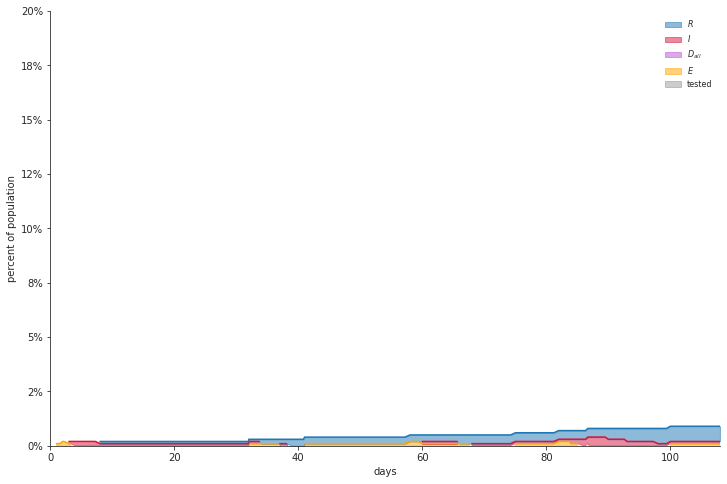

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/10000 type Business closed (56 days)


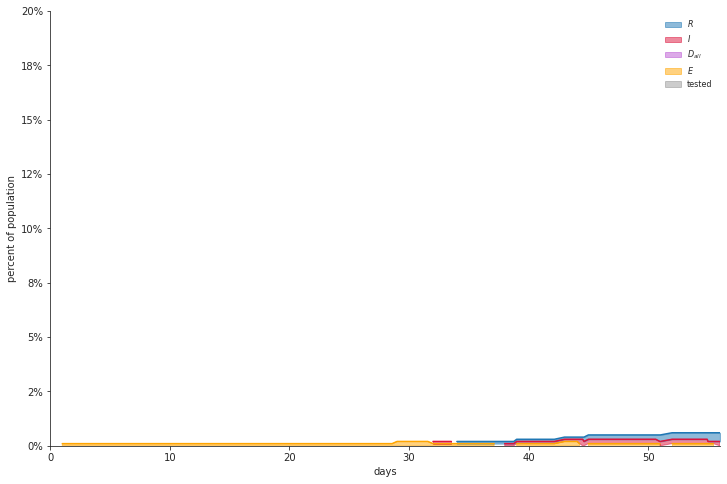

<Figure size 432x288 with 0 Axes>

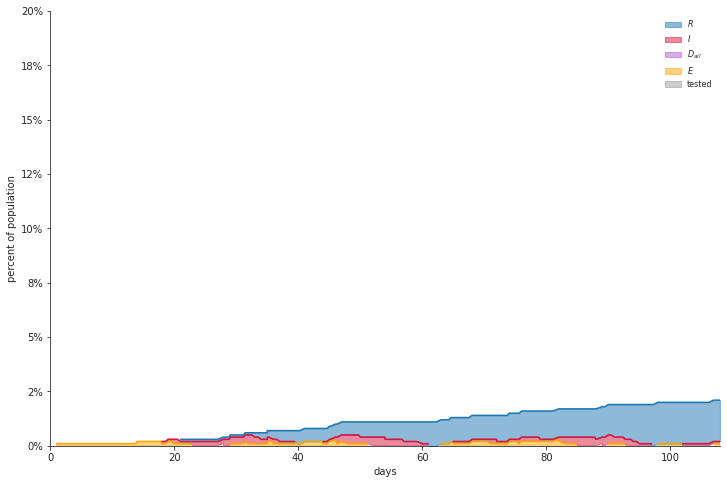

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/20000 type 28/1


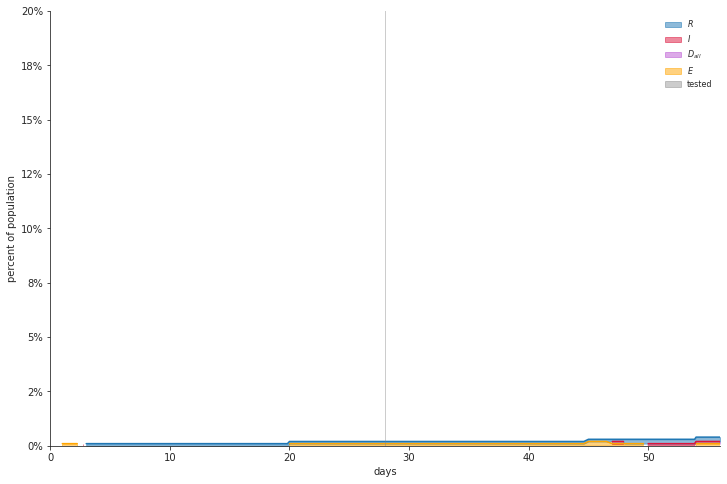

<Figure size 432x288 with 0 Axes>

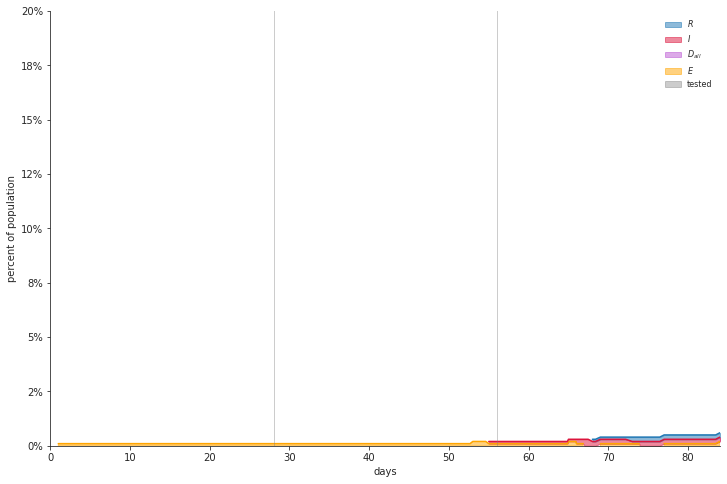

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/20000 type 28/2


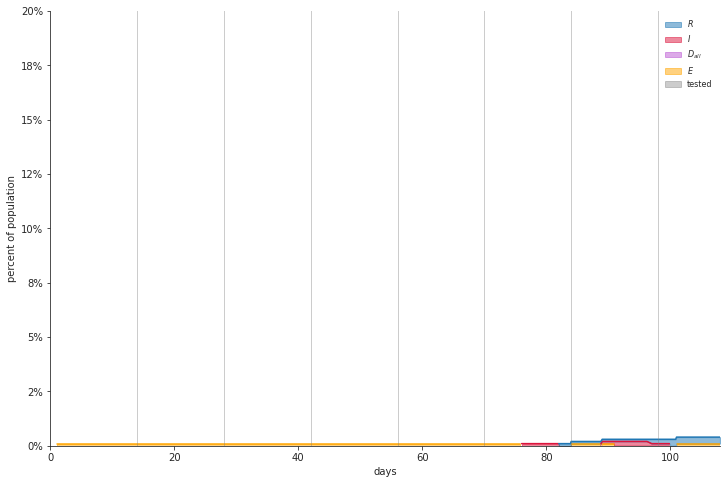

<Figure size 432x288 with 0 Axes>

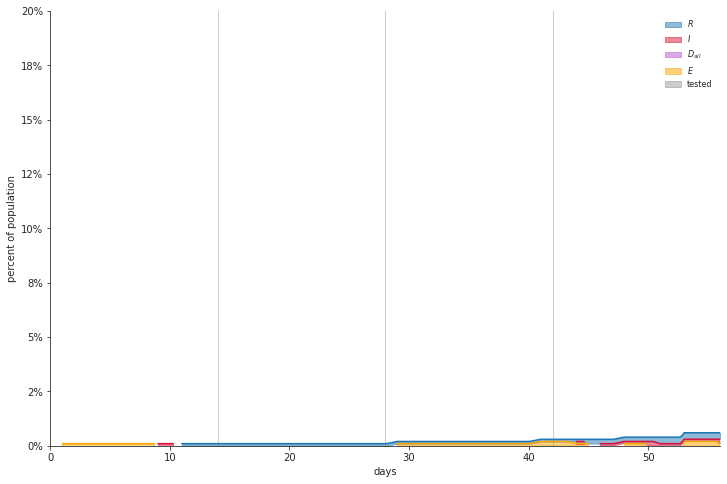

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/20000 type 28/3


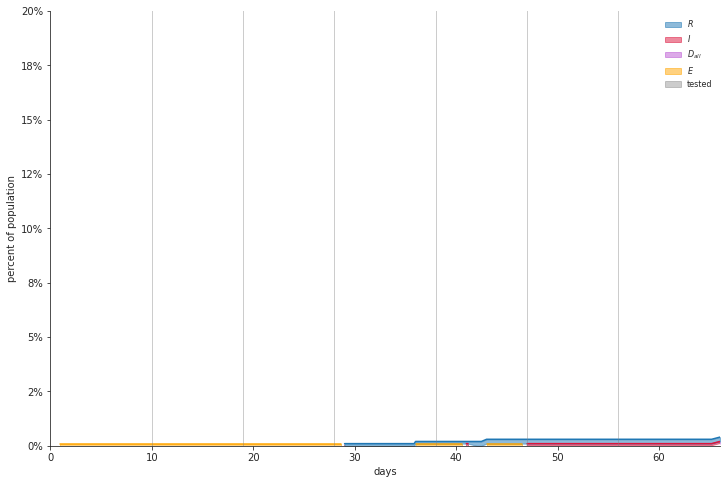

<Figure size 432x288 with 0 Axes>

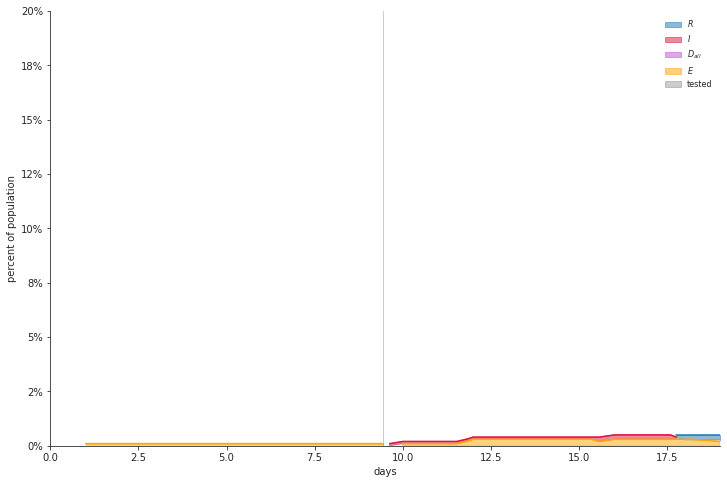

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/20000 type 28/28


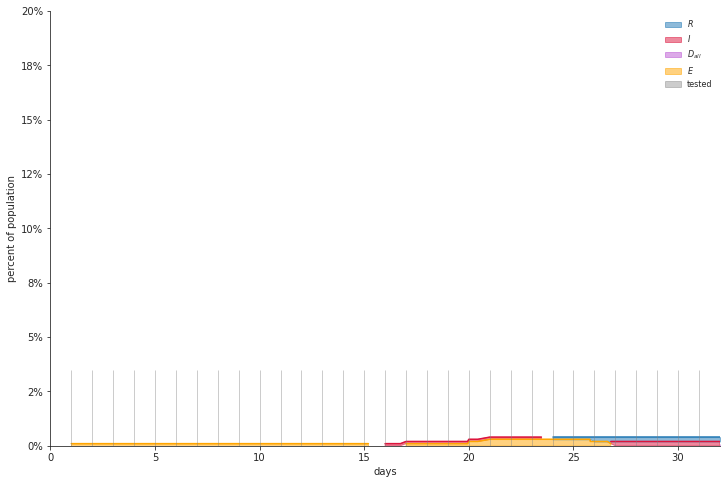

<Figure size 432x288 with 0 Axes>

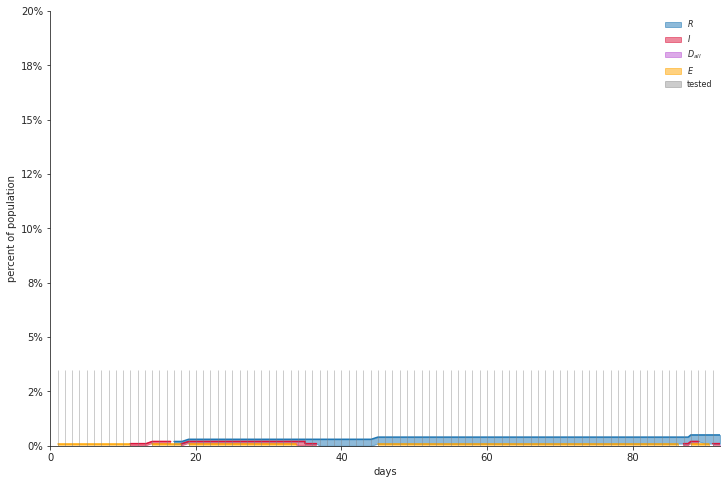

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/20000 type 14/1


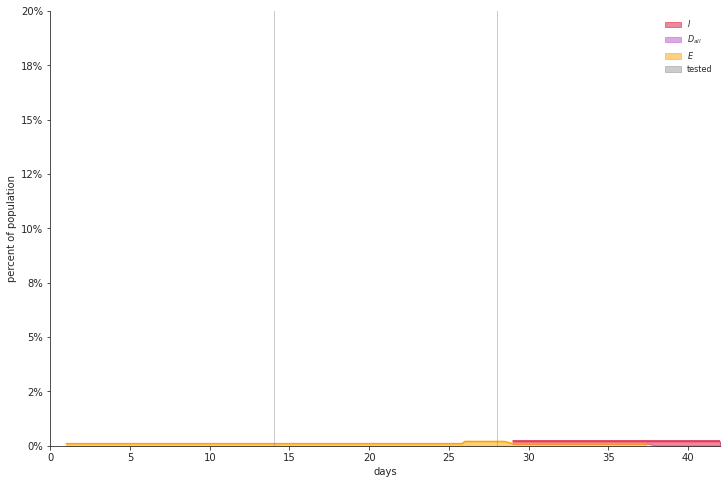

<Figure size 432x288 with 0 Axes>

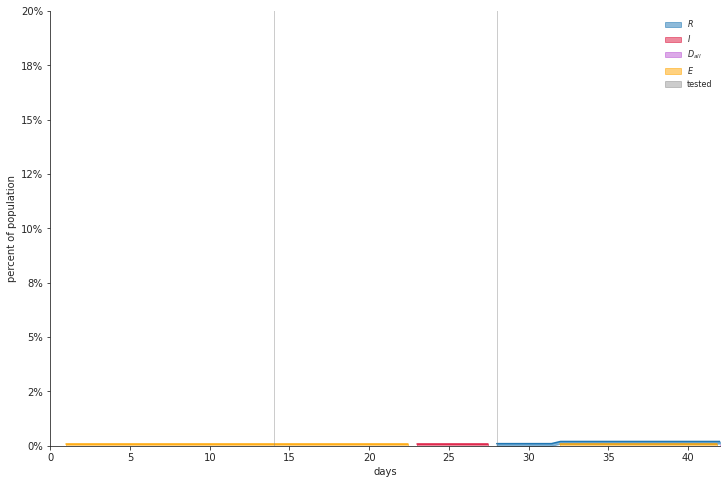

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/20000 type 14/2


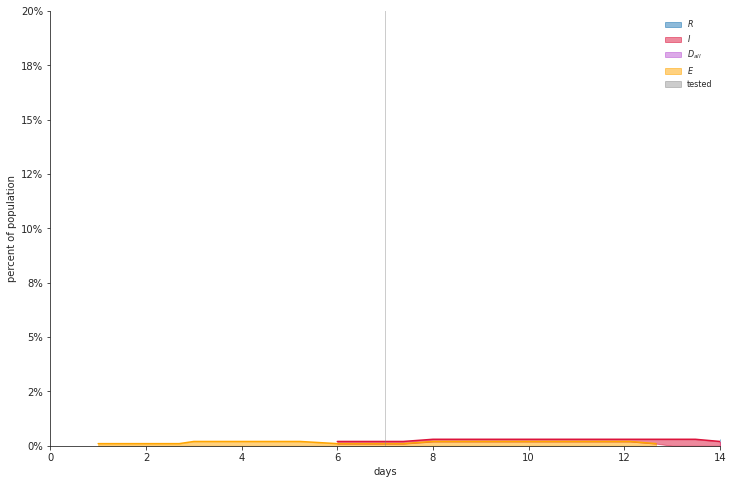

<Figure size 432x288 with 0 Axes>

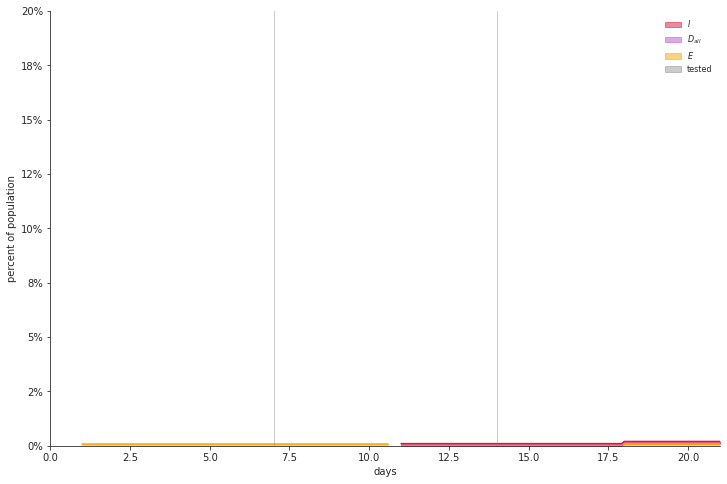

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/20000 type 14/3


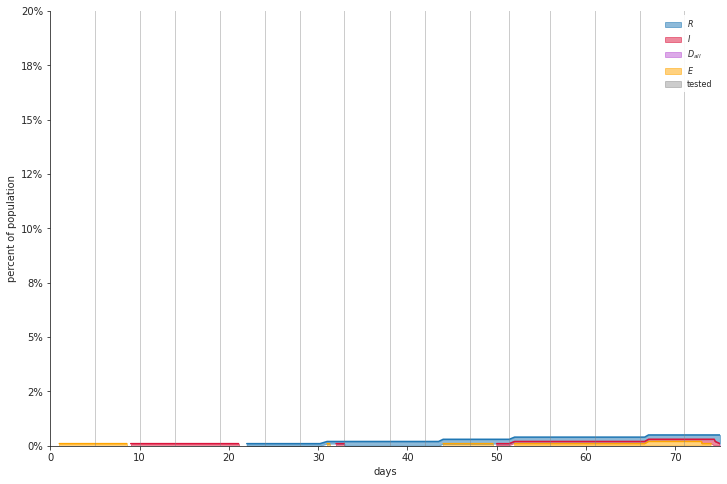

<Figure size 432x288 with 0 Axes>

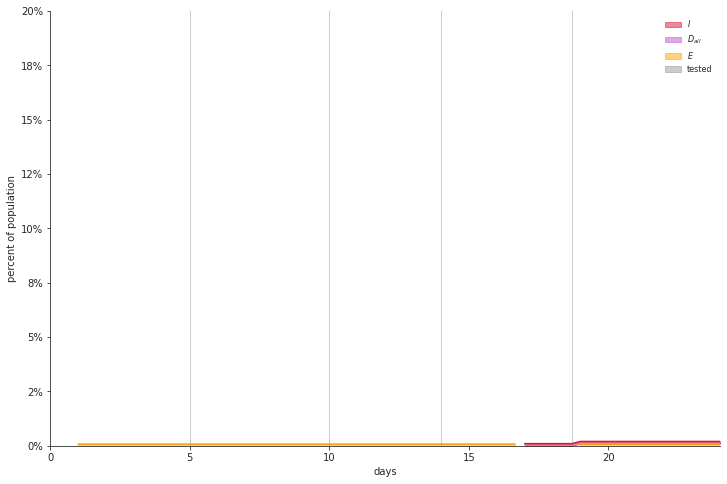

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/20000 type 14/14


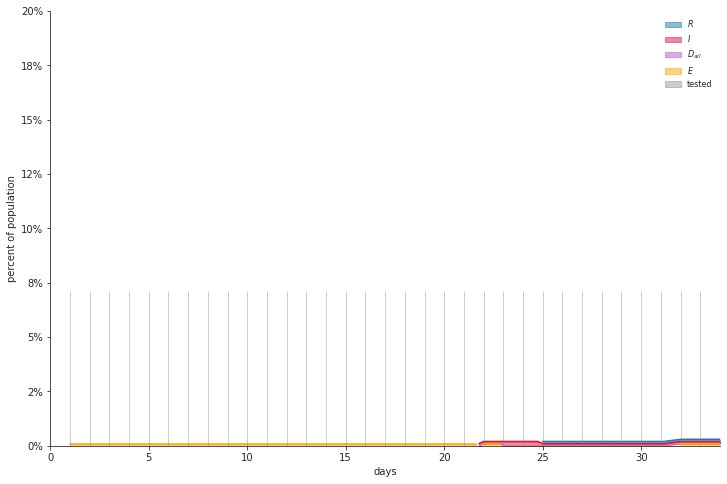

<Figure size 432x288 with 0 Axes>

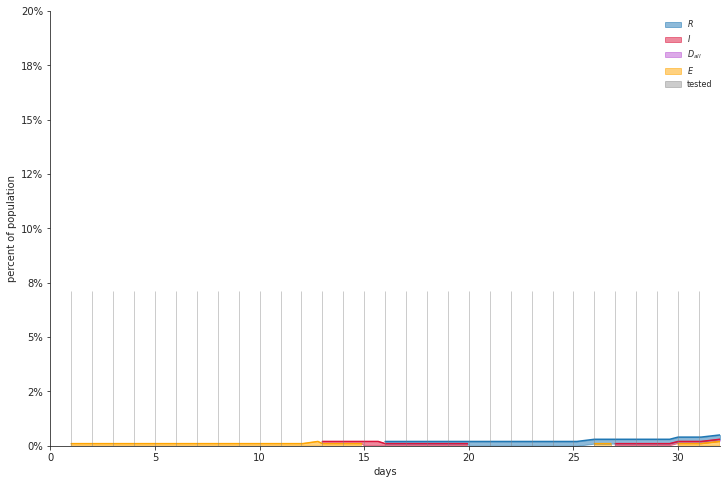

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/20000 type No testing (56 days)


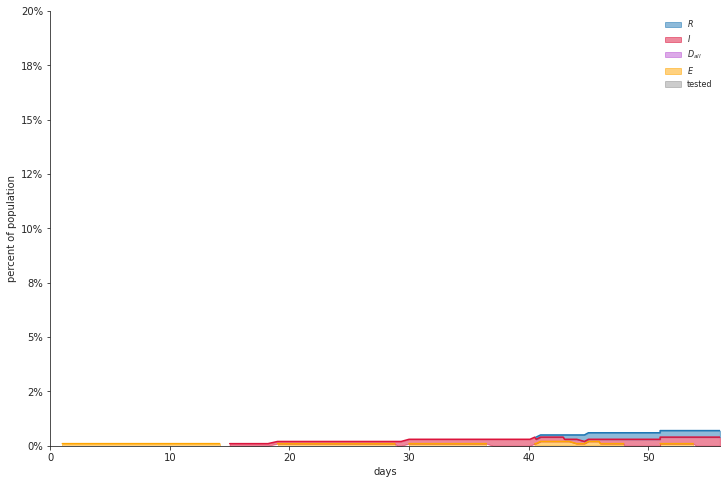

<Figure size 432x288 with 0 Axes>

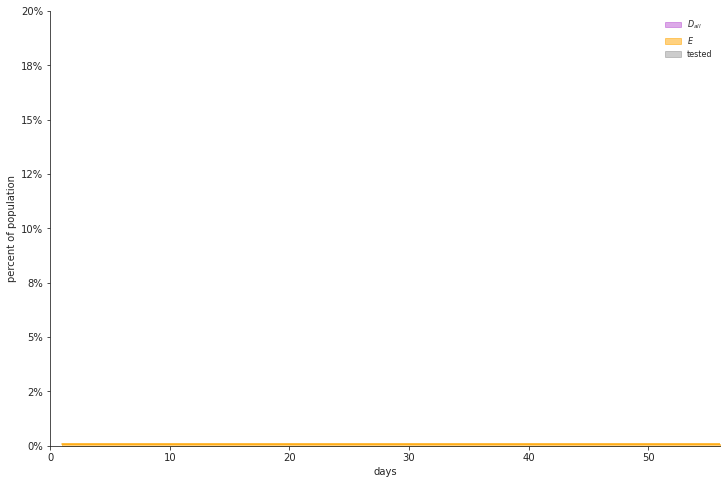

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/20000 type No testing (108 days)


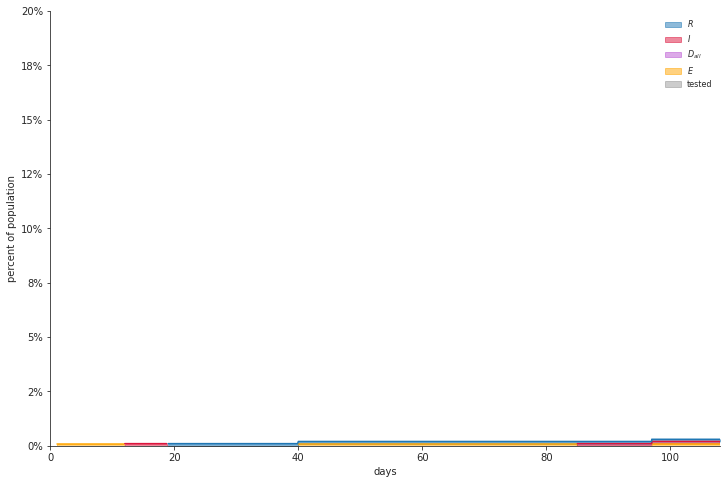

<Figure size 432x288 with 0 Axes>

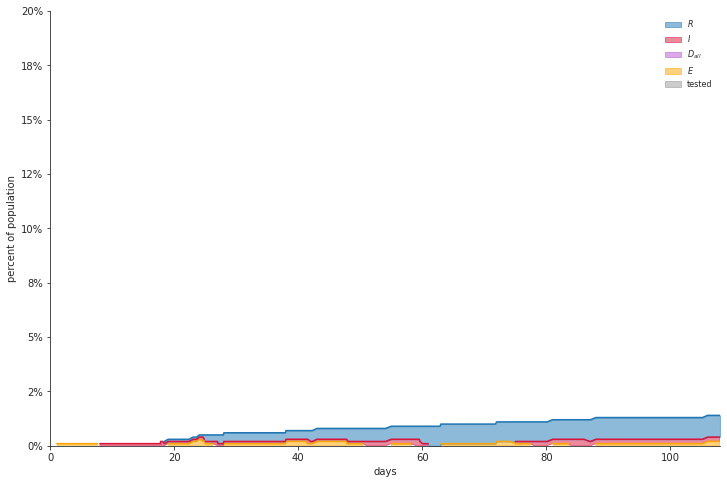

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=1/20000 type Business closed (56 days)


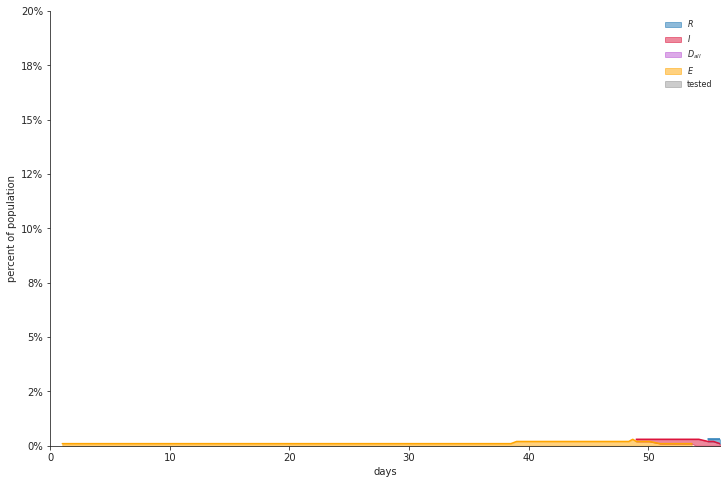

<Figure size 432x288 with 0 Axes>

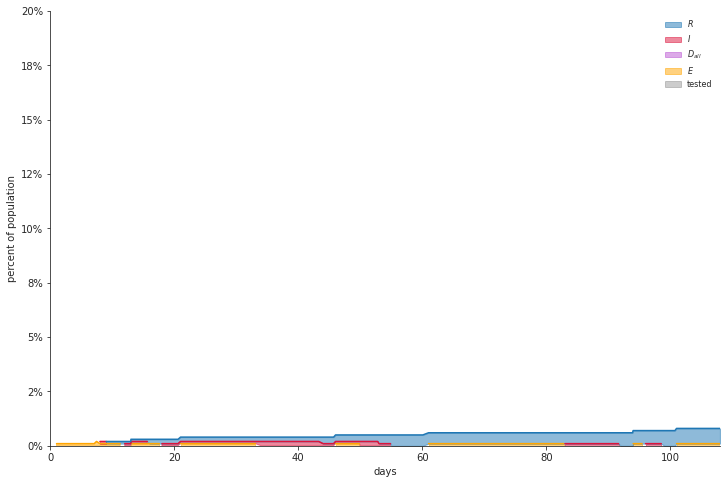

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=0 (random start 0-28.0) type 28/1


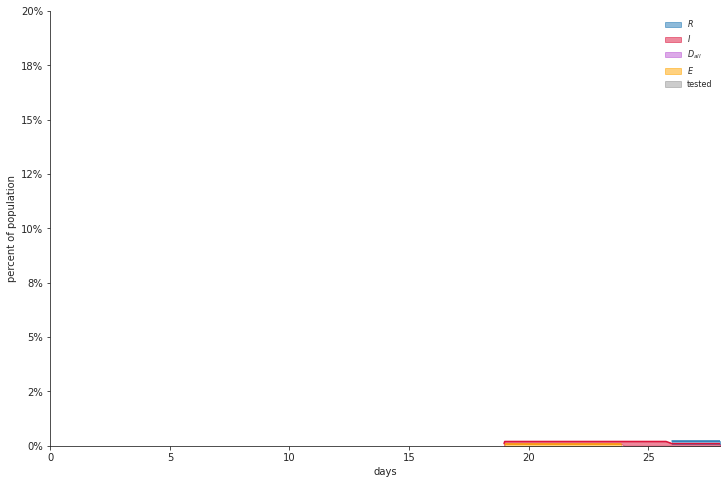

<Figure size 432x288 with 0 Axes>

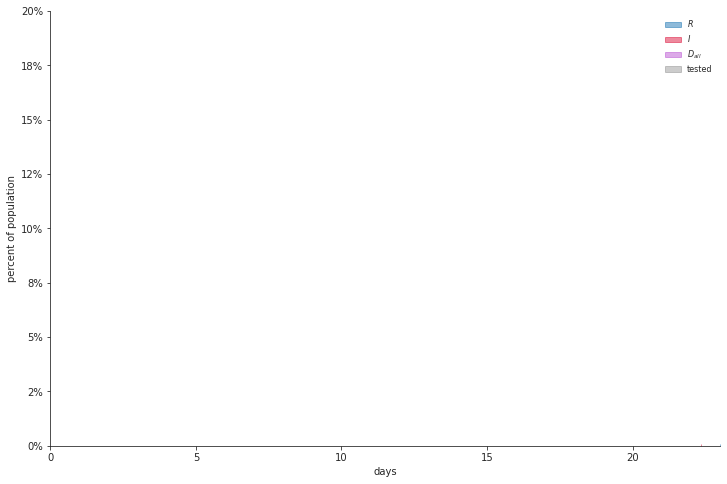

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=0 (random start 0-28.0) type 28/2


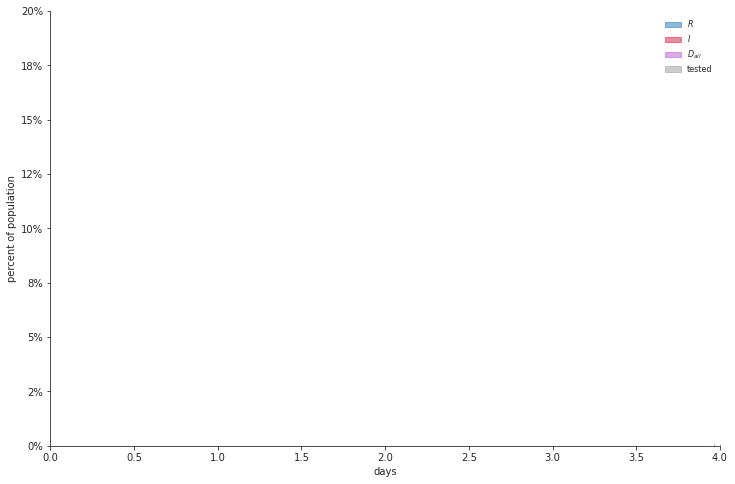

<Figure size 432x288 with 0 Axes>

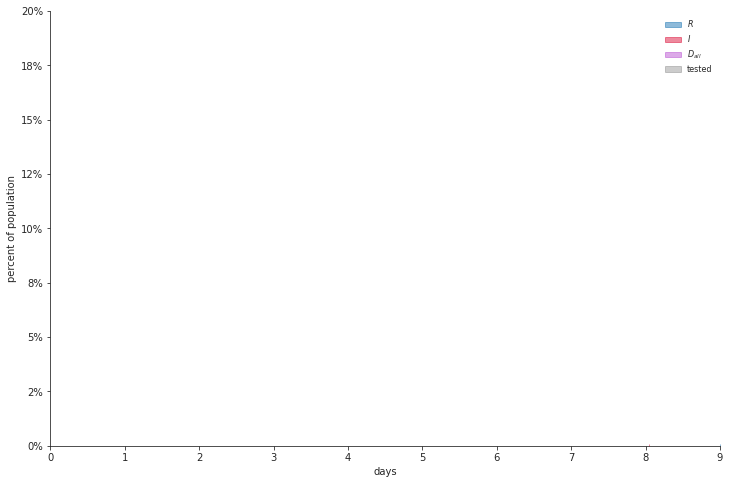

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=0 (random start 0-28.0) type 28/3


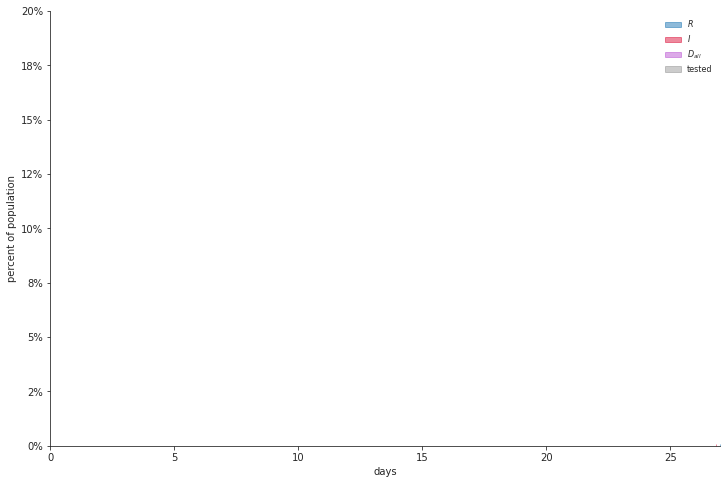

<Figure size 432x288 with 0 Axes>

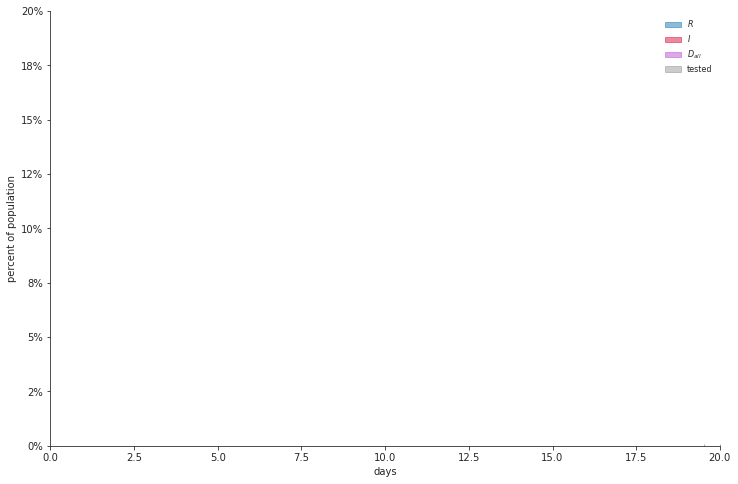

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=0 (random start 0-28.0) type 28/28


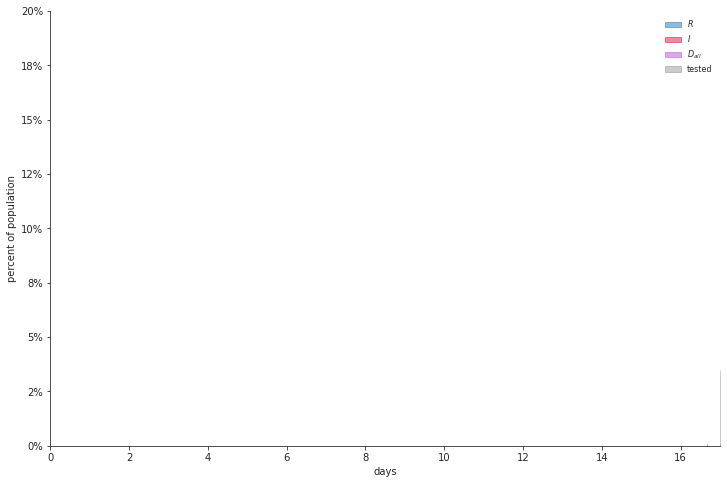

<Figure size 432x288 with 0 Axes>

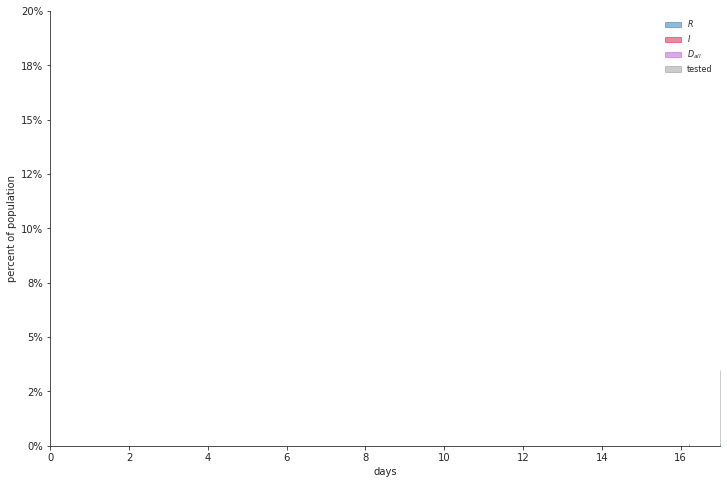

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=0 (random start 0-28.0) type 14/1


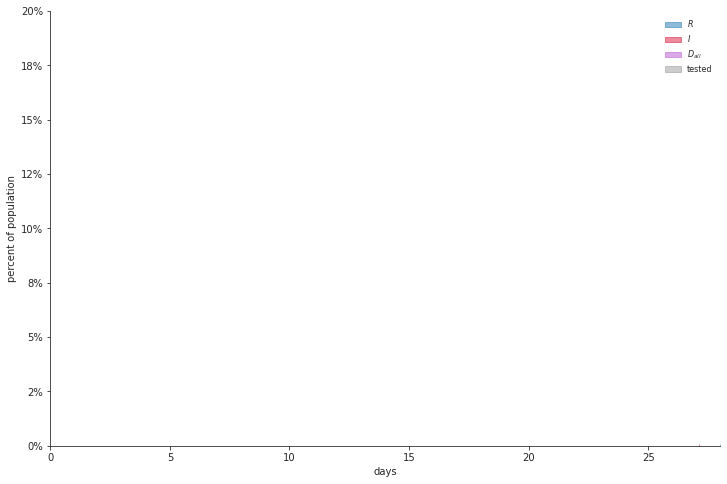

<Figure size 432x288 with 0 Axes>

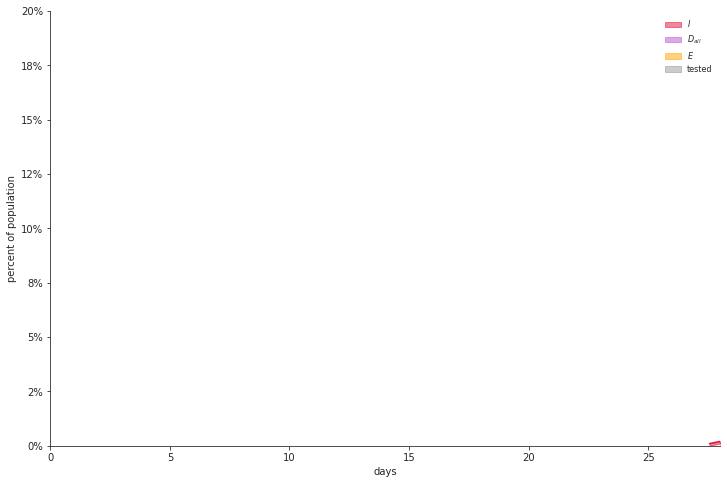

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=0 (random start 0-28.0) type 14/2


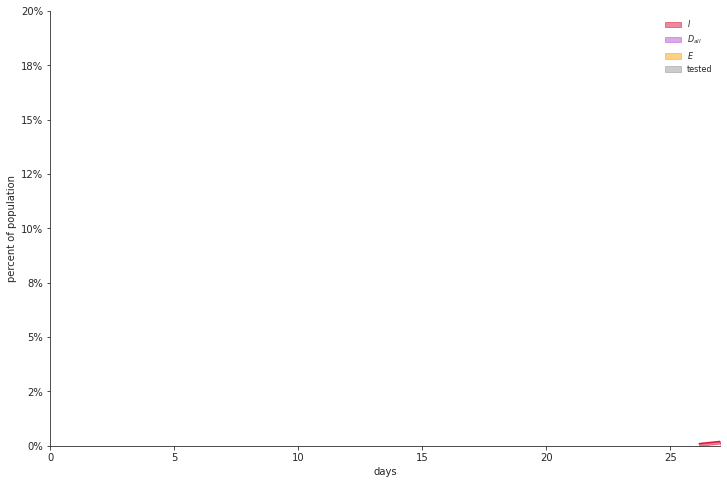

<Figure size 432x288 with 0 Axes>

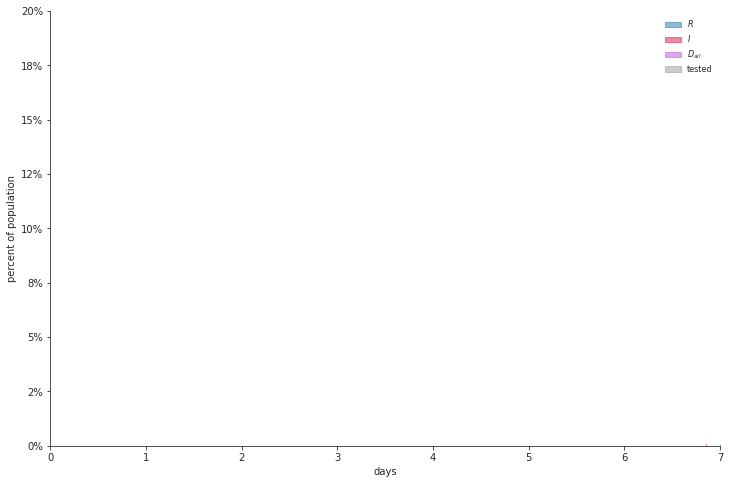

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=0 (random start 0-28.0) type 14/3


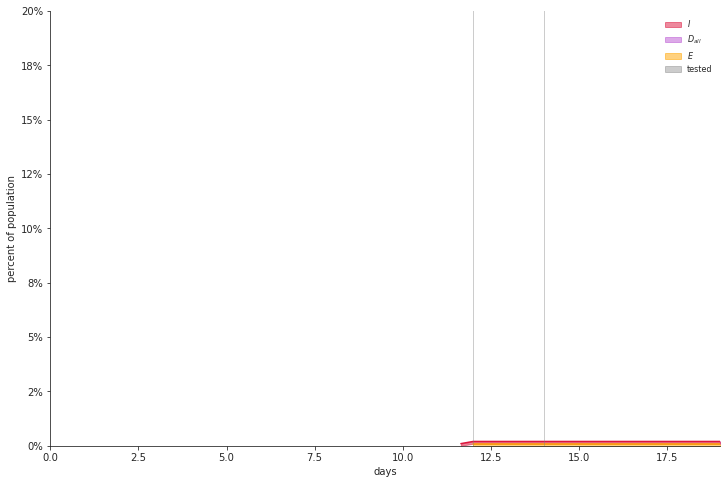

<Figure size 432x288 with 0 Axes>

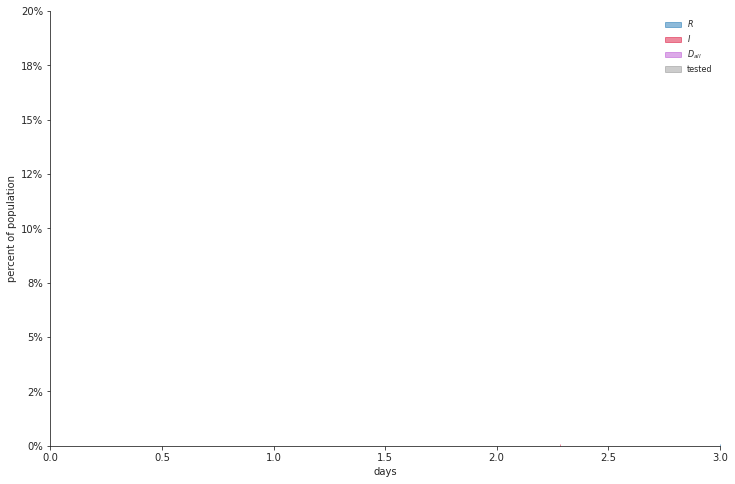

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=0 (random start 0-28.0) type 14/14


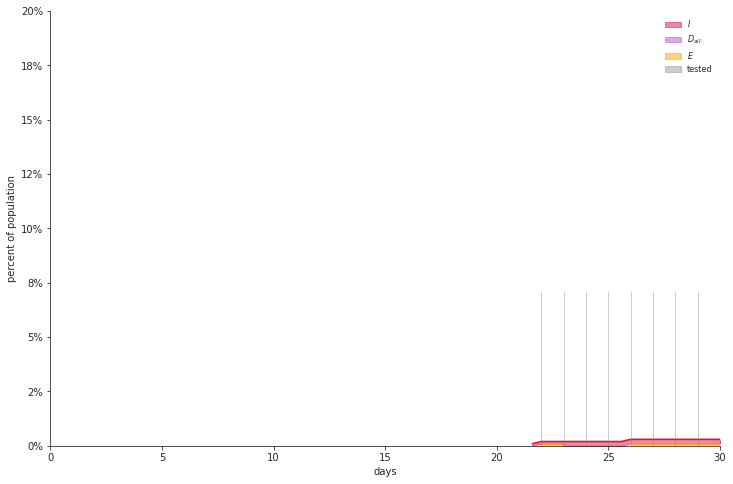

<Figure size 432x288 with 0 Axes>

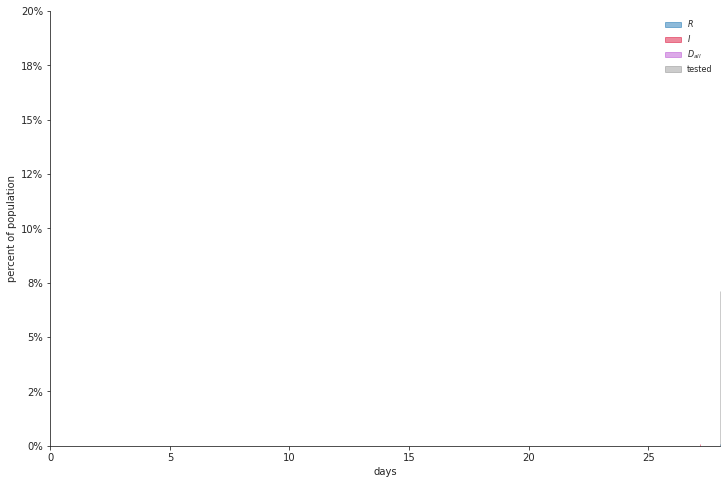

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=0 (random start 0-28.0) type No testing (56 days)


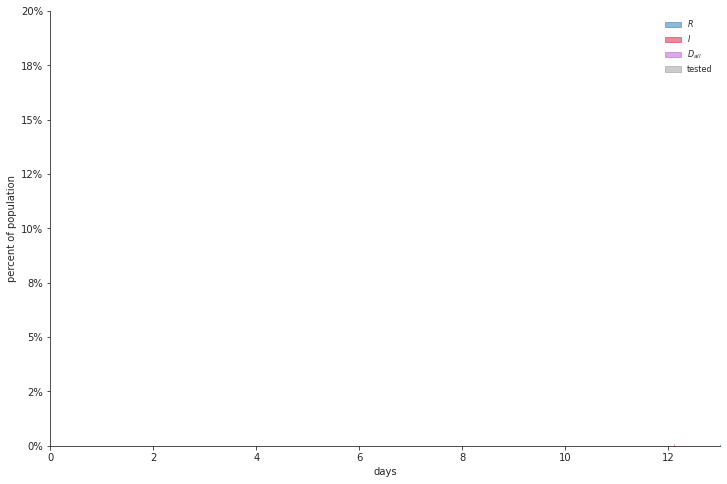

<Figure size 432x288 with 0 Axes>

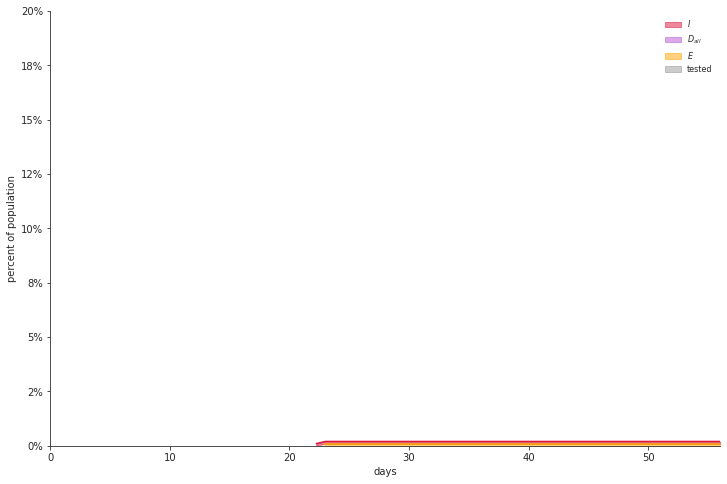

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=0 (random start 0-28.0) type No testing (108 days)


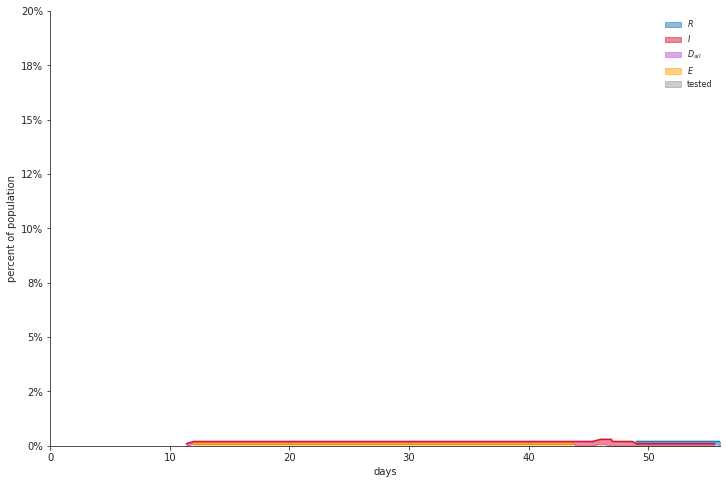

<Figure size 432x288 with 0 Axes>

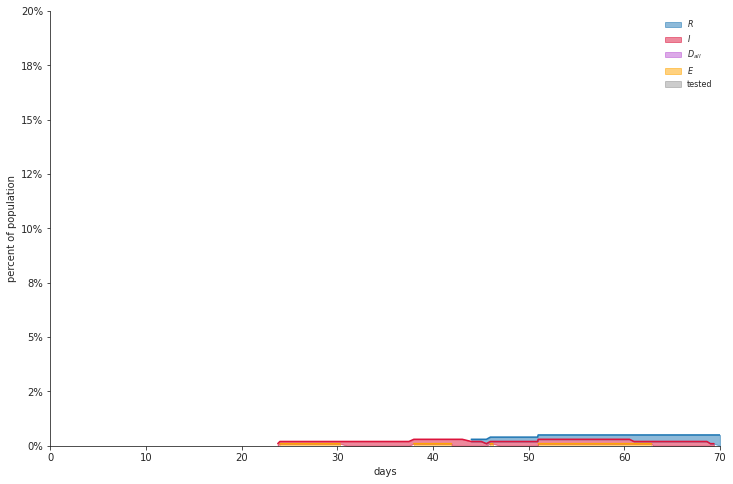

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.025,pextern=0 (random start 0-28.0) type Business closed (56 days)


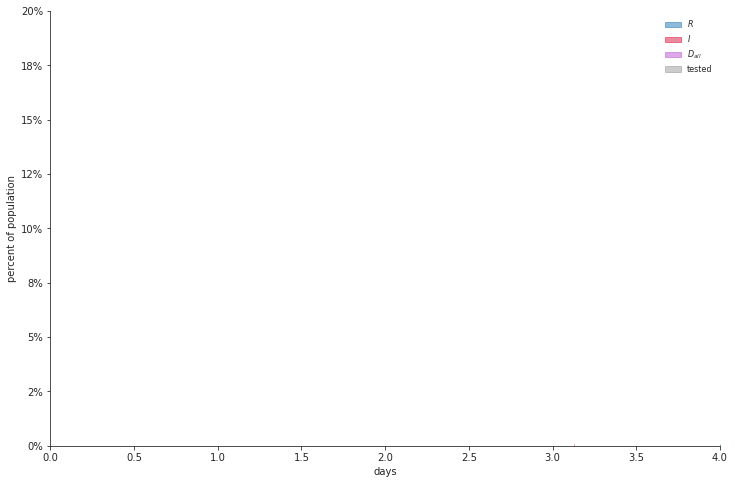

<Figure size 432x288 with 0 Axes>

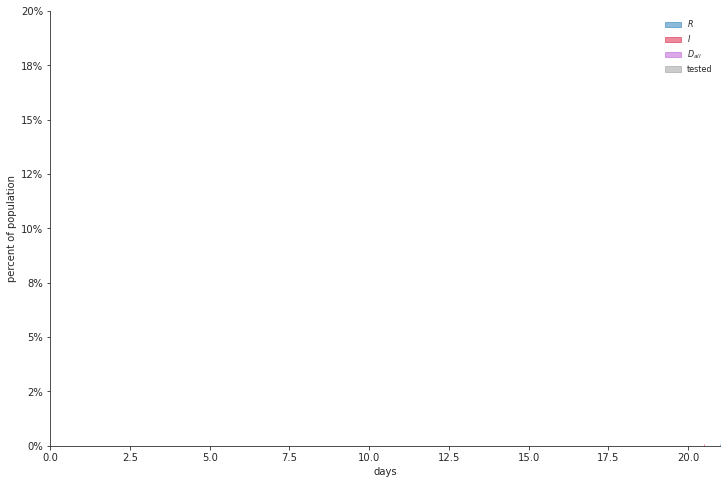

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/10000 type 28/1


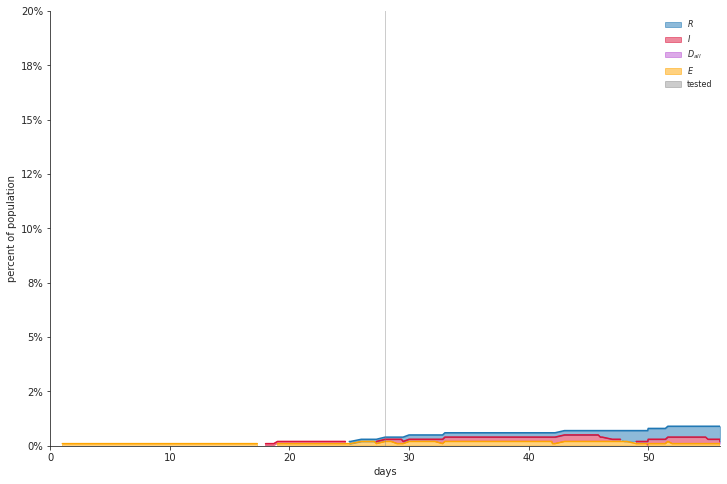

<Figure size 432x288 with 0 Axes>

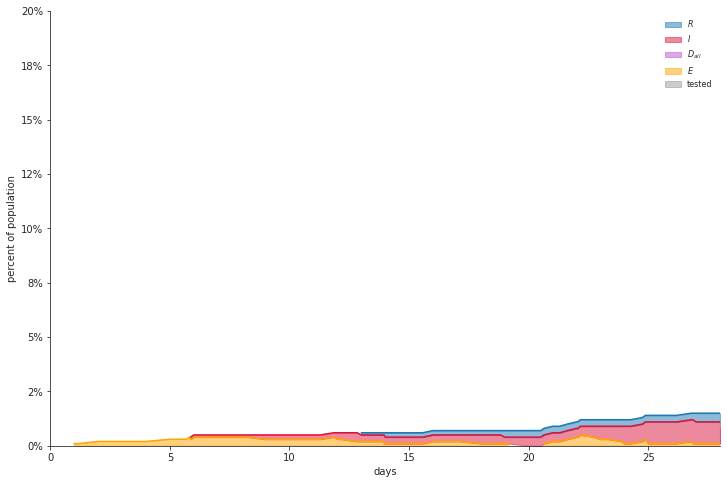

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/10000 type 28/2


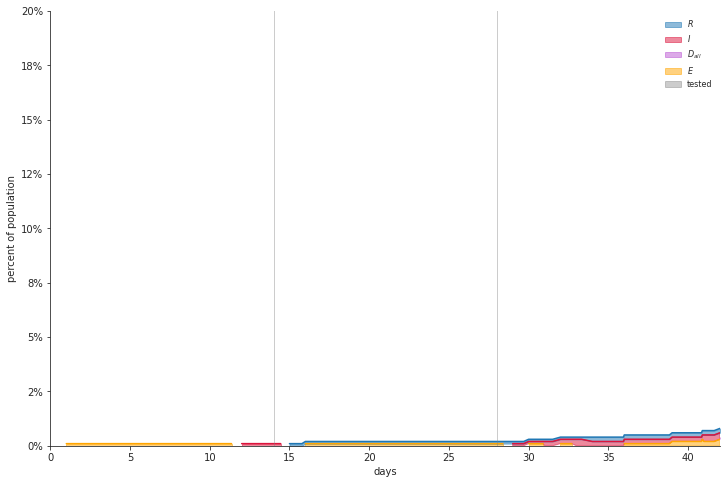

<Figure size 432x288 with 0 Axes>

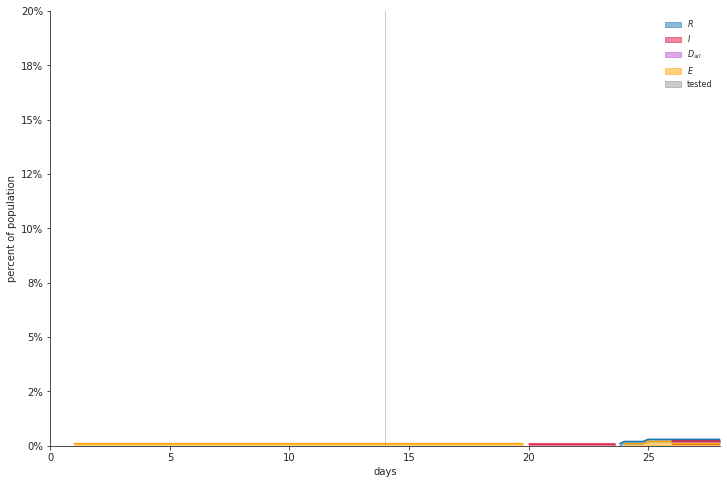

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/10000 type 28/3


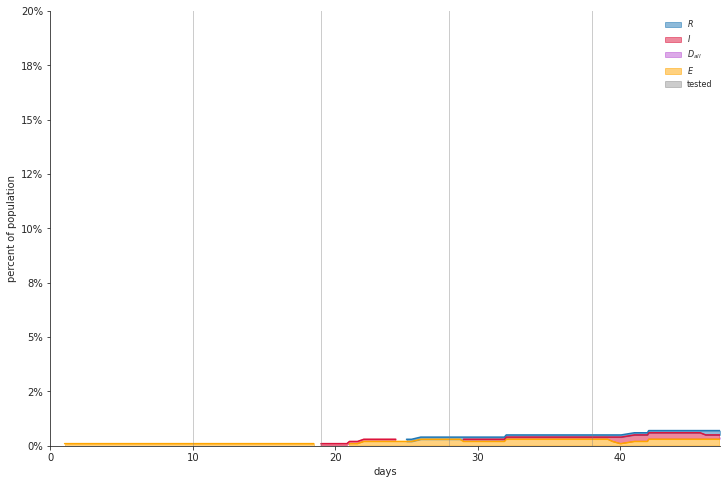

<Figure size 432x288 with 0 Axes>

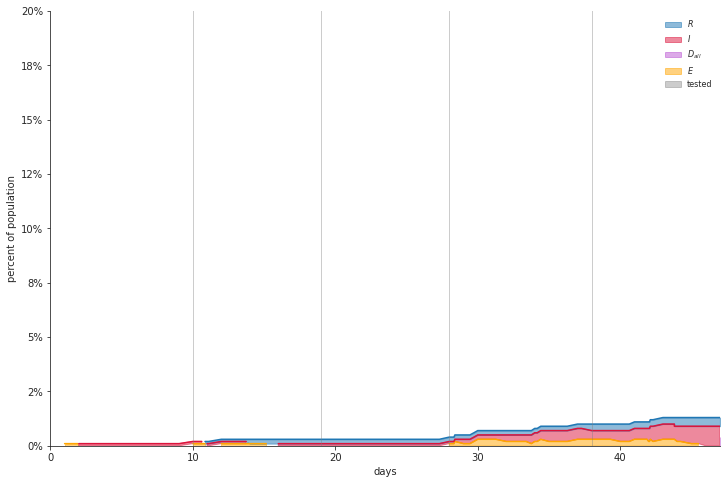

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/10000 type 28/28


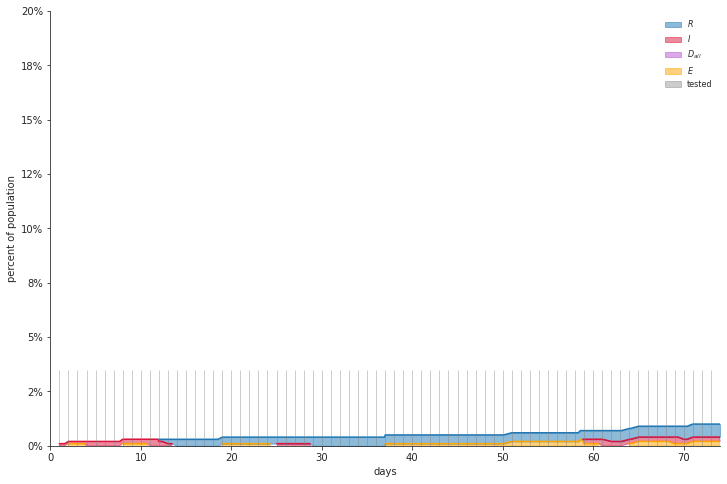

<Figure size 432x288 with 0 Axes>

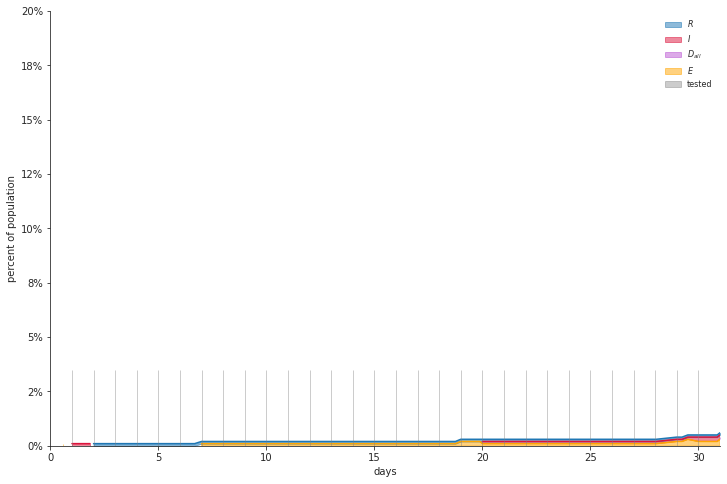

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/10000 type 14/1


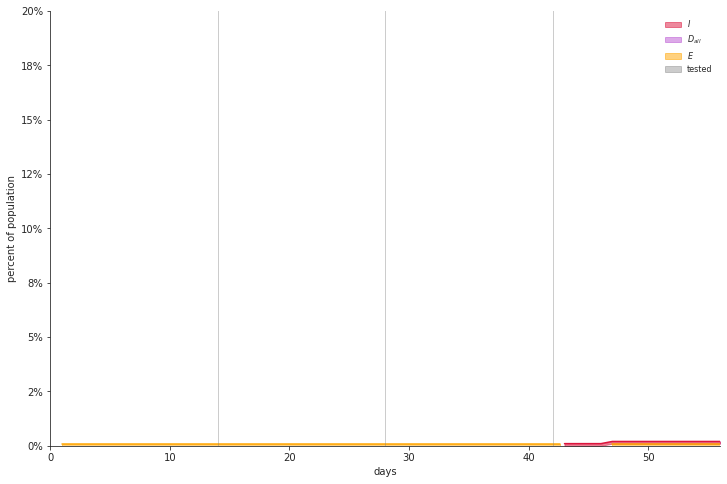

<Figure size 432x288 with 0 Axes>

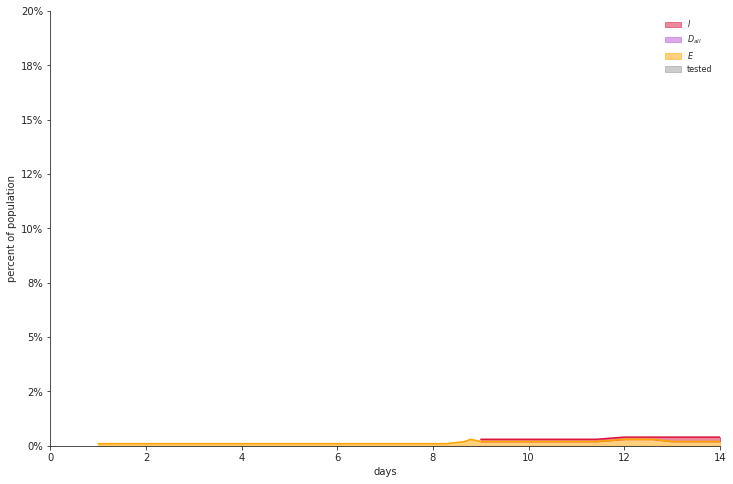

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/10000 type 14/2


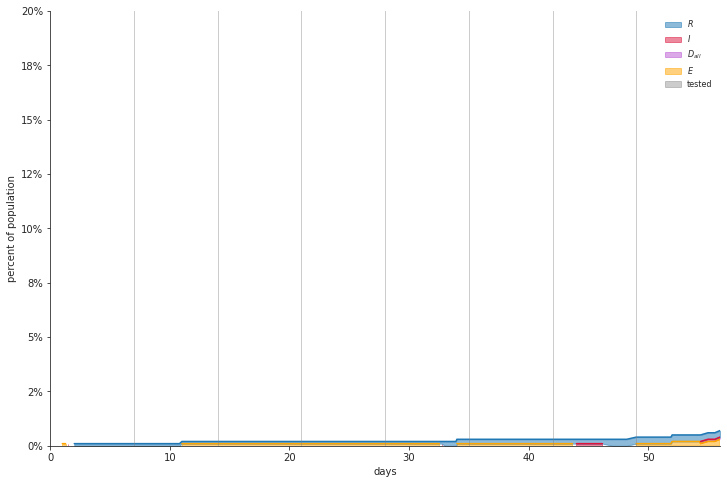

<Figure size 432x288 with 0 Axes>

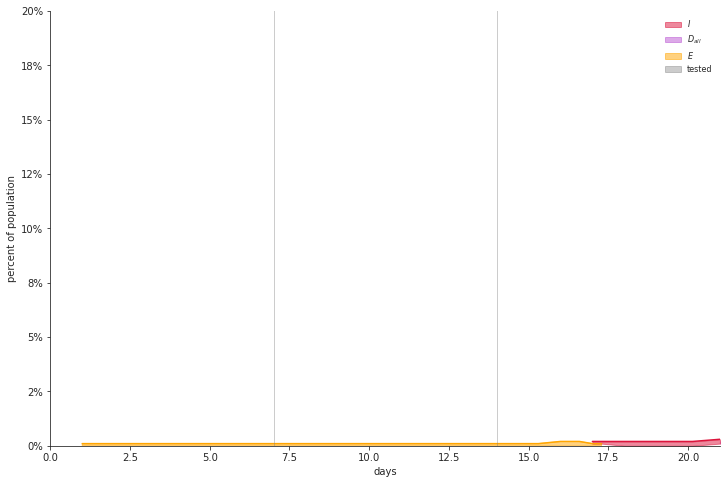

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/10000 type 14/3


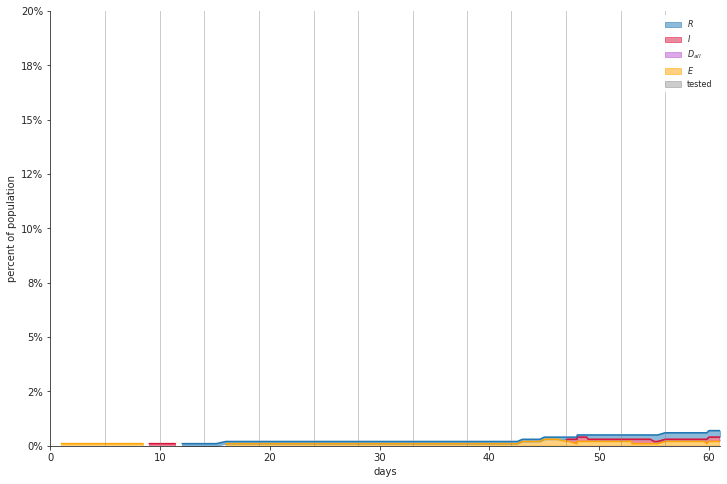

<Figure size 432x288 with 0 Axes>

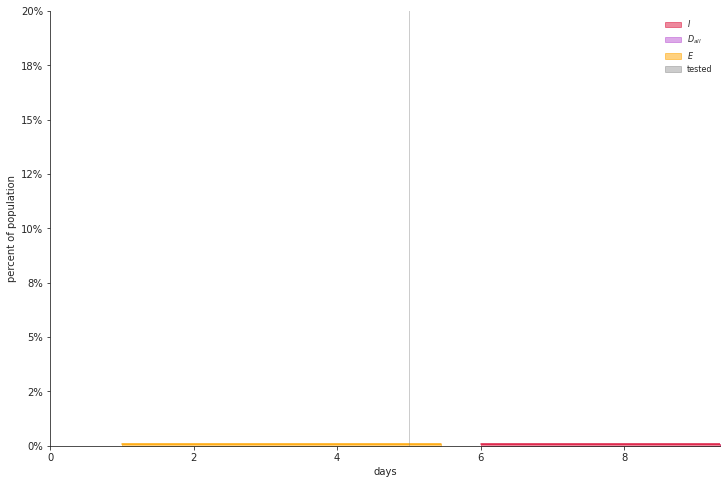

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/10000 type 14/14


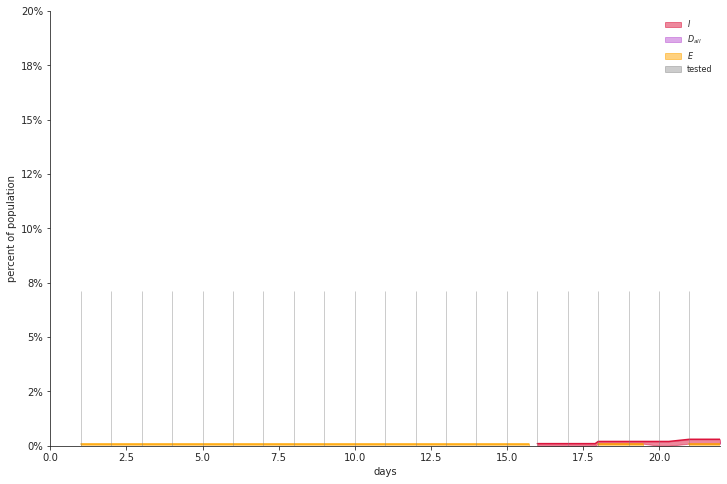

<Figure size 432x288 with 0 Axes>

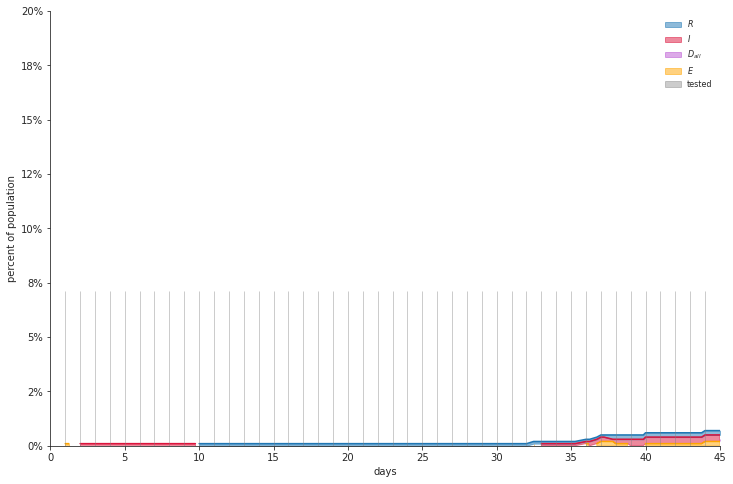

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/10000 type No testing (56 days)


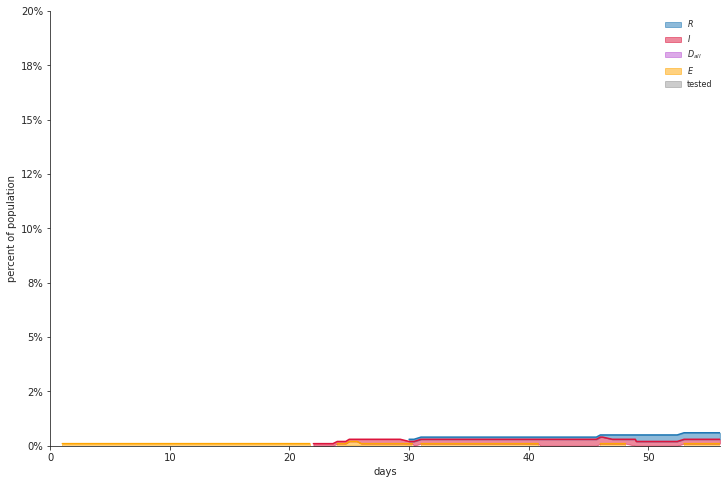

<Figure size 432x288 with 0 Axes>

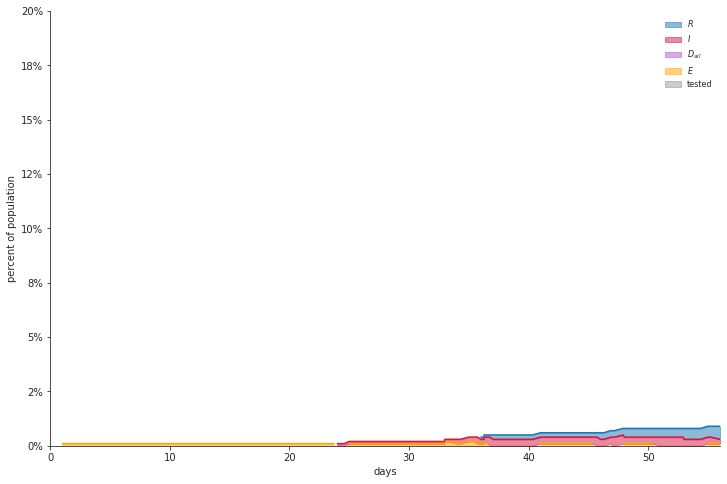

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/10000 type No testing (108 days)


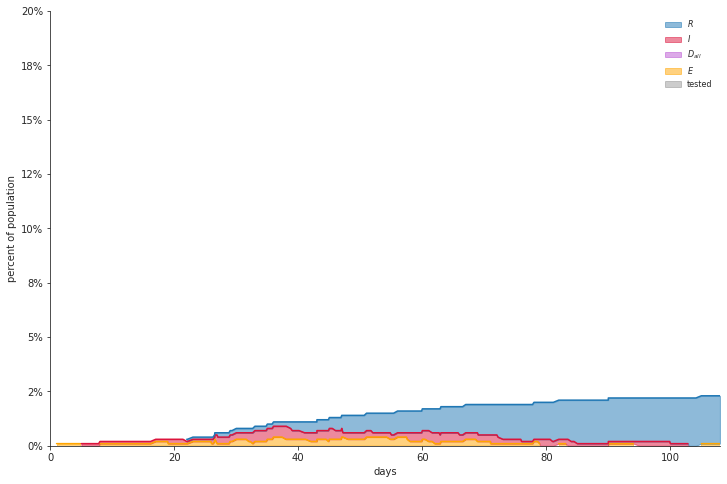

<Figure size 432x288 with 0 Axes>

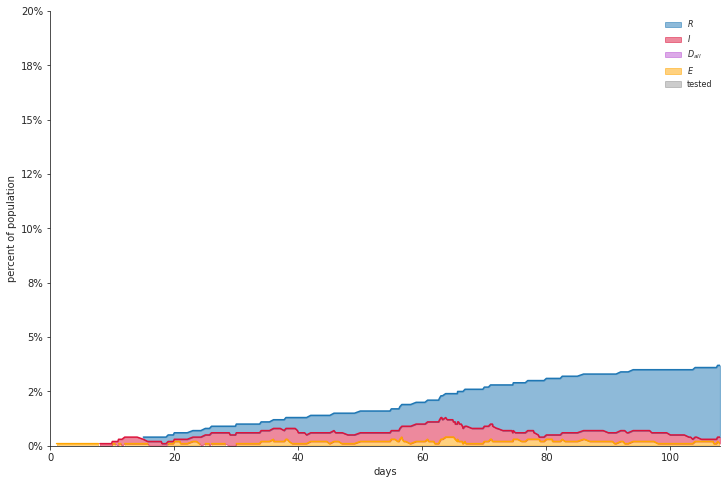

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/10000 type Business closed (56 days)


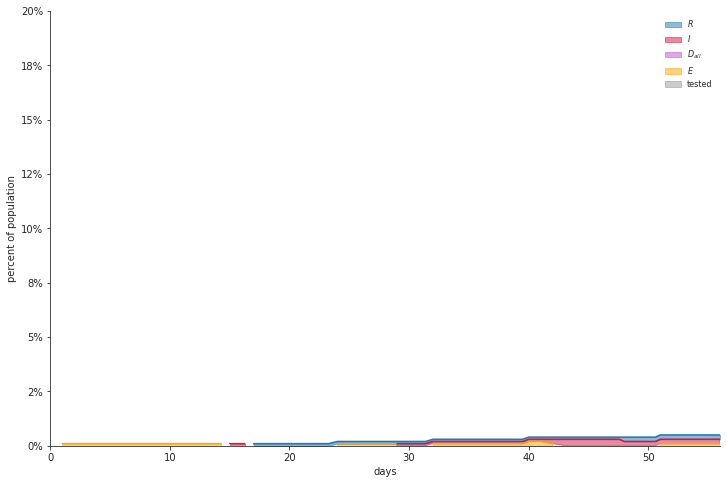

<Figure size 432x288 with 0 Axes>

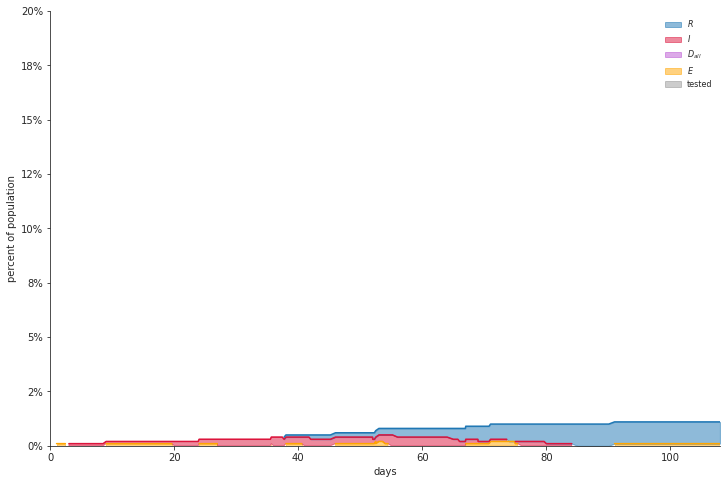

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/20000 type 28/1


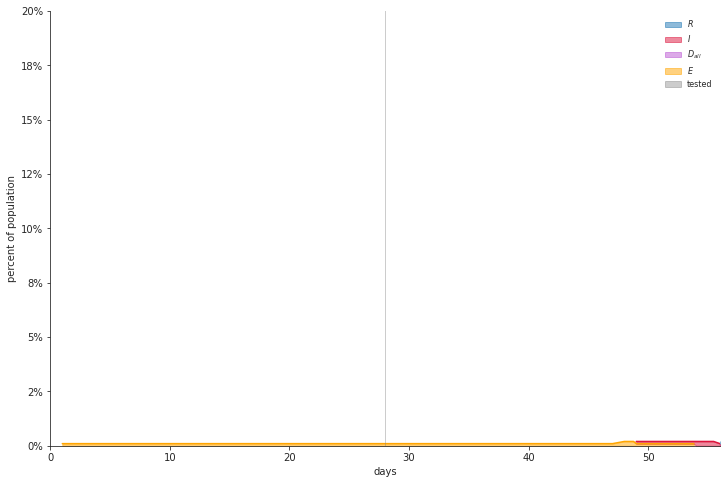

<Figure size 432x288 with 0 Axes>

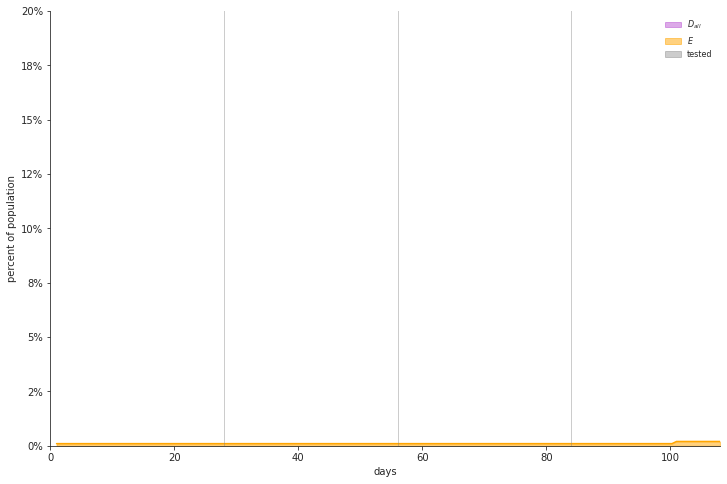

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/20000 type 28/2


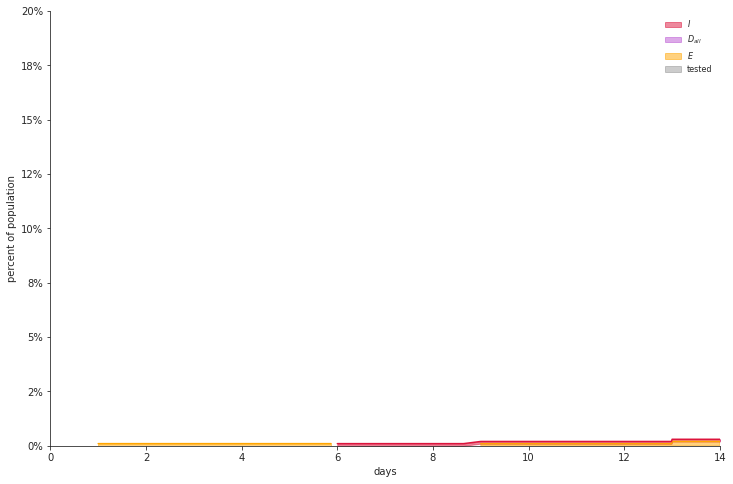

<Figure size 432x288 with 0 Axes>

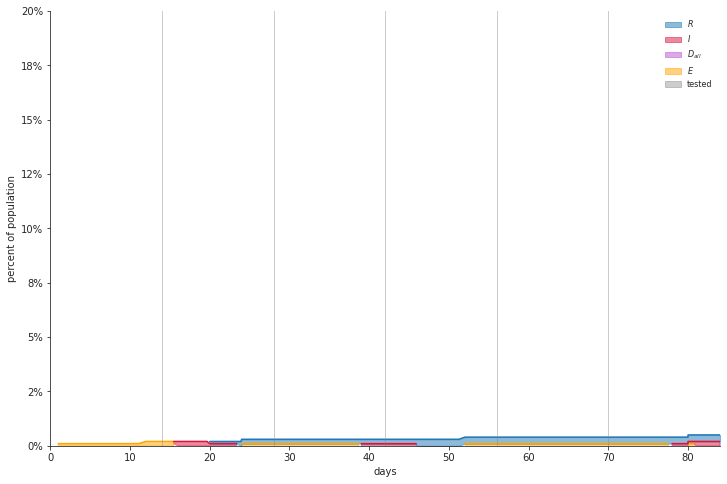

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/20000 type 28/3


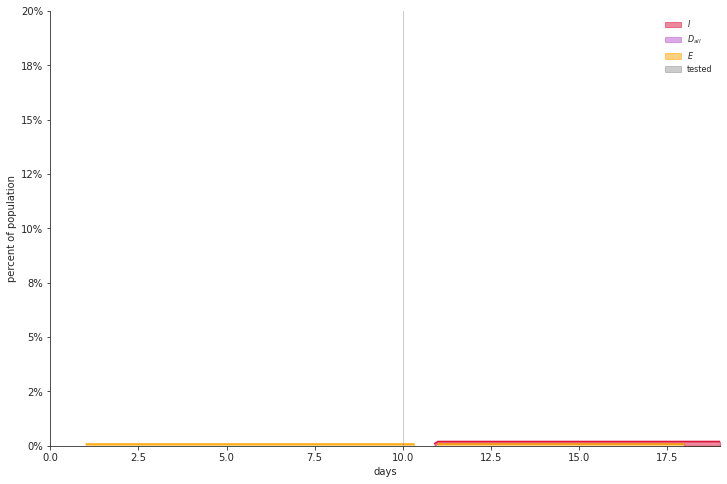

<Figure size 432x288 with 0 Axes>

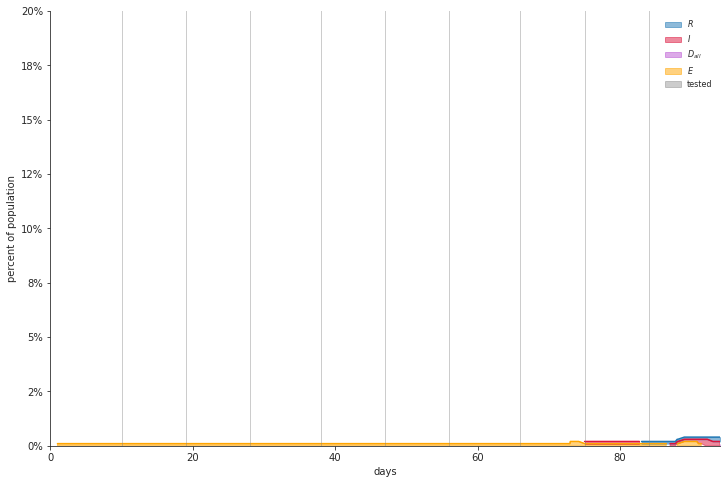

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/20000 type 28/28


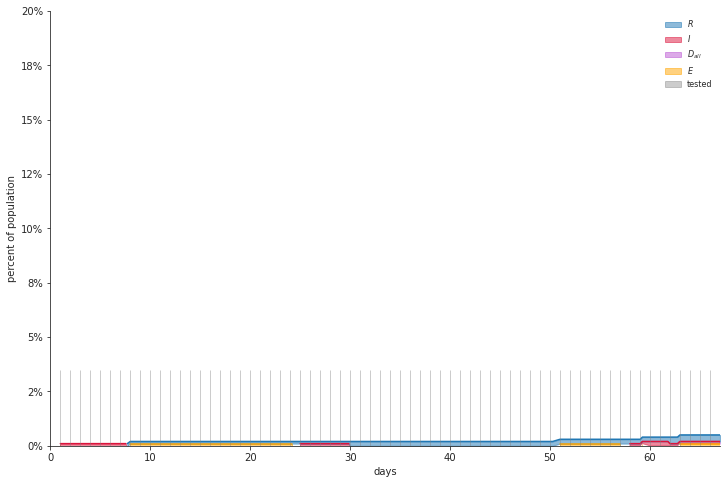

<Figure size 432x288 with 0 Axes>

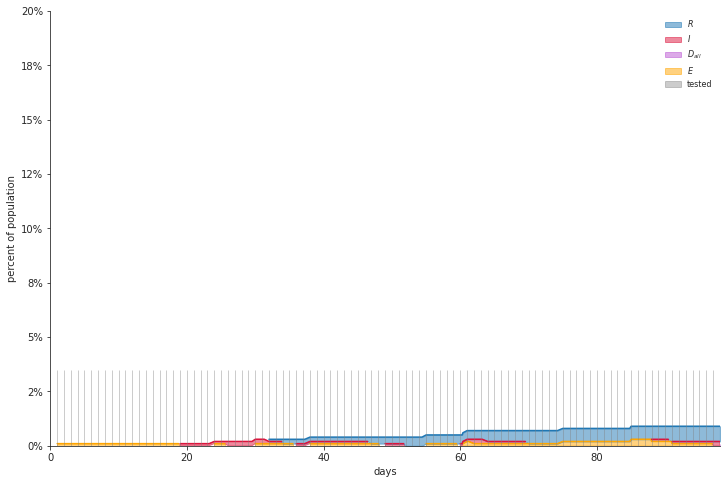

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/20000 type 14/1


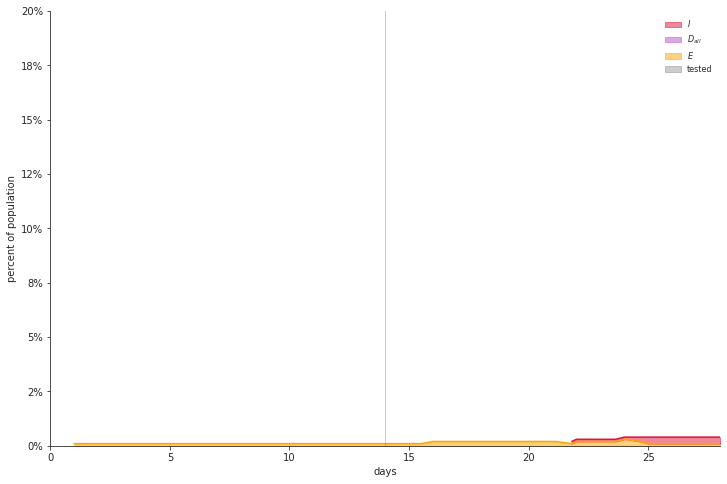

<Figure size 432x288 with 0 Axes>

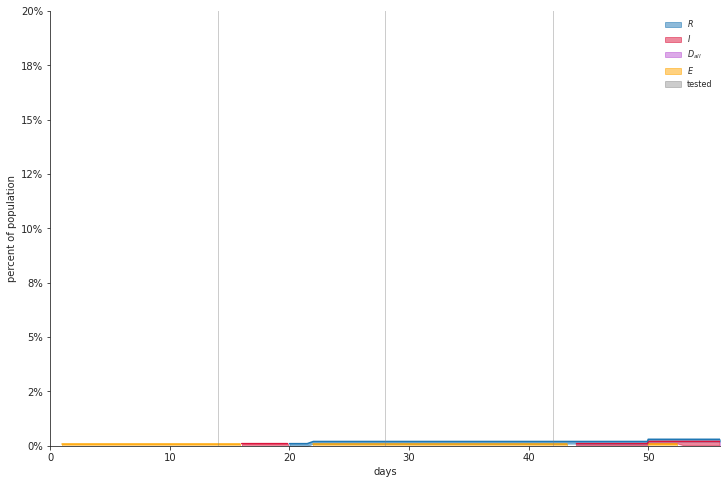

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/20000 type 14/2


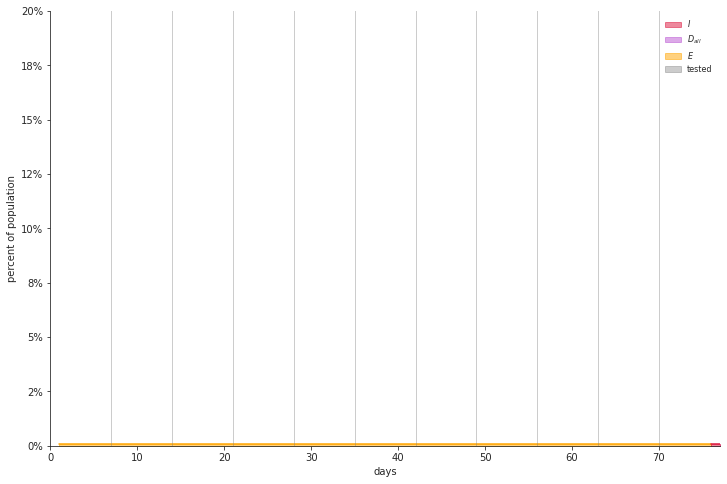

<Figure size 432x288 with 0 Axes>

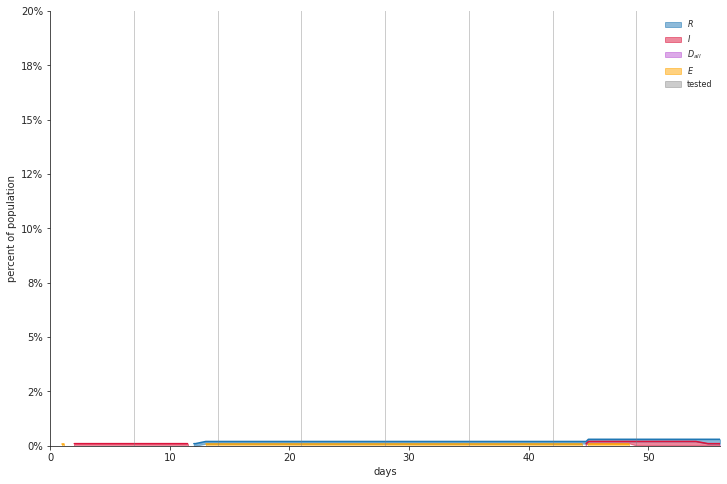

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/20000 type 14/3


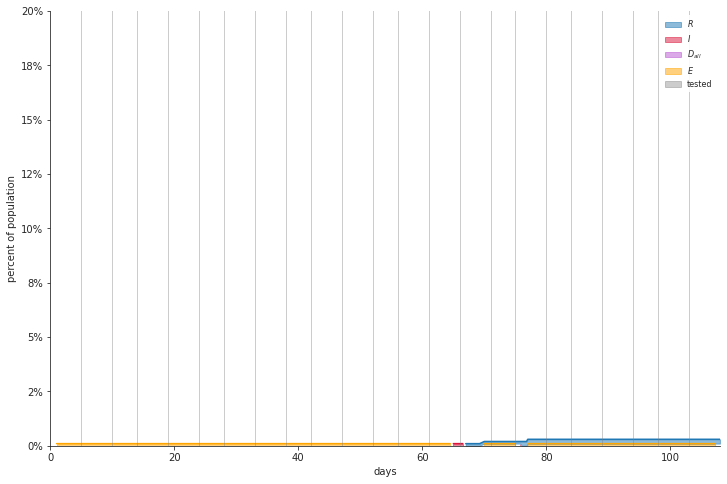

<Figure size 432x288 with 0 Axes>

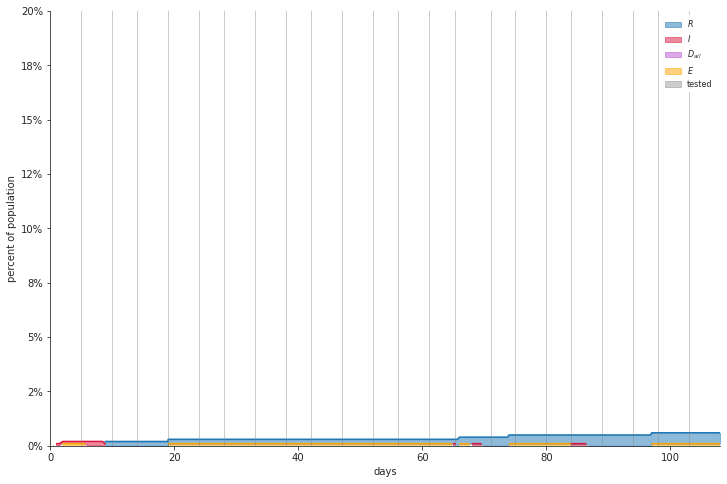

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/20000 type 14/14


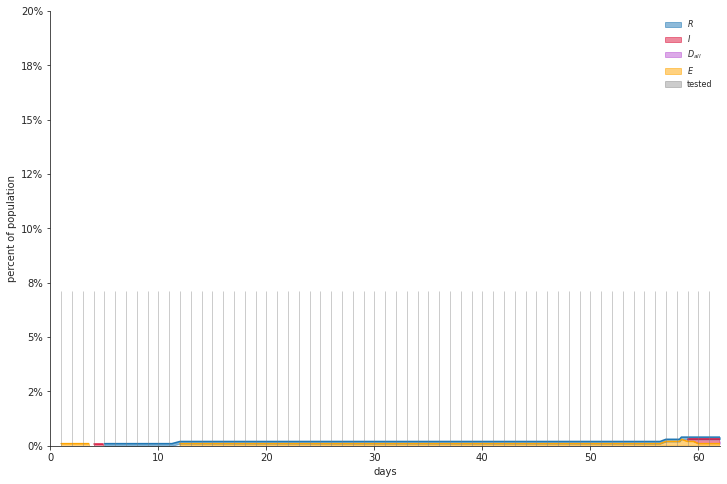

<Figure size 432x288 with 0 Axes>

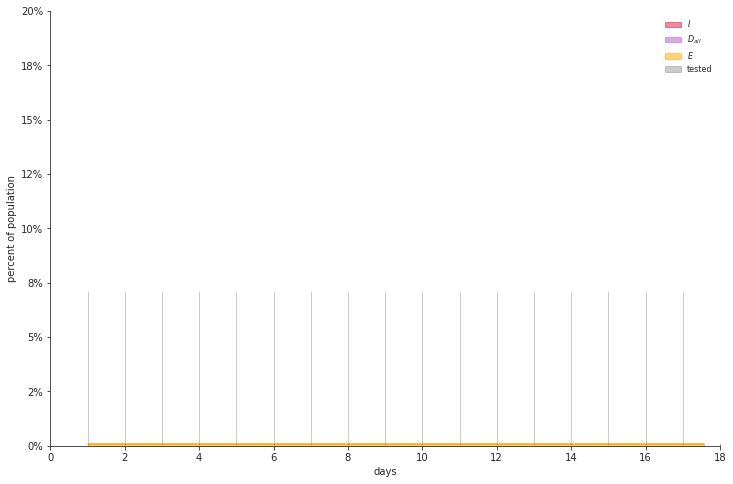

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/20000 type No testing (56 days)


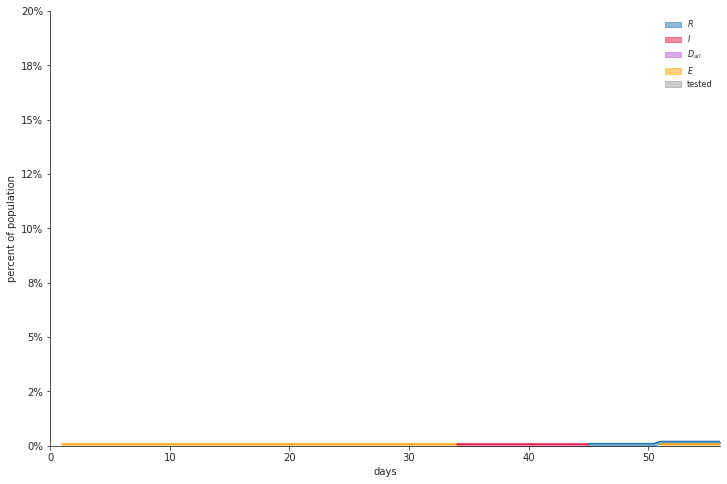

<Figure size 432x288 with 0 Axes>

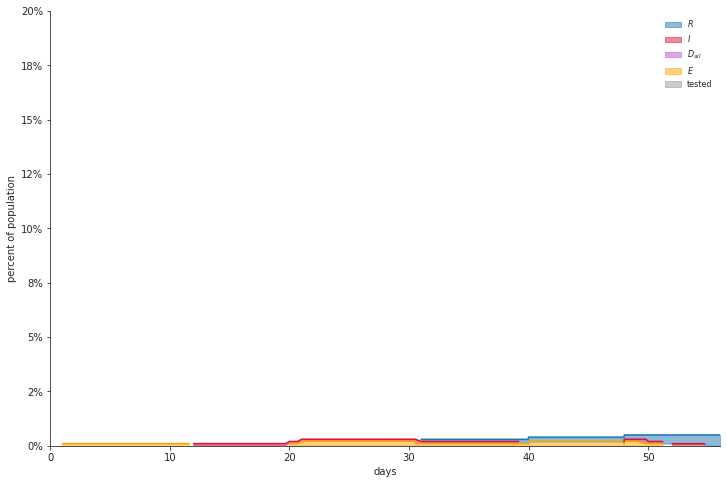

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/20000 type No testing (108 days)


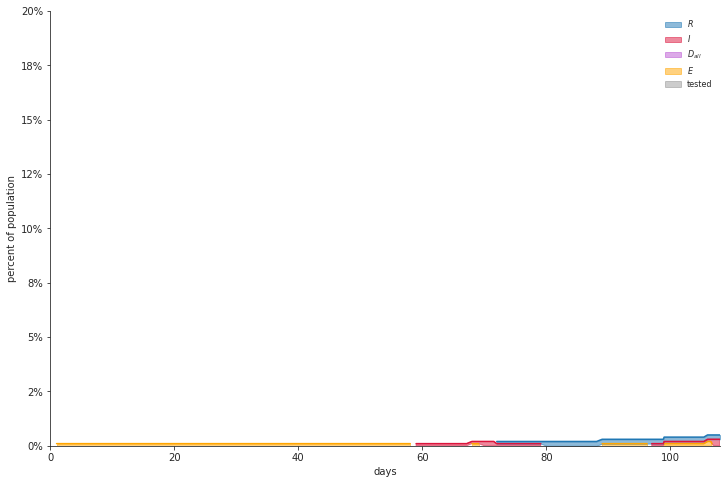

<Figure size 432x288 with 0 Axes>

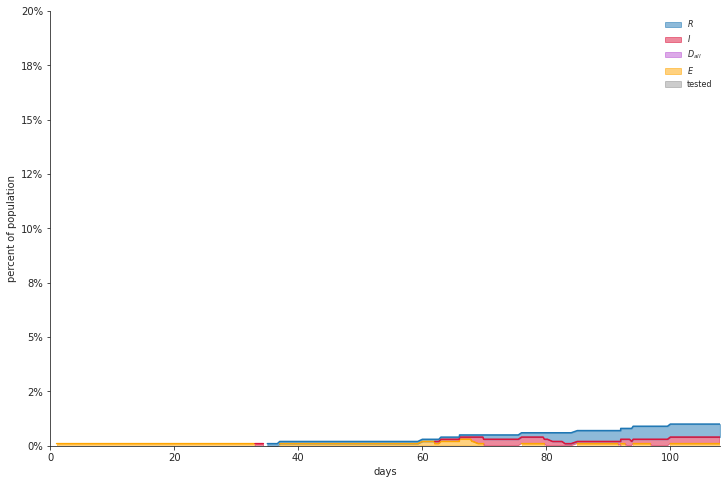

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=1/20000 type Business closed (56 days)


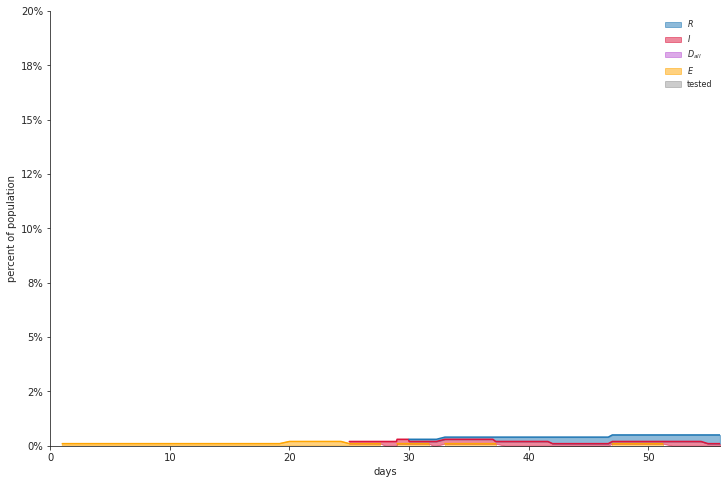

<Figure size 432x288 with 0 Axes>

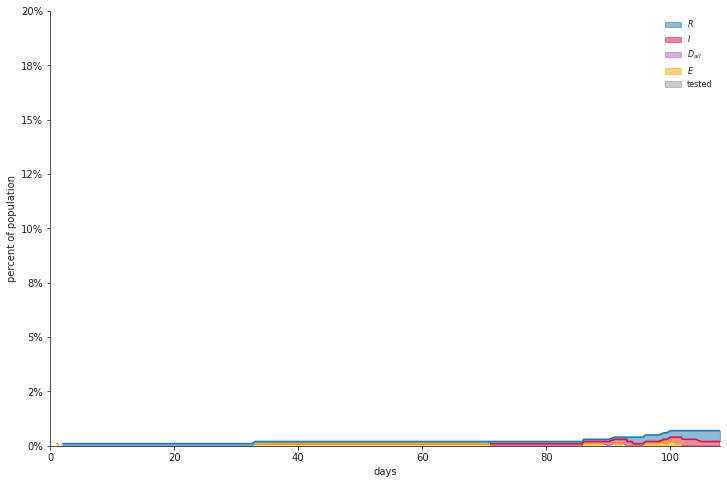

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=0 (random start 0-28.0) type 28/1


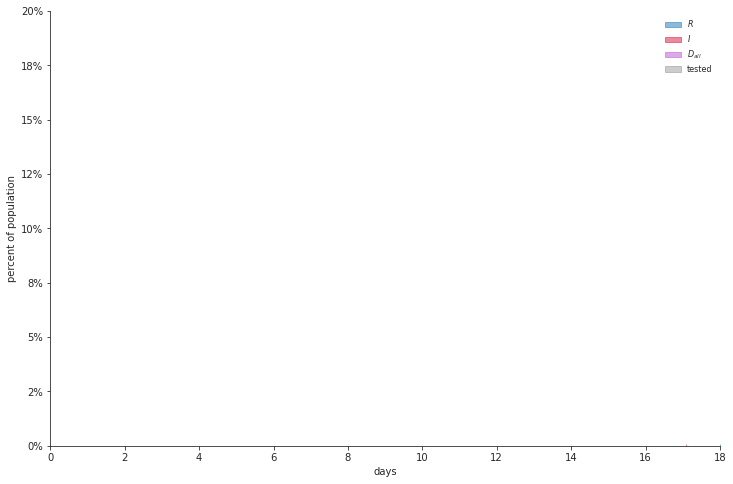

<Figure size 432x288 with 0 Axes>

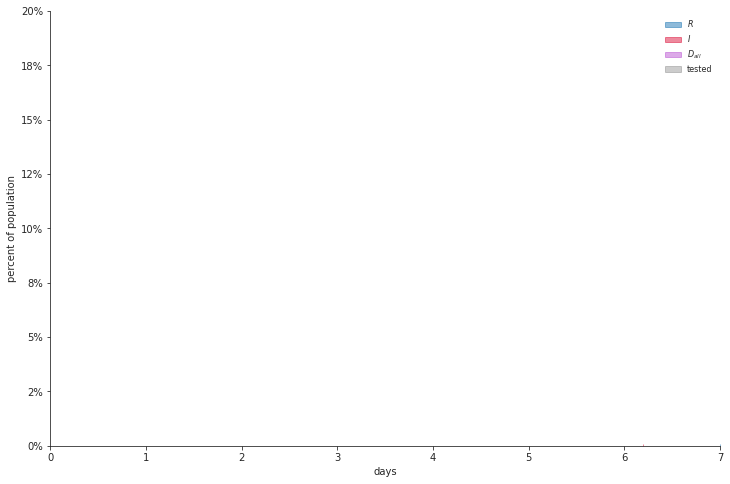

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=0 (random start 0-28.0) type 28/2


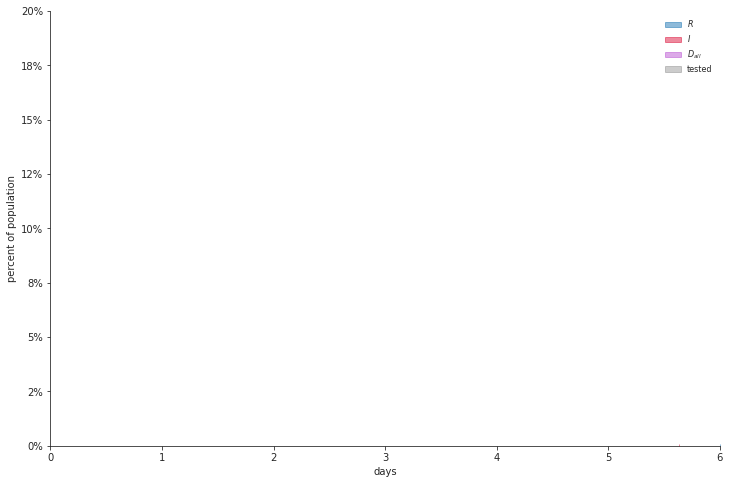

<Figure size 432x288 with 0 Axes>

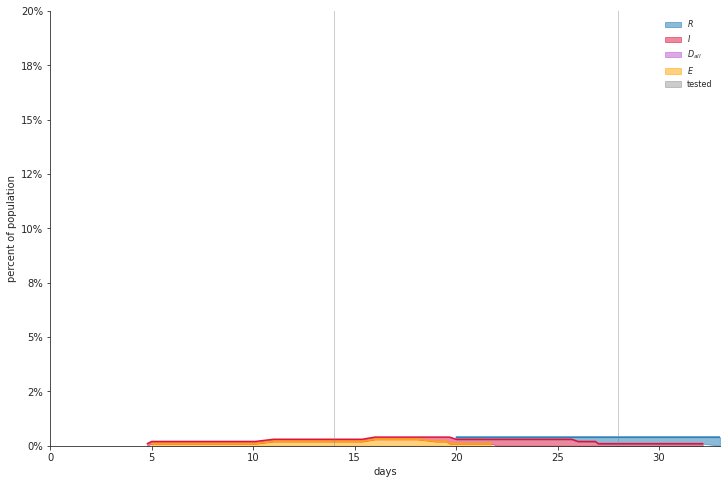

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=0 (random start 0-28.0) type 28/3


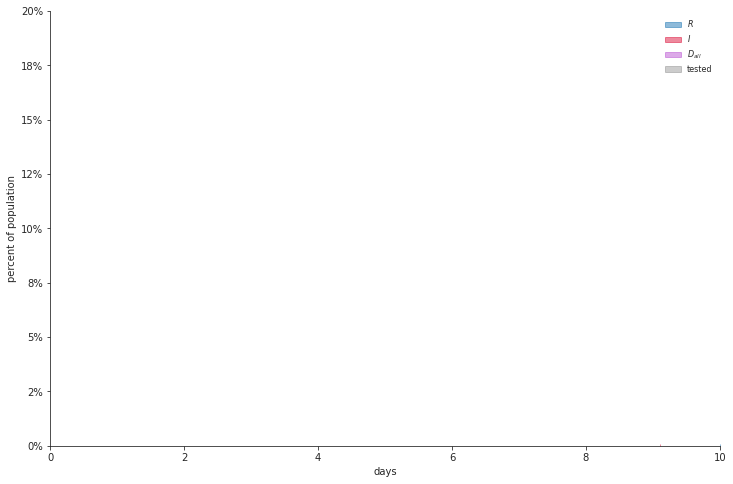

<Figure size 432x288 with 0 Axes>

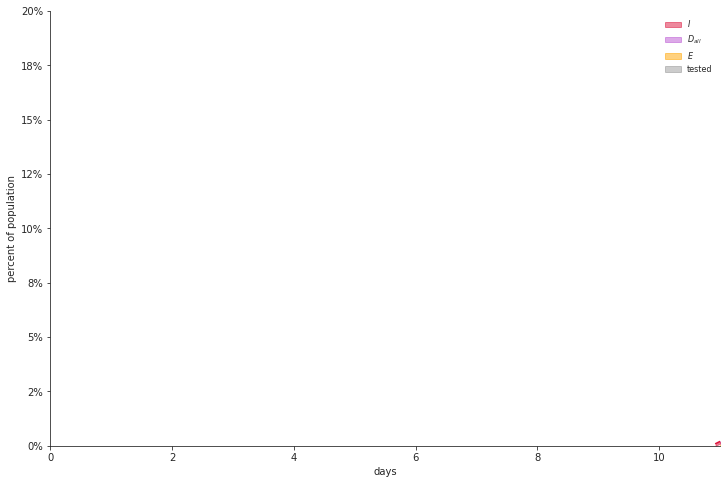

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=0 (random start 0-28.0) type 28/28


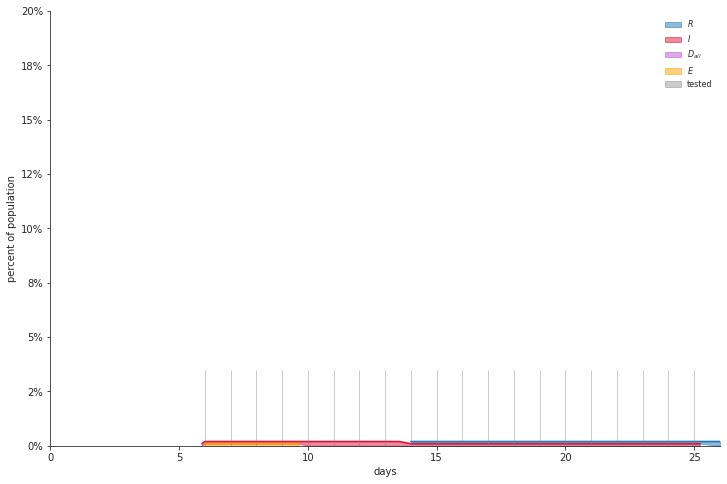

<Figure size 432x288 with 0 Axes>

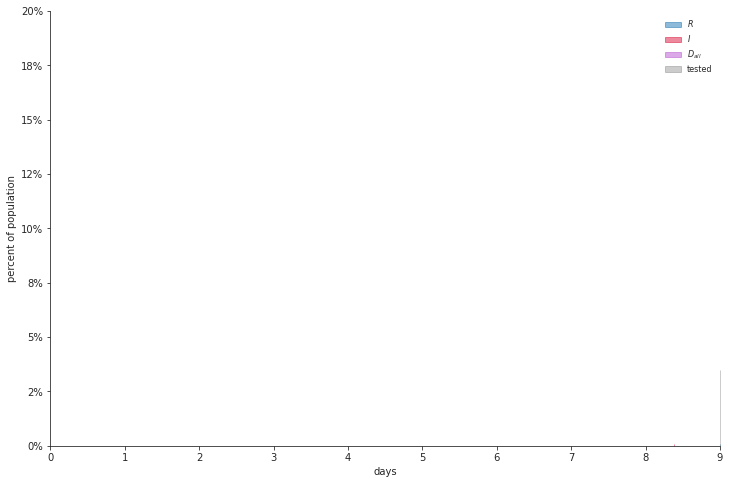

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=0 (random start 0-28.0) type 14/1


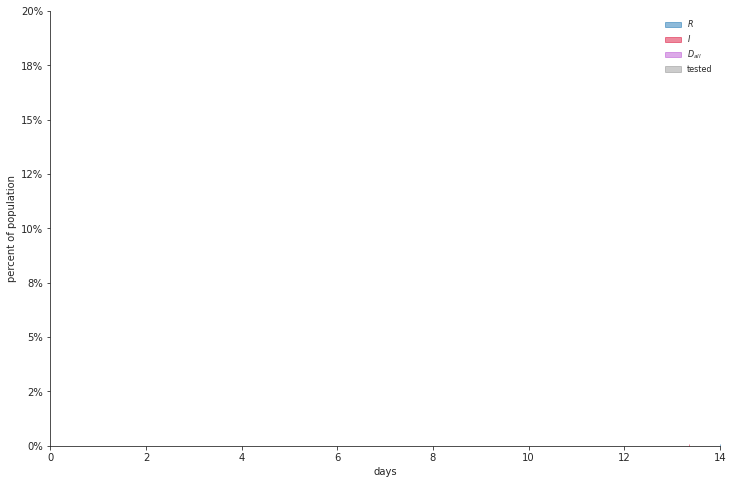

<Figure size 432x288 with 0 Axes>

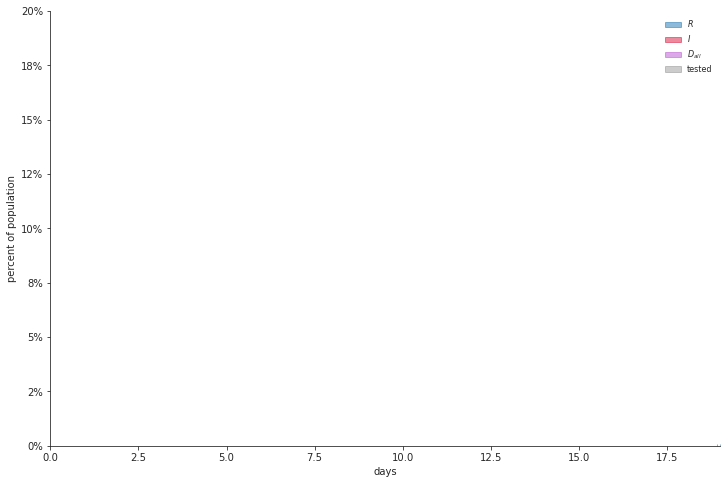

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=0 (random start 0-28.0) type 14/2


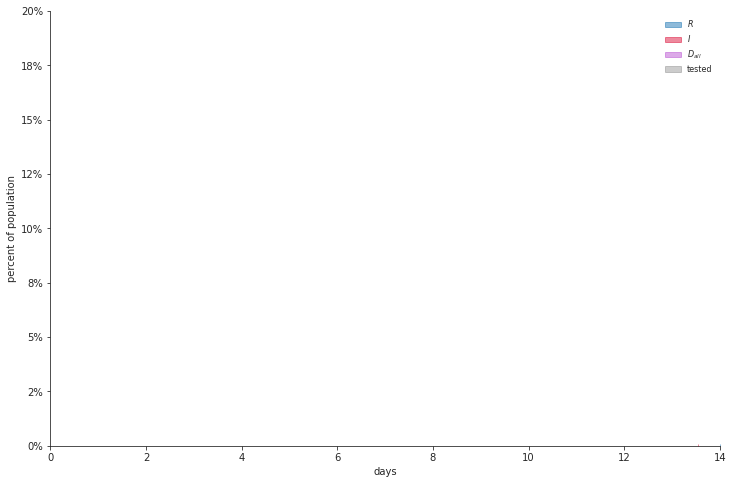

<Figure size 432x288 with 0 Axes>

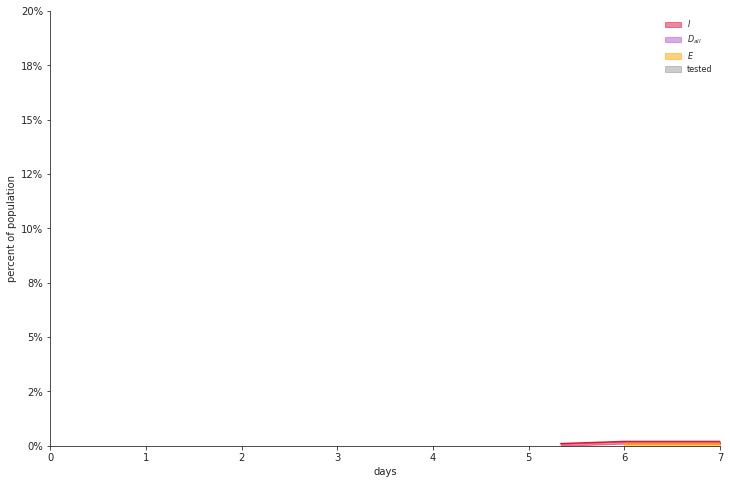

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=0 (random start 0-28.0) type 14/3


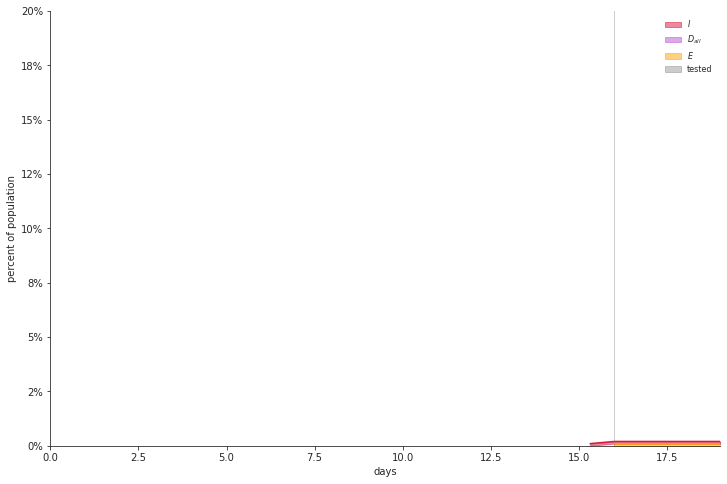

<Figure size 432x288 with 0 Axes>

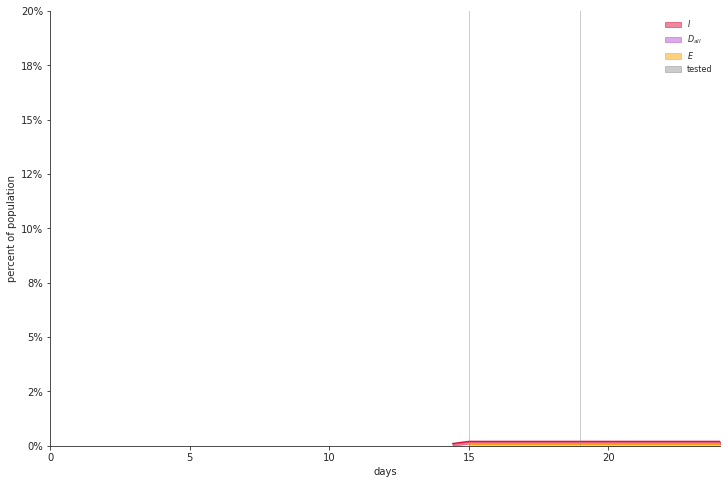

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=0 (random start 0-28.0) type 14/14


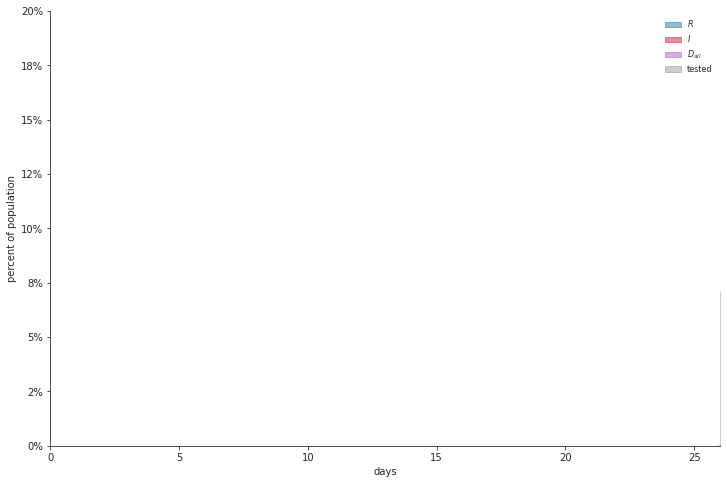

<Figure size 432x288 with 0 Axes>

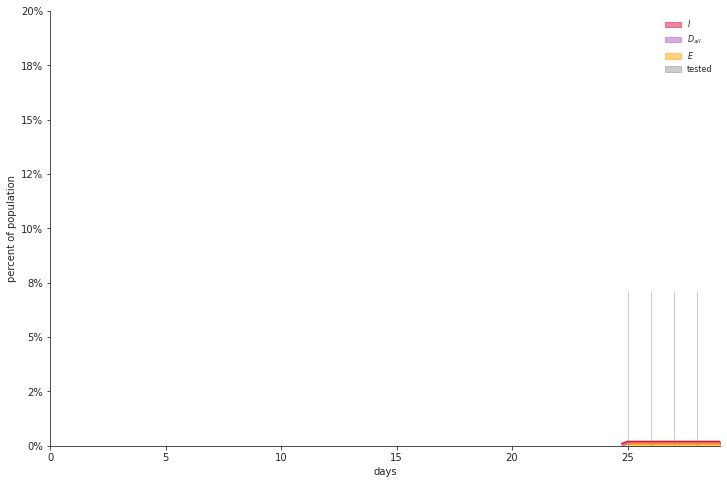

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=0 (random start 0-28.0) type No testing (56 days)


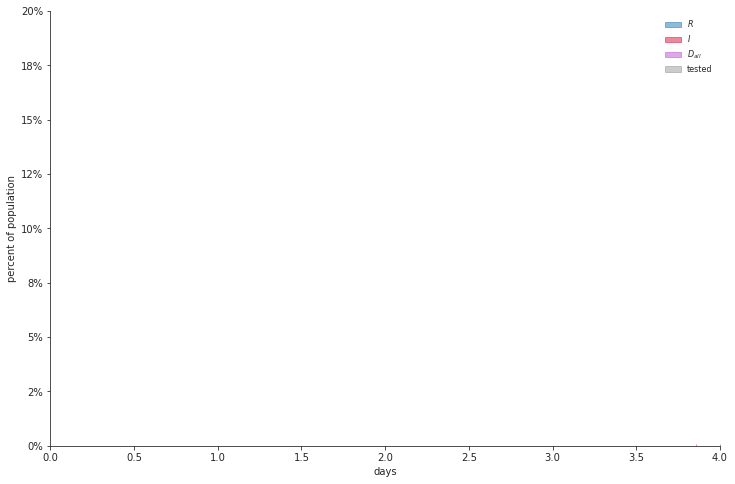

<Figure size 432x288 with 0 Axes>

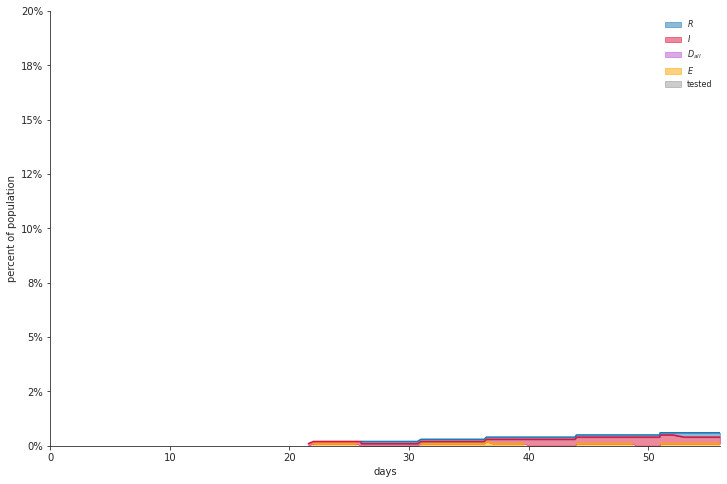

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=0 (random start 0-28.0) type No testing (108 days)


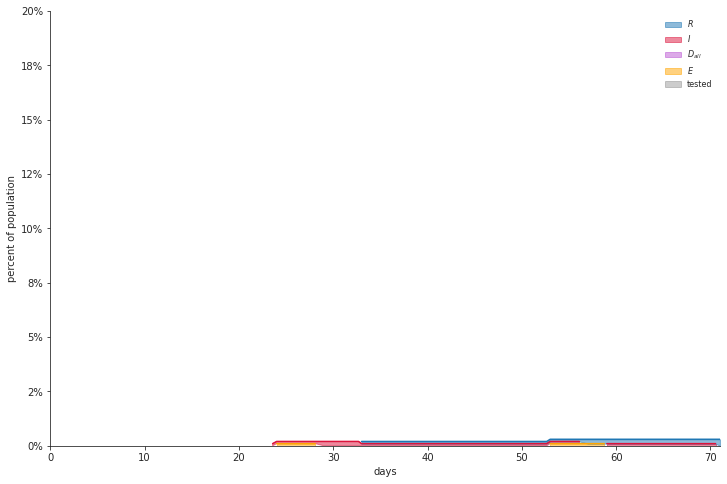

<Figure size 432x288 with 0 Axes>

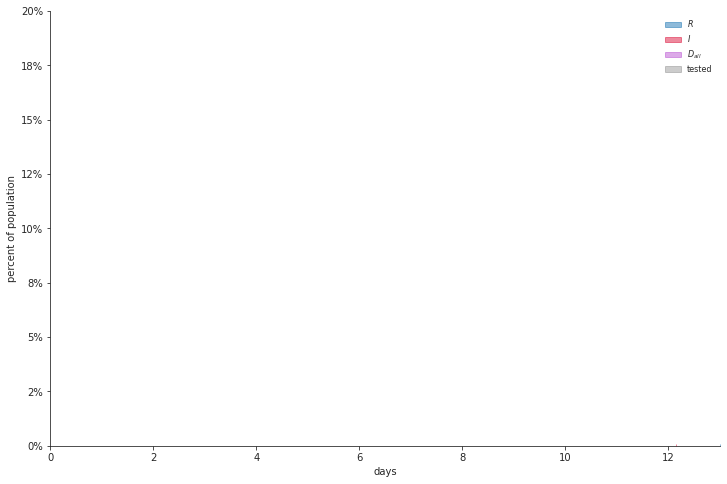

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.05,pextern=0 (random start 0-28.0) type Business closed (56 days)


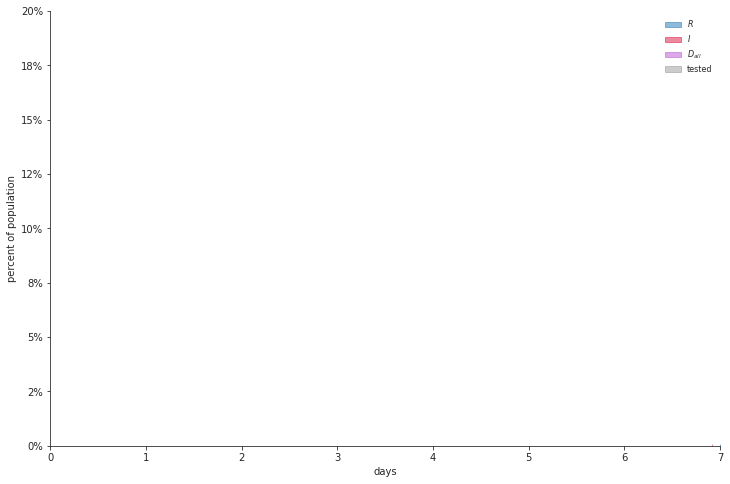

<Figure size 432x288 with 0 Axes>

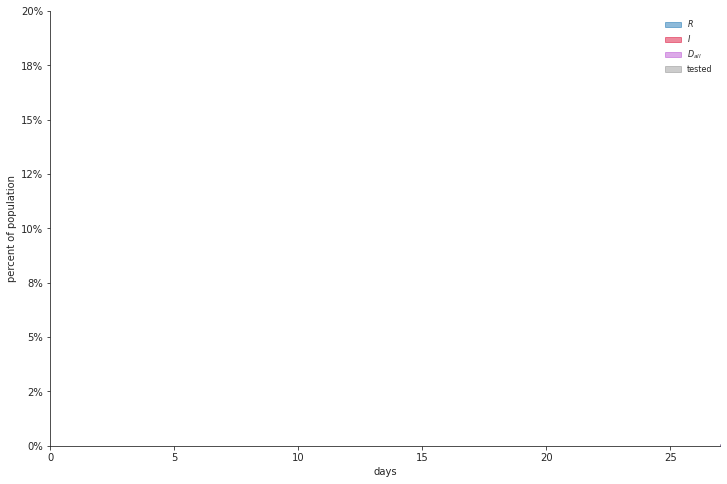

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/10000 type 28/1


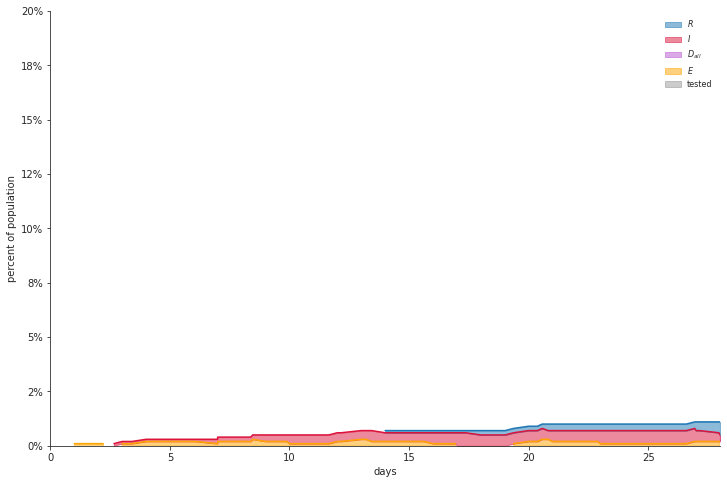

<Figure size 432x288 with 0 Axes>

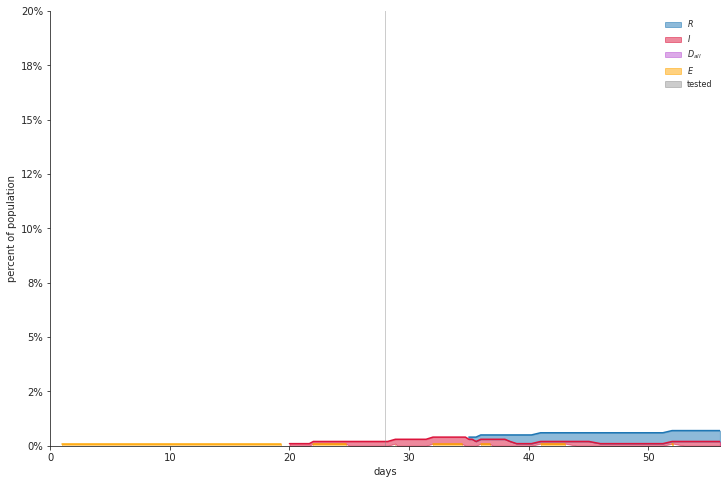

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/10000 type 28/2


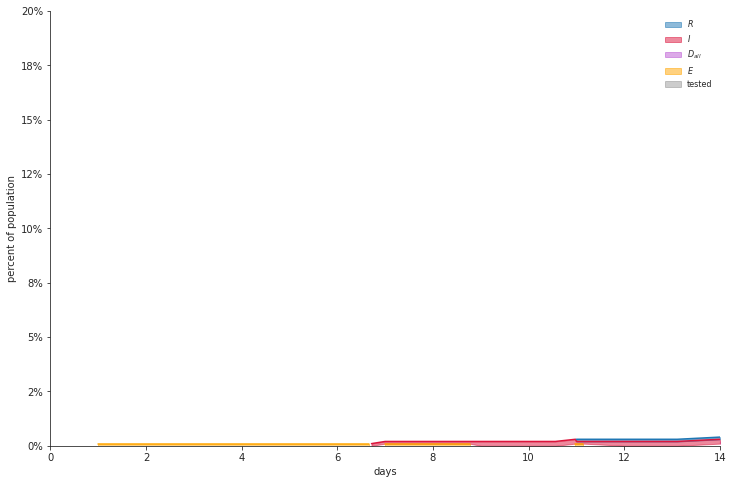

<Figure size 432x288 with 0 Axes>

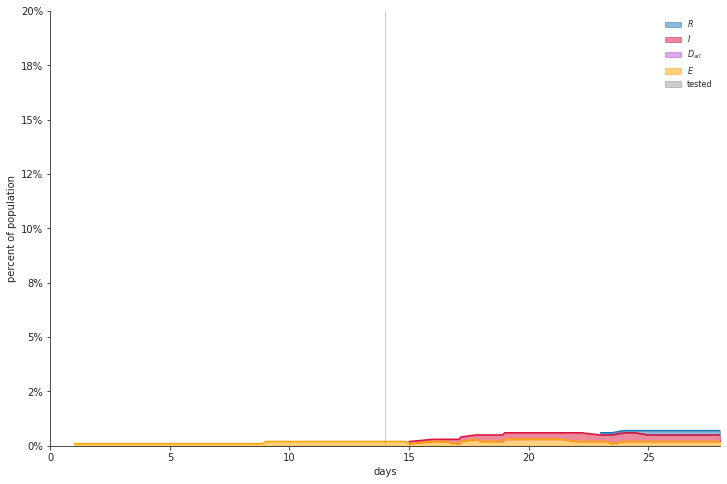

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/10000 type 28/3


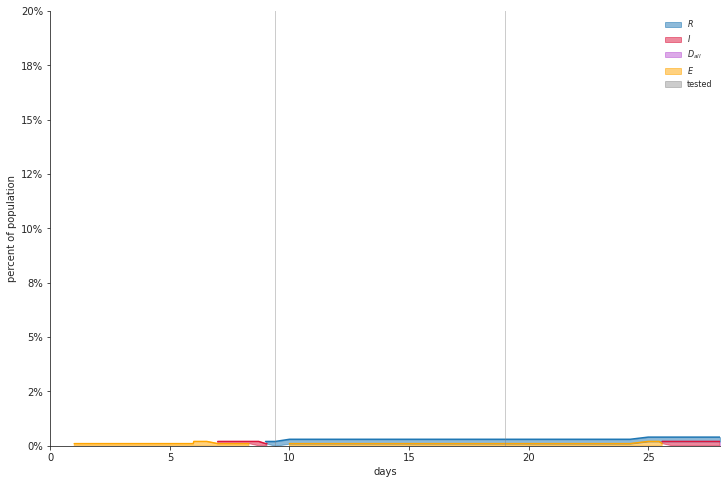

<Figure size 432x288 with 0 Axes>

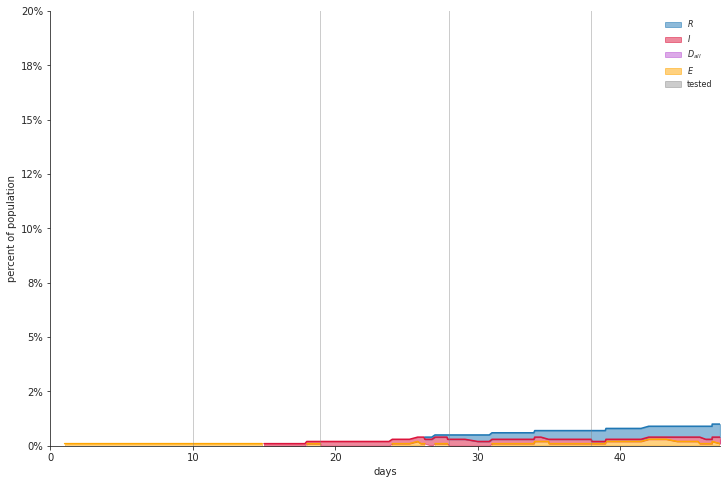

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/10000 type 28/28


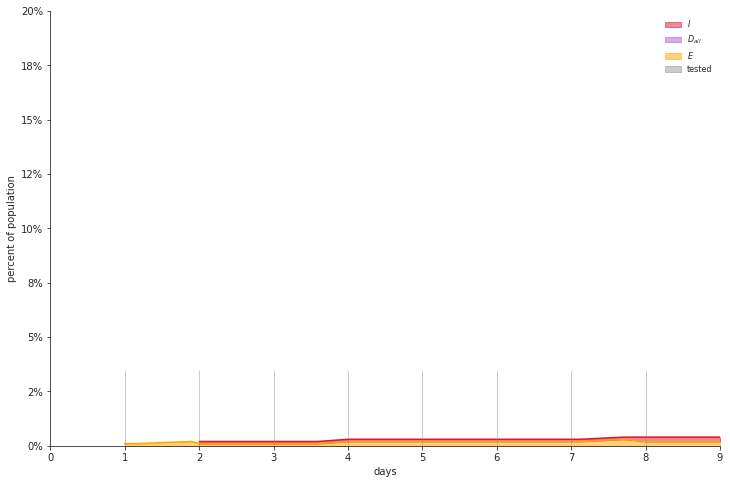

<Figure size 432x288 with 0 Axes>

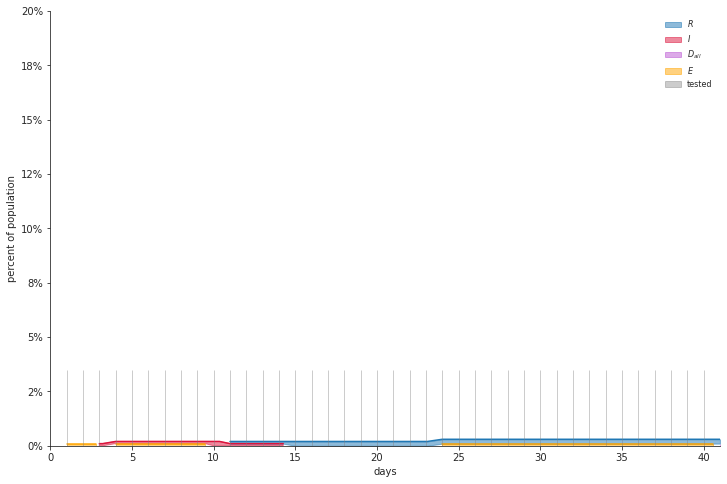

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/10000 type 14/1


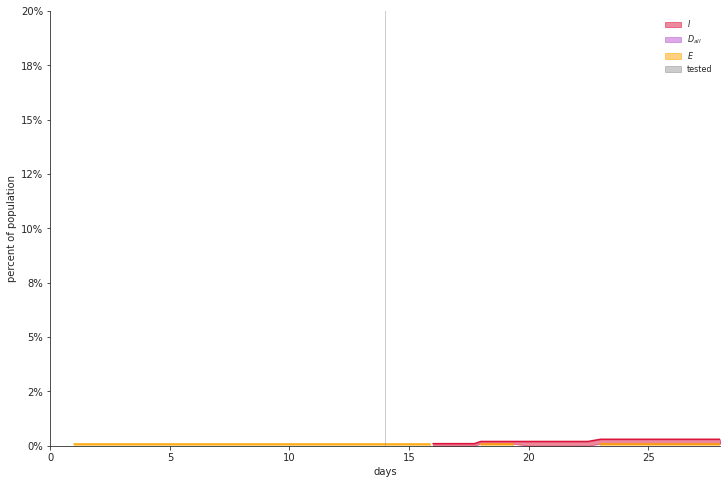

<Figure size 432x288 with 0 Axes>

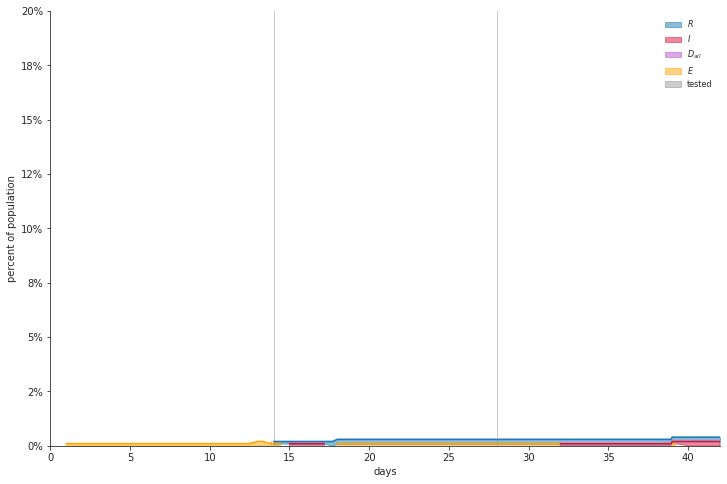

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/10000 type 14/2


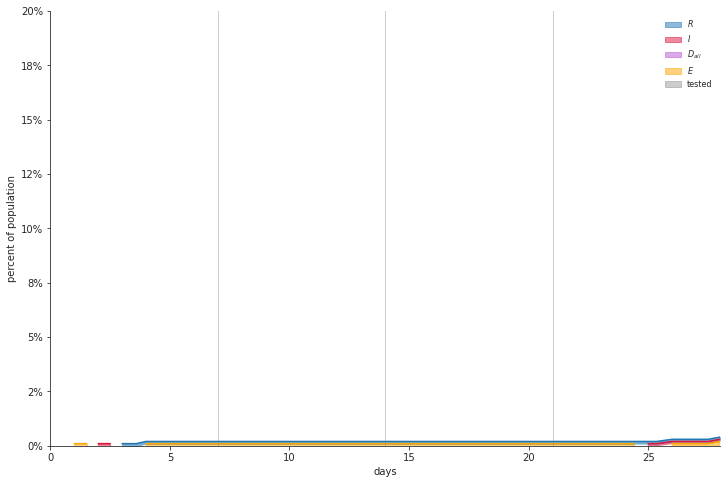

<Figure size 432x288 with 0 Axes>

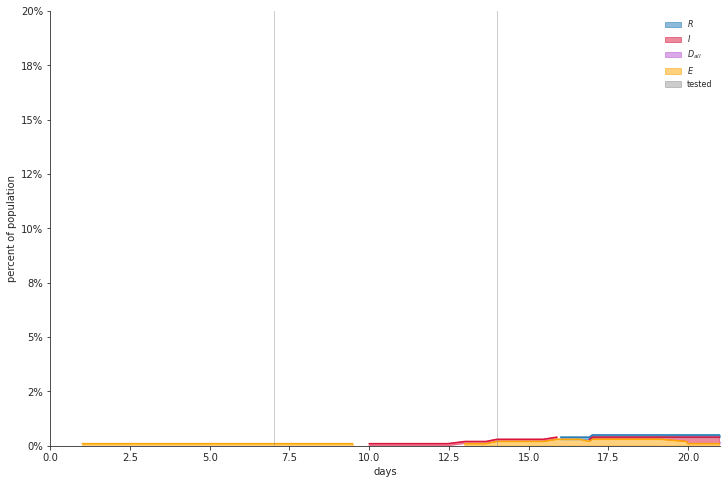

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/10000 type 14/3


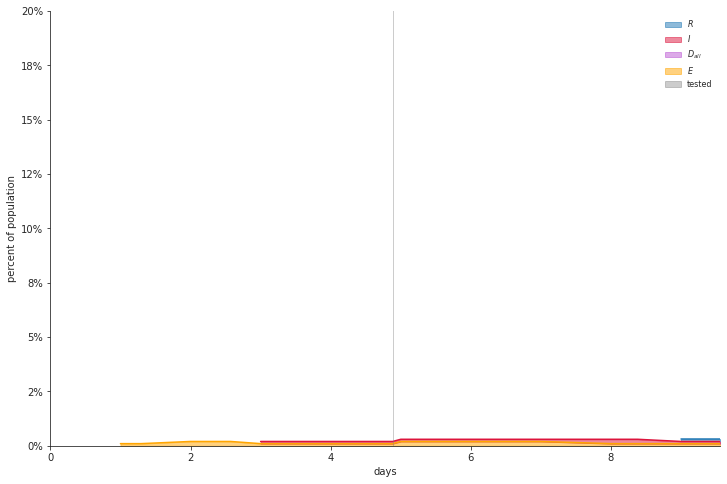

<Figure size 432x288 with 0 Axes>

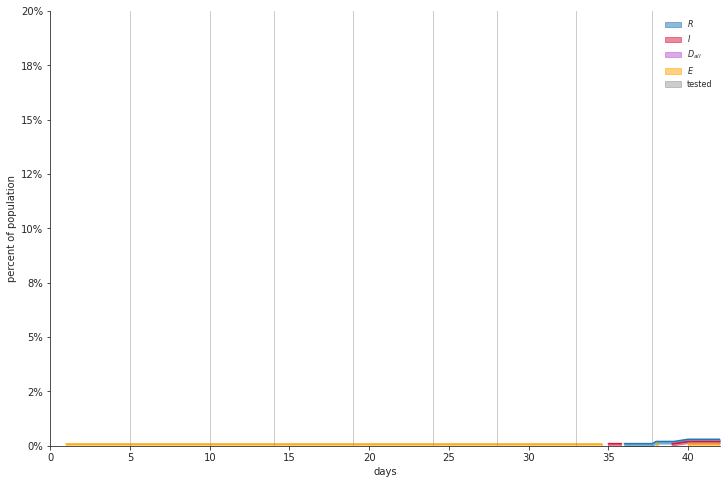

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/10000 type 14/14


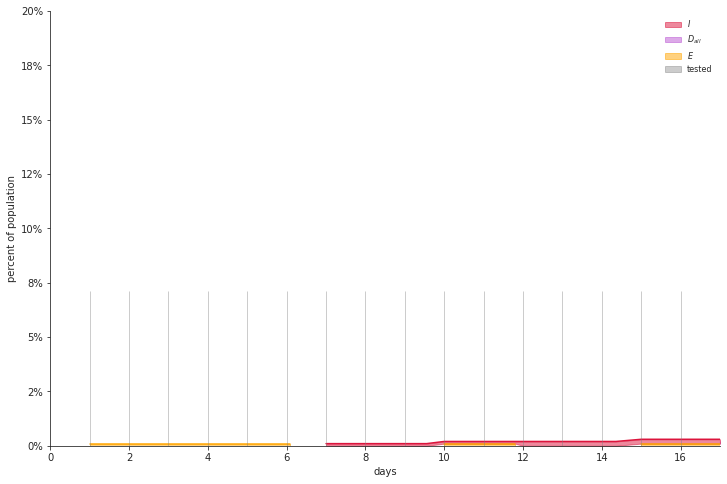

<Figure size 432x288 with 0 Axes>

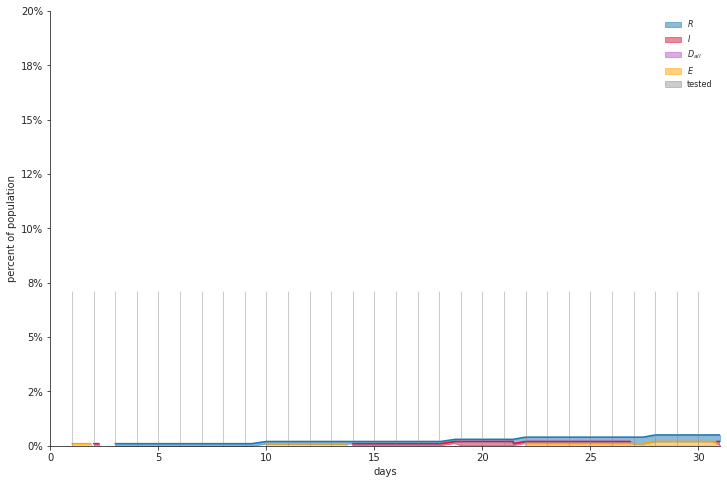

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/10000 type No testing (56 days)


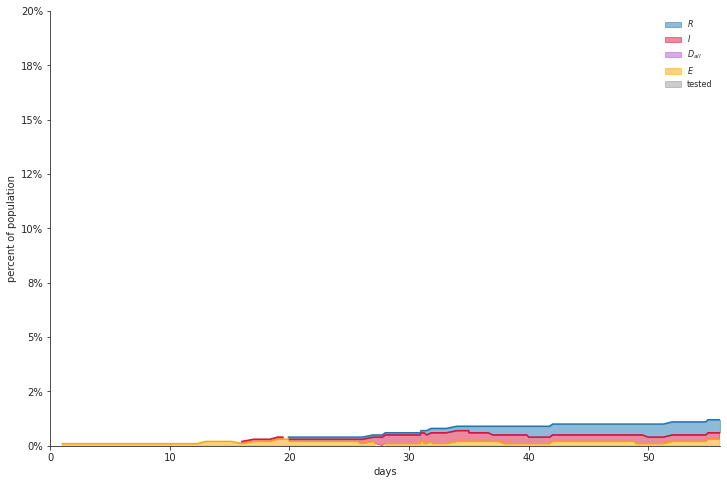

<Figure size 432x288 with 0 Axes>

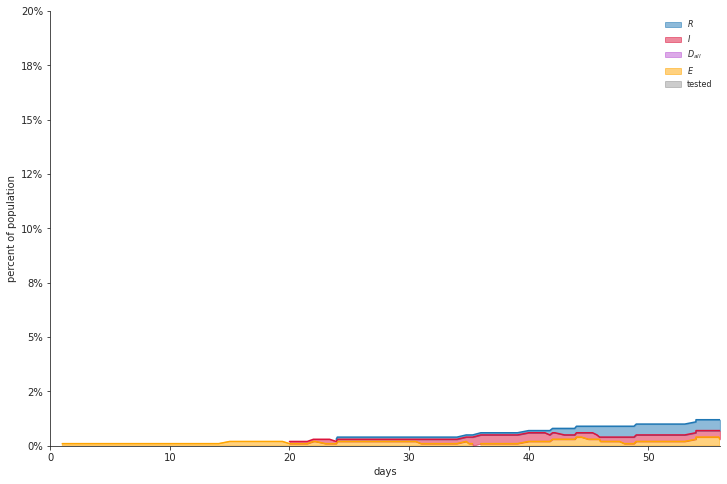

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/10000 type No testing (108 days)


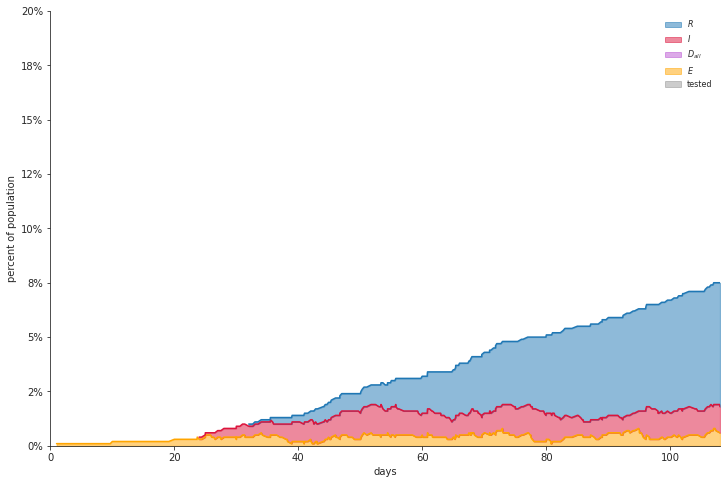

<Figure size 432x288 with 0 Axes>

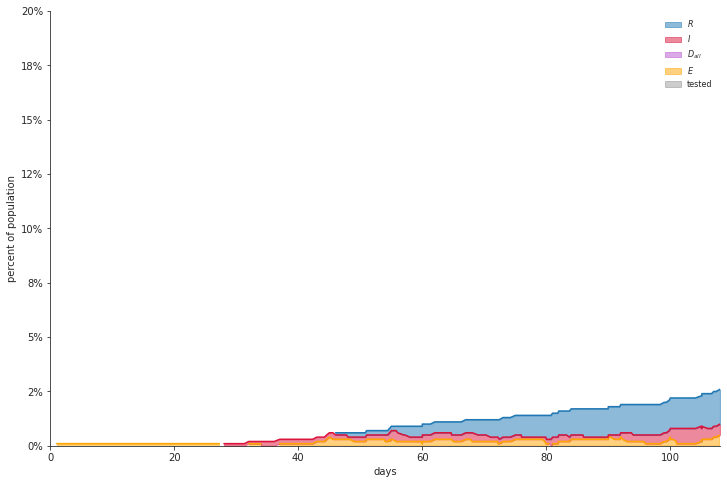

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/10000 type Business closed (56 days)


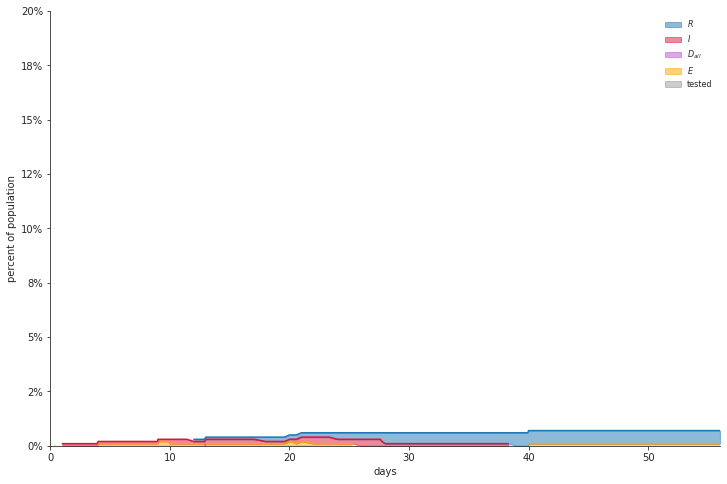

<Figure size 432x288 with 0 Axes>

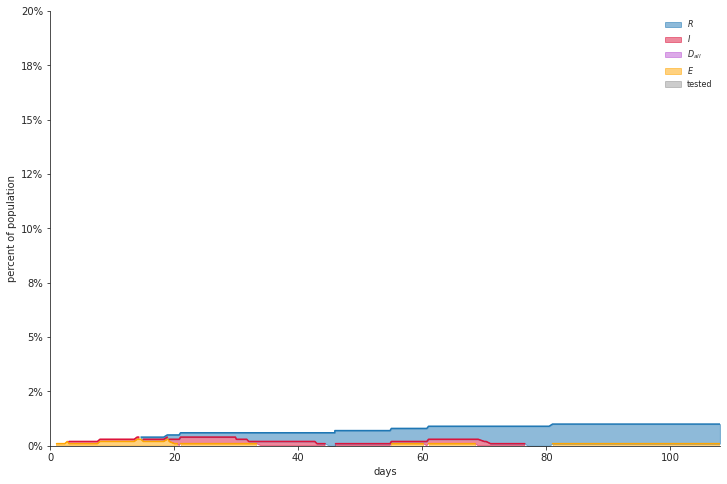

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/20000 type 28/1


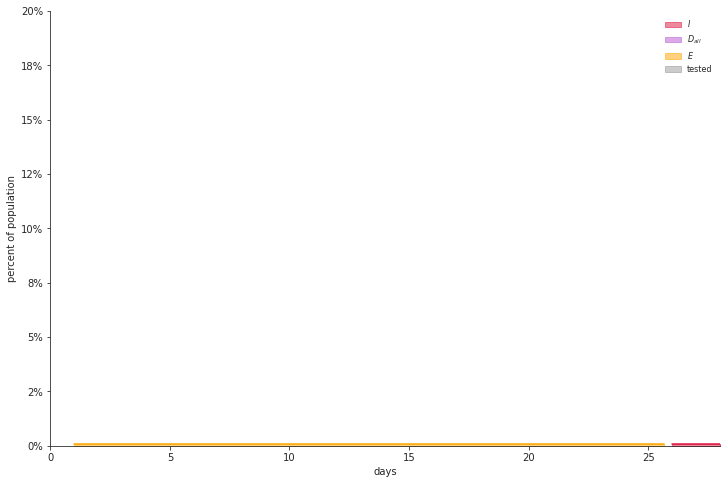

<Figure size 432x288 with 0 Axes>

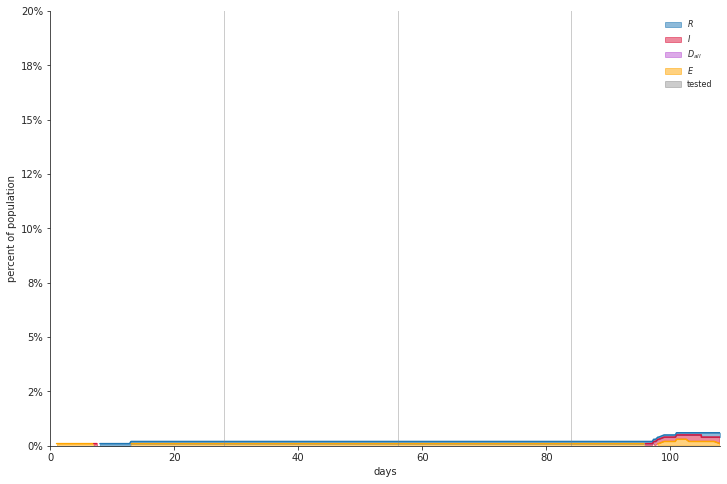

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/20000 type 28/2


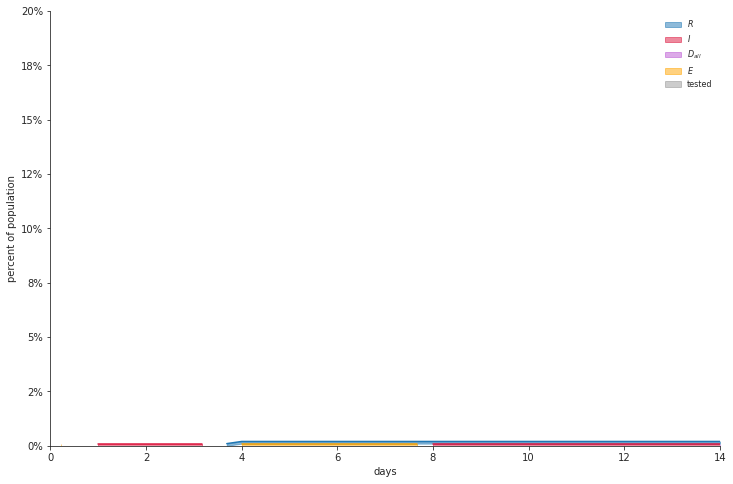

<Figure size 432x288 with 0 Axes>

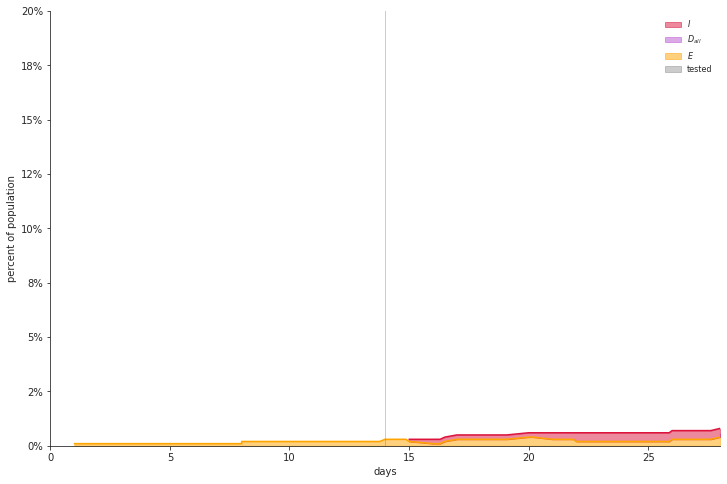

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/20000 type 28/3


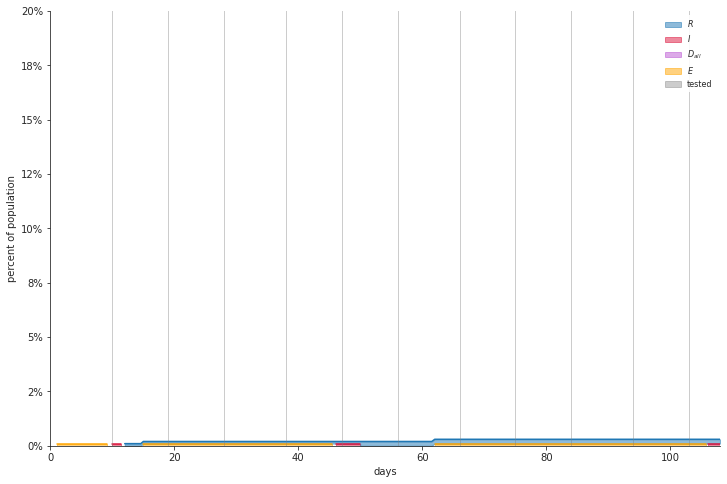

<Figure size 432x288 with 0 Axes>

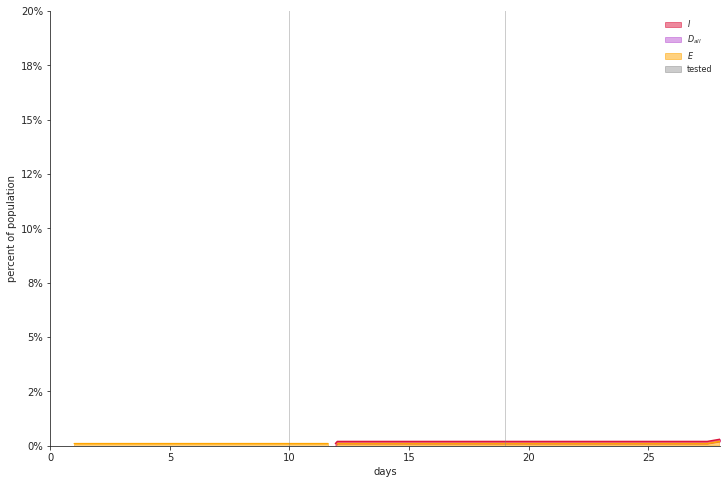

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/20000 type 28/28


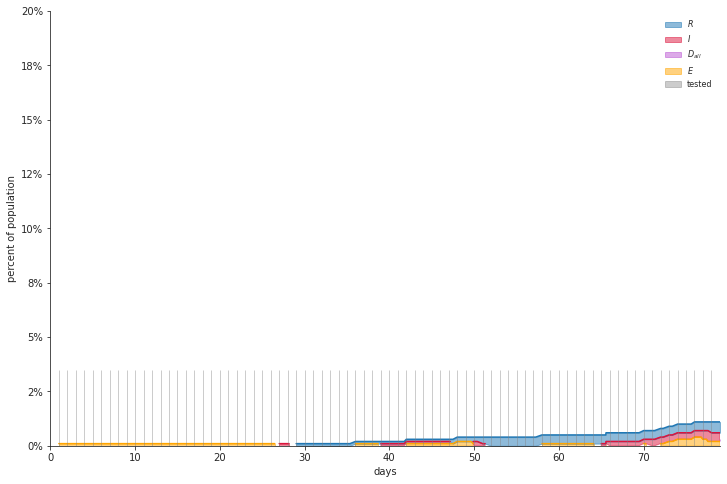

<Figure size 432x288 with 0 Axes>

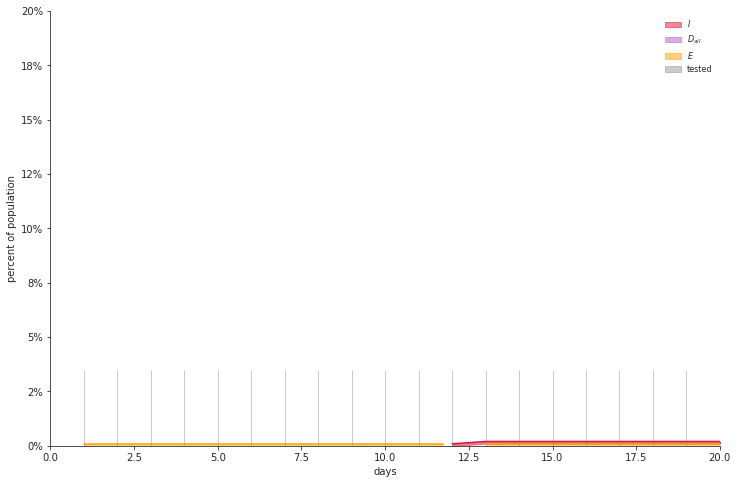

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/20000 type 14/1


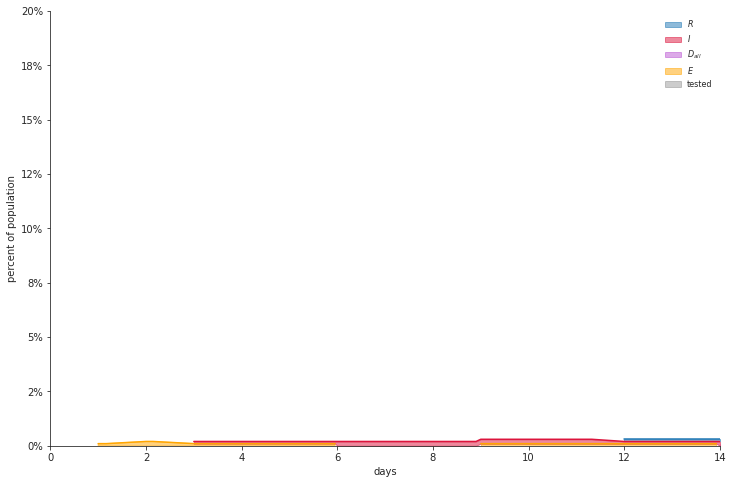

<Figure size 432x288 with 0 Axes>

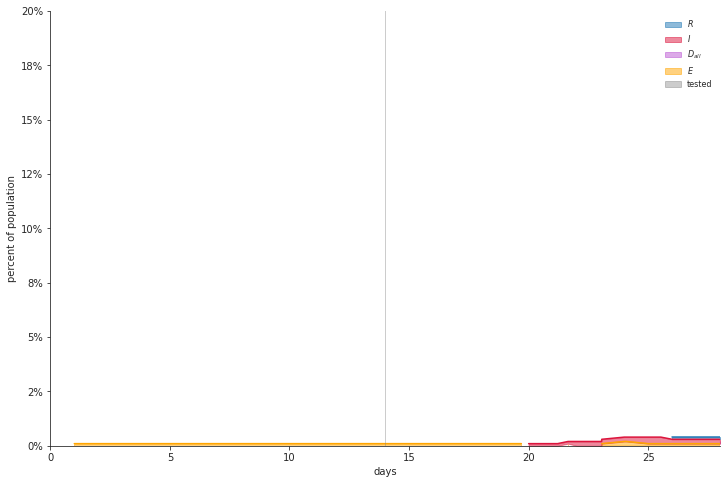

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/20000 type 14/2


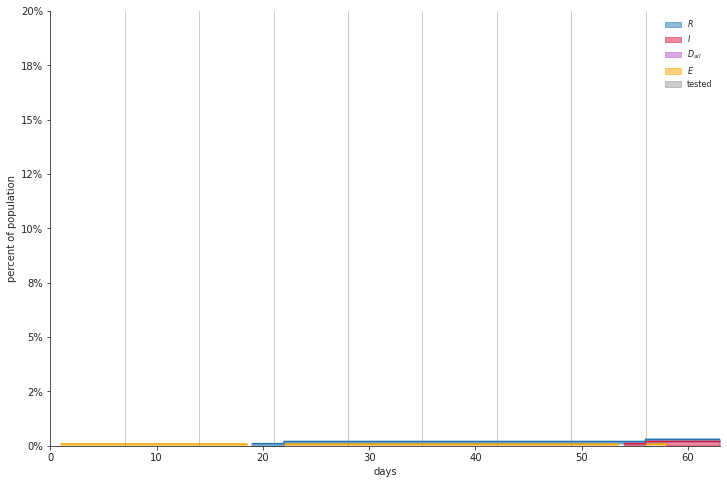

<Figure size 432x288 with 0 Axes>

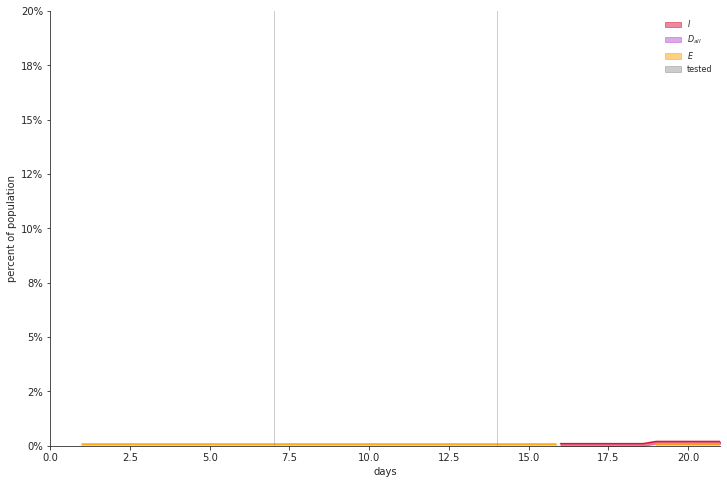

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/20000 type 14/3


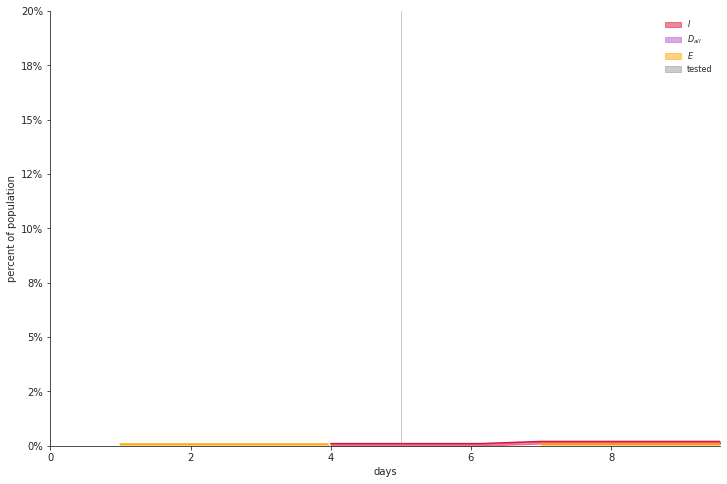

<Figure size 432x288 with 0 Axes>

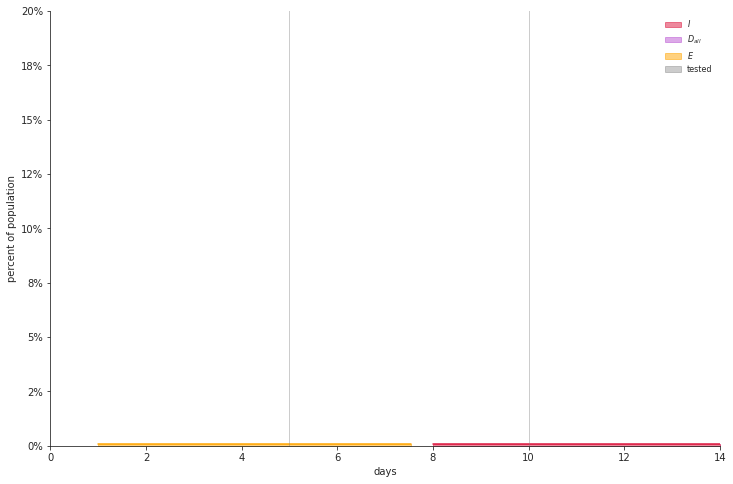

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/20000 type 14/14


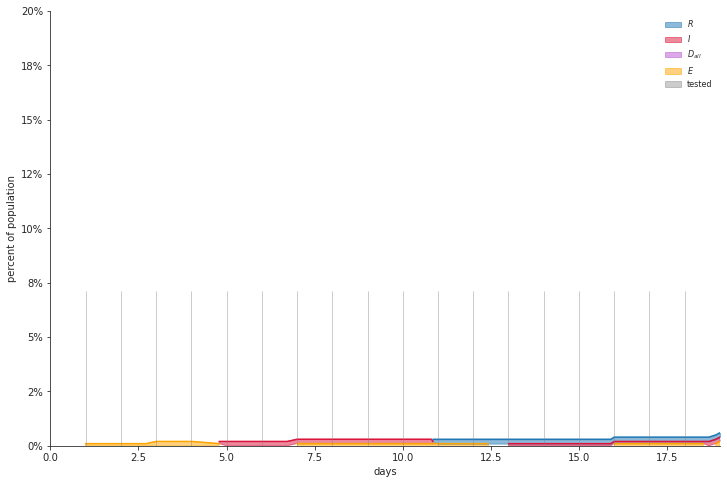

<Figure size 432x288 with 0 Axes>

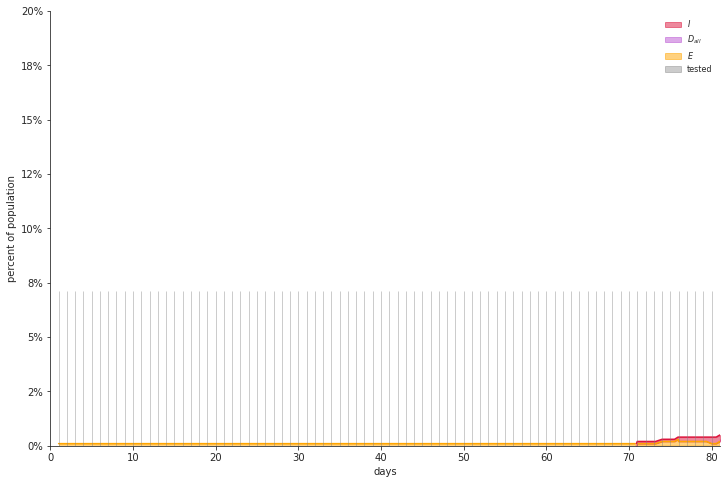

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/20000 type No testing (56 days)


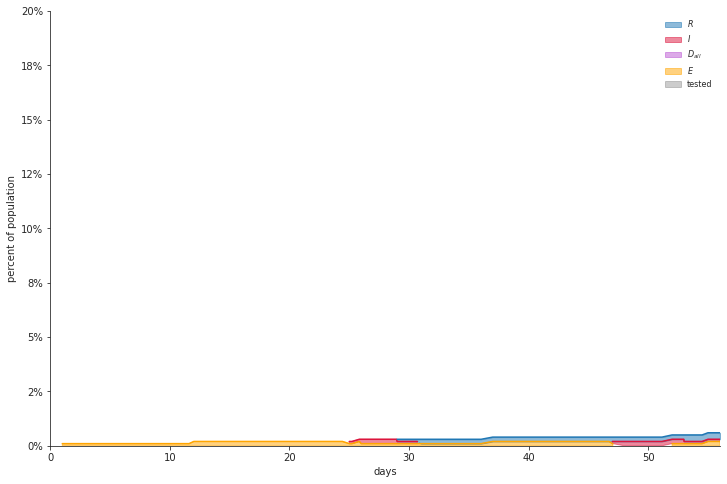

<Figure size 432x288 with 0 Axes>

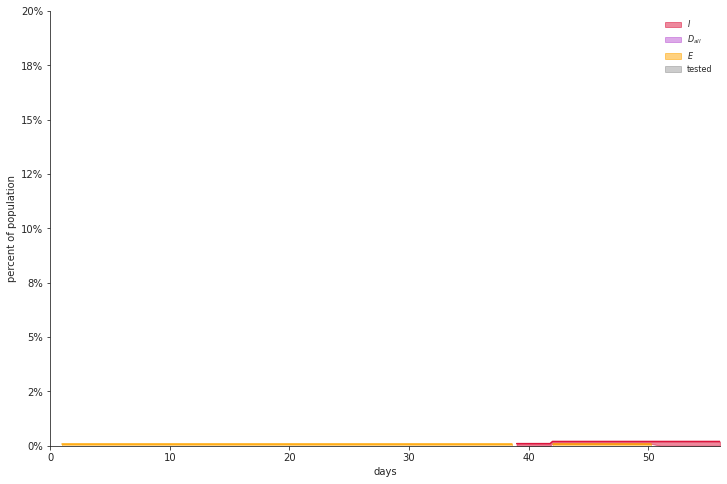

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/20000 type No testing (108 days)


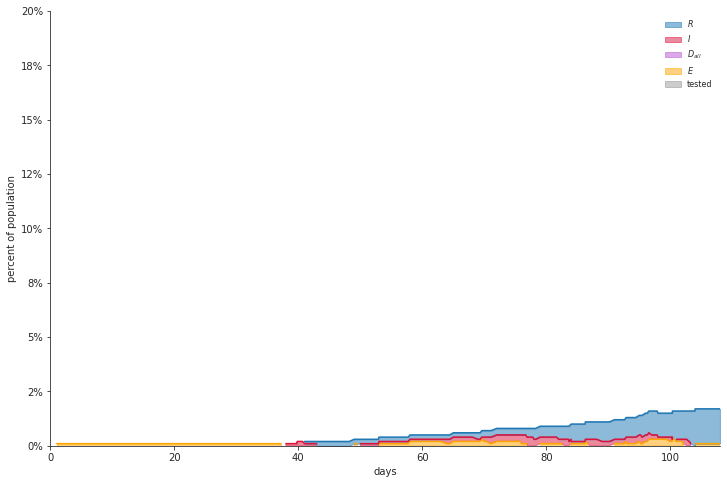

<Figure size 432x288 with 0 Axes>

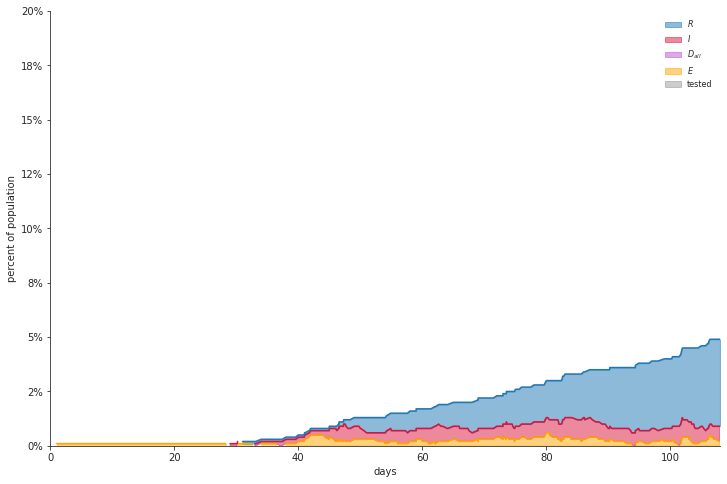

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=1/20000 type Business closed (56 days)


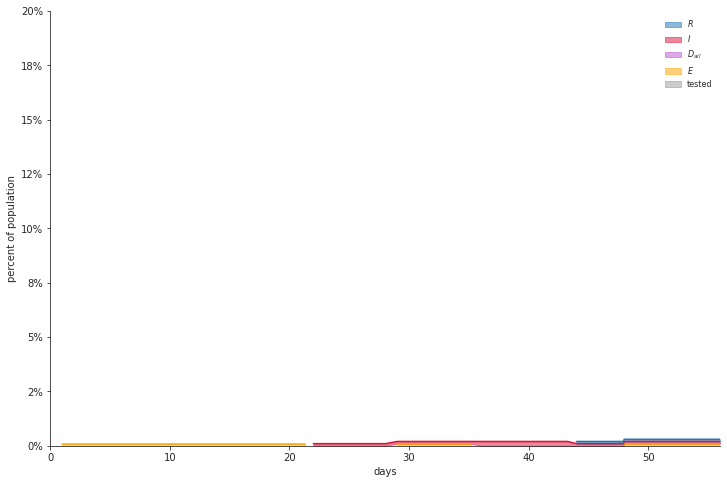

<Figure size 432x288 with 0 Axes>

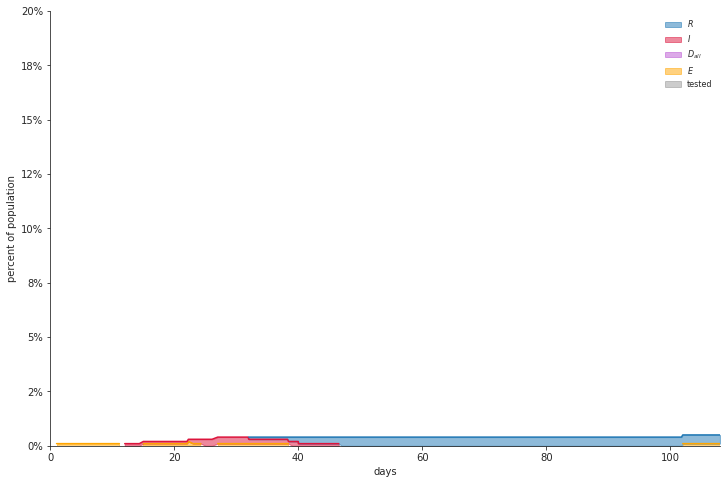

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=0 (random start 0-28.0) type 28/1


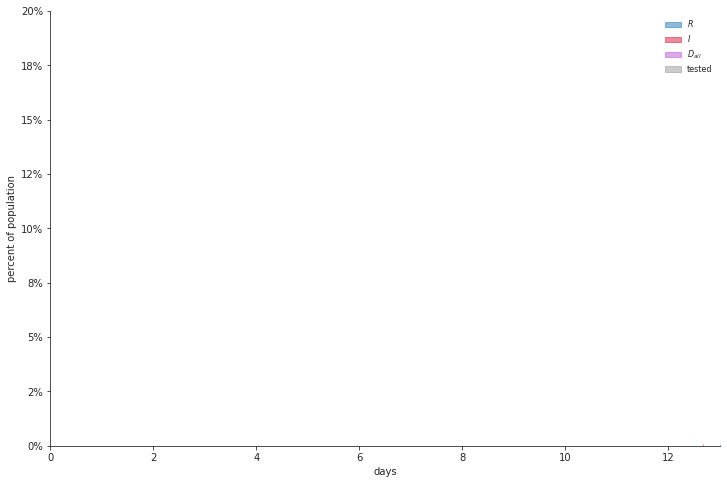

<Figure size 432x288 with 0 Axes>

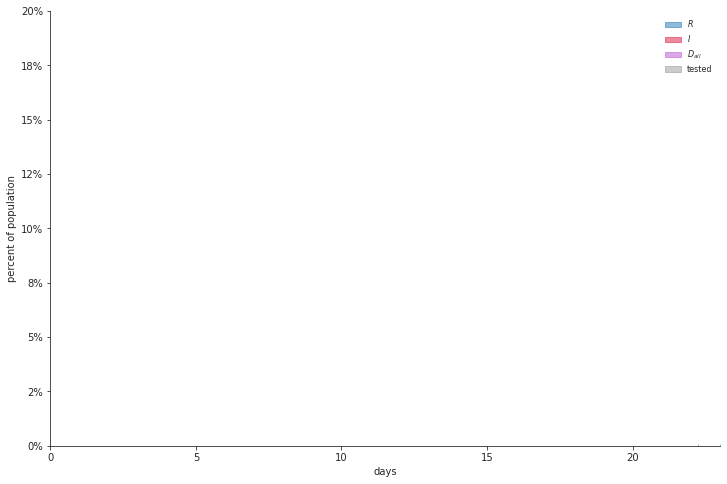

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=0 (random start 0-28.0) type 28/2


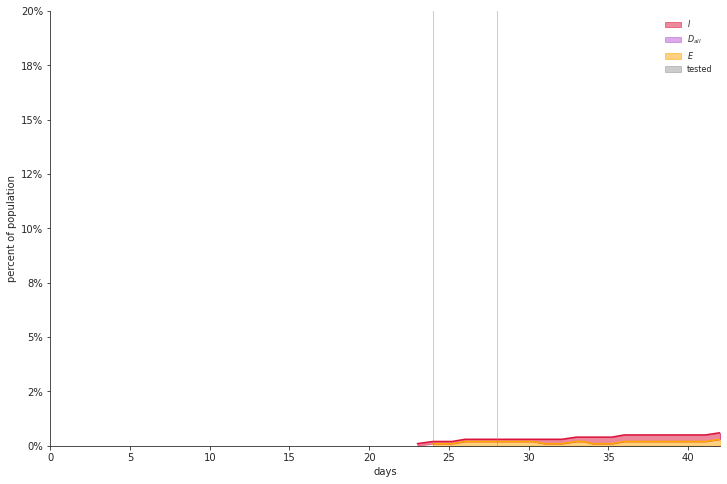

<Figure size 432x288 with 0 Axes>

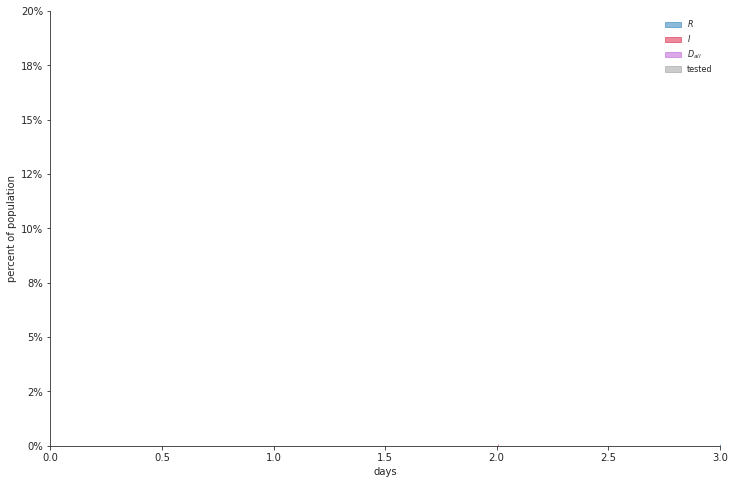

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=0 (random start 0-28.0) type 28/3


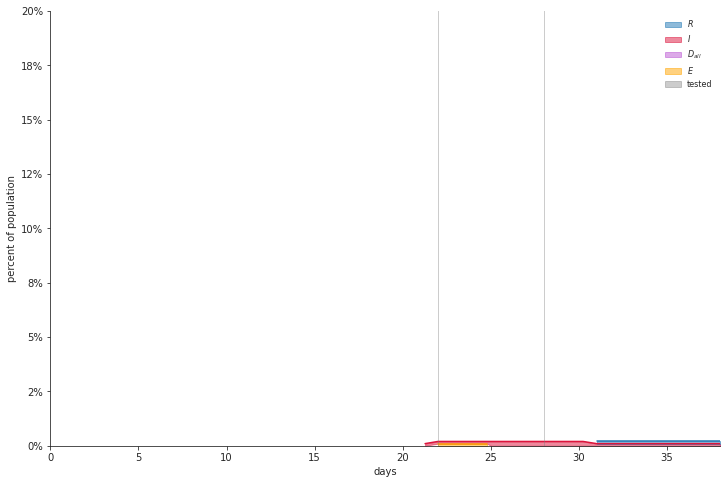

<Figure size 432x288 with 0 Axes>

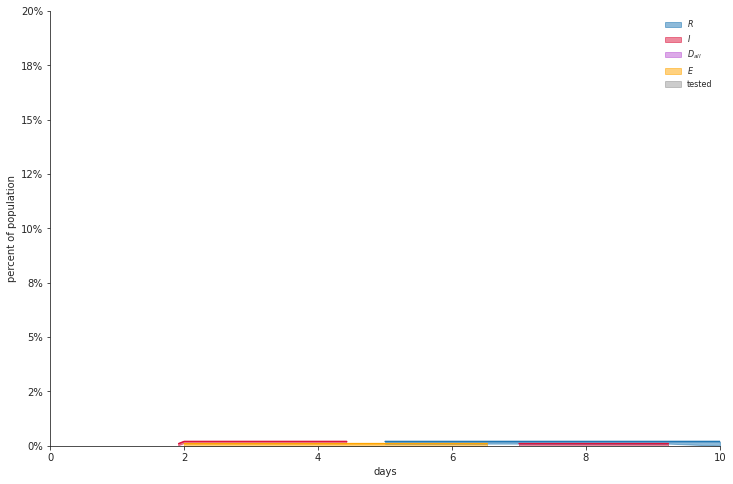

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=0 (random start 0-28.0) type 28/28


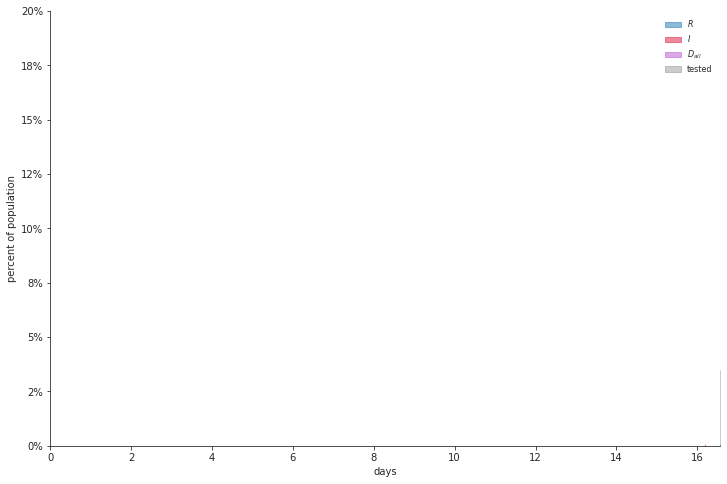

<Figure size 432x288 with 0 Axes>

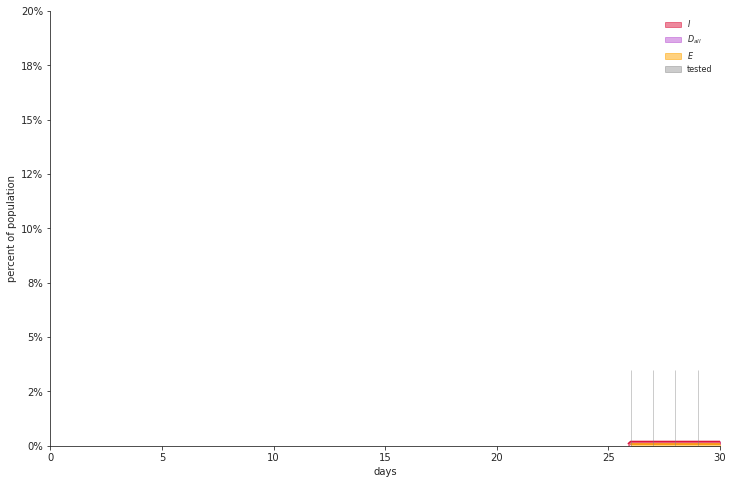

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=0 (random start 0-28.0) type 14/1


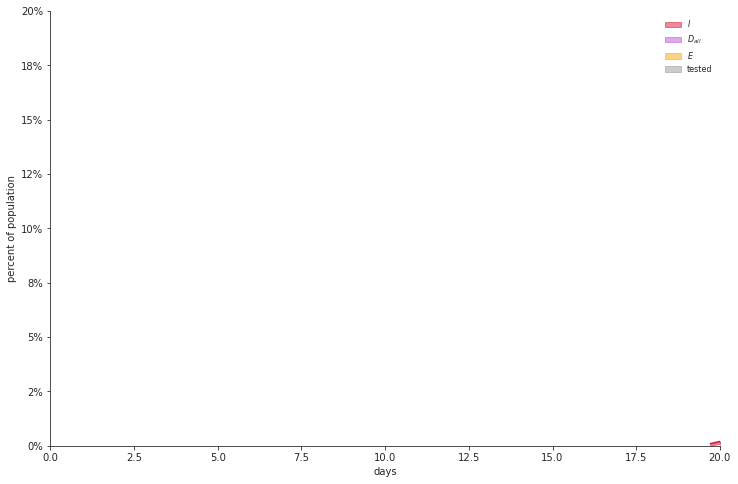

<Figure size 432x288 with 0 Axes>

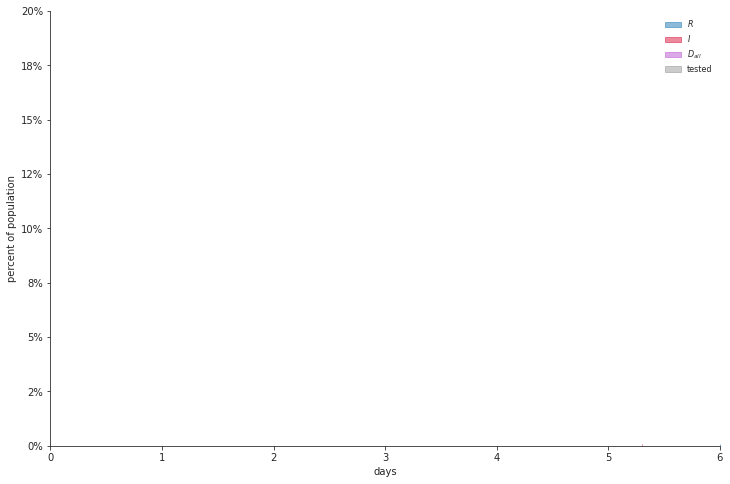

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=0 (random start 0-28.0) type 14/2


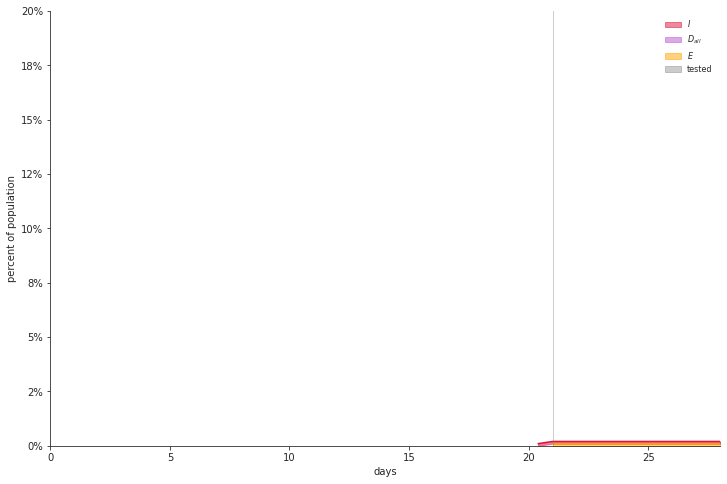

<Figure size 432x288 with 0 Axes>

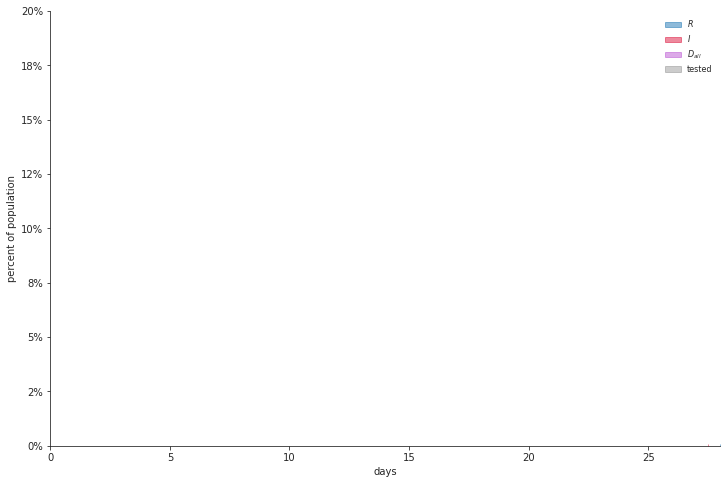

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=0 (random start 0-28.0) type 14/3


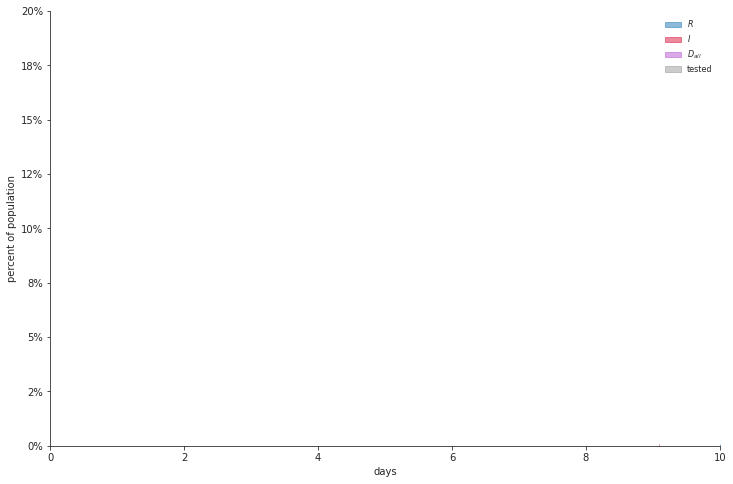

<Figure size 432x288 with 0 Axes>

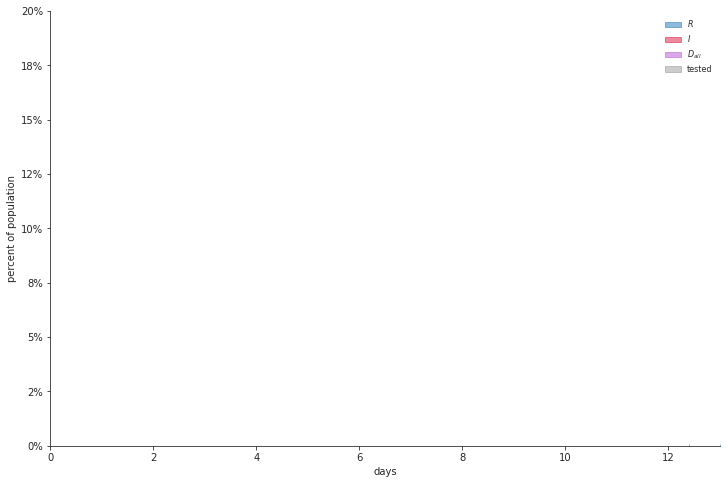

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=0 (random start 0-28.0) type 14/14


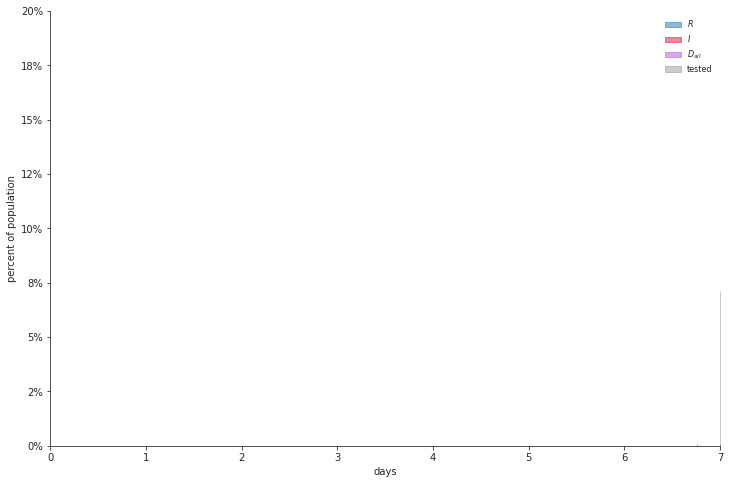

<Figure size 432x288 with 0 Axes>

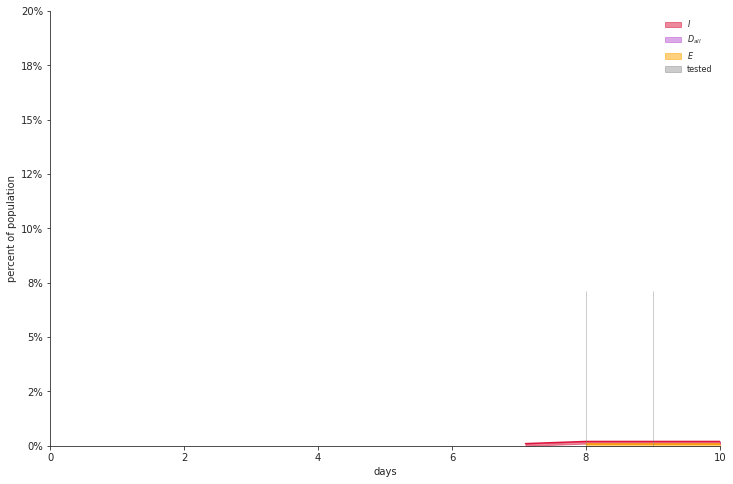

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=0 (random start 0-28.0) type No testing (56 days)


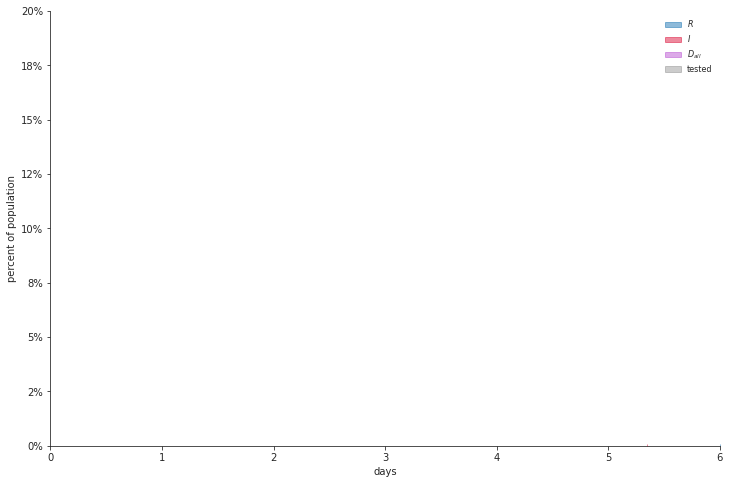

<Figure size 432x288 with 0 Axes>

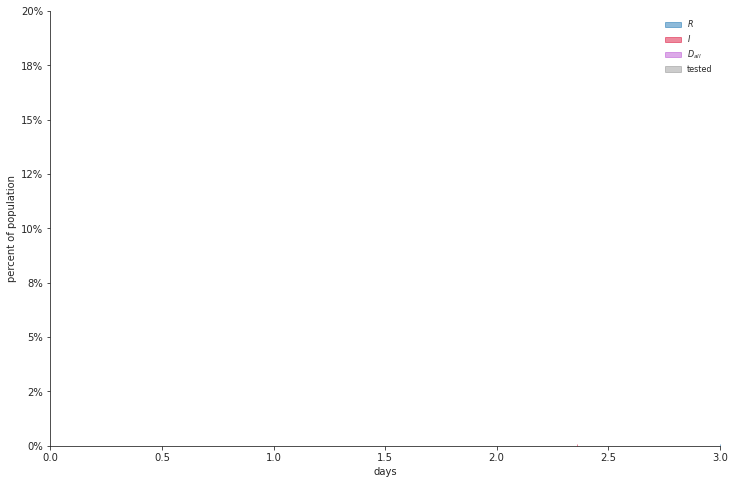

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=0 (random start 0-28.0) type No testing (108 days)


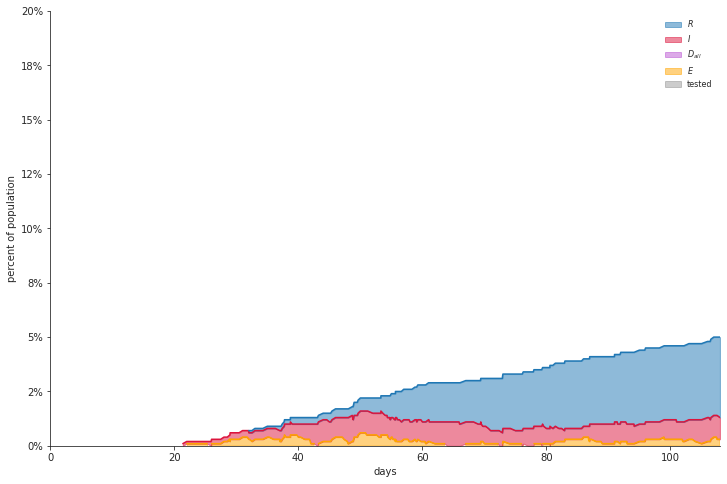

<Figure size 432x288 with 0 Axes>

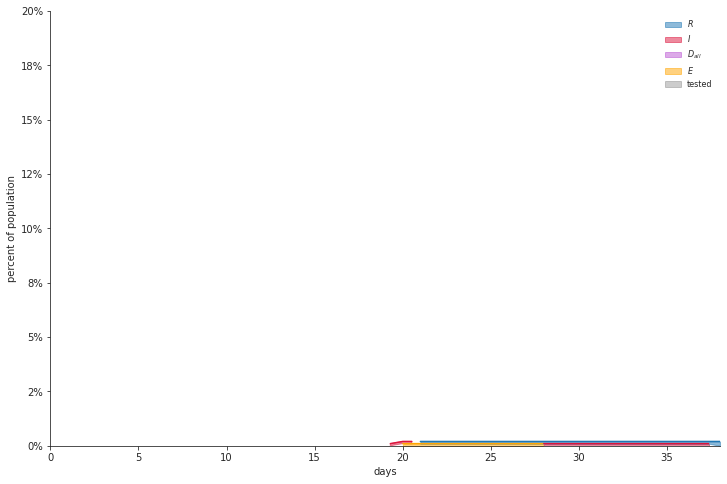

<Figure size 432x288 with 0 Axes>

Plotting two figures for variant beta=0.1,pextern=0 (random start 0-28.0) type Business closed (56 days)


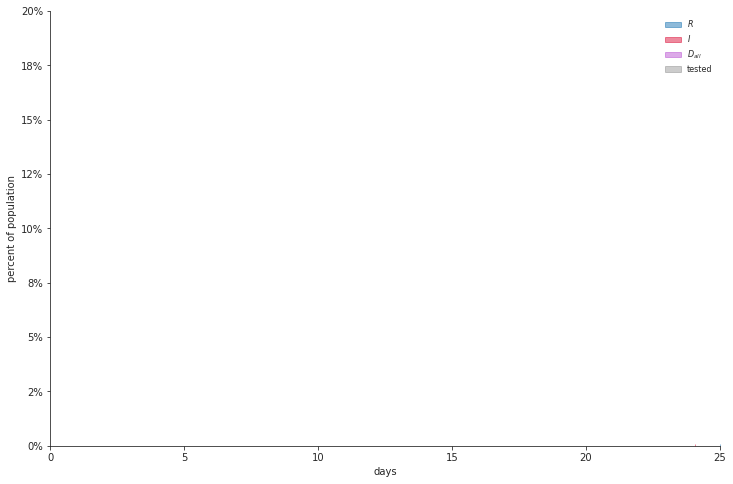

<Figure size 432x288 with 0 Axes>

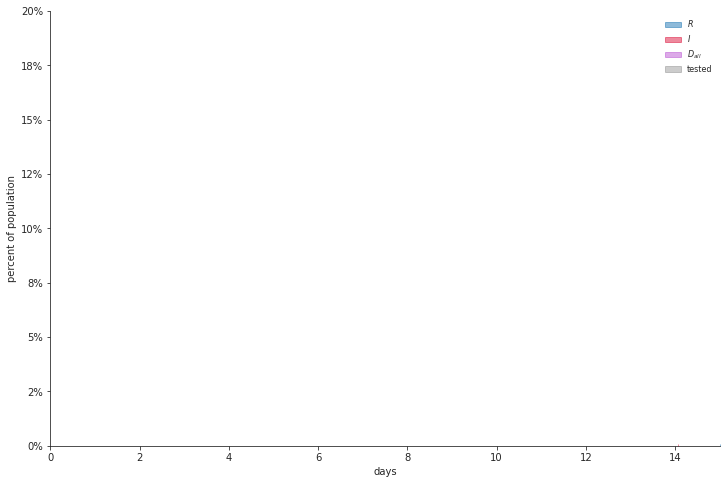

<Figure size 432x288 with 0 Axes>

In [43]:

types = data.type.unique()
for v in variants:
    for t in types:
        d = data[(data["variant"]==v) & (data["type"]==t) & data["model"]]
        print(f"Plotting two figures for variant {v} type {t}")
        d.iloc[0,:]["model"].figure_infections(plot_R="stacked",ylim = 0.2)
        t = d.iloc[0,:]["type"]
        filename = f"{datadir}/time_figure_{t.replace(' ','_').replace('/','-')}_{v.replace(' ','_').replace('/','-')}_1.png"
        fig = plt.gcf()
        fig.suptitle(v+" "+t)
        fig.savefig(filename)
        plt.show()
        d.iloc[1,:]["model"].figure_infections(plot_R="stacked",ylim = 0.2)
        t = d.iloc[1,:]["type"]
        filename = f"{datadir}/time_figure_{t.replace(' ','_').replace('/','-')}_{v.replace(' ','_').replace('/','-')}_2.png"
        fig = plt.gcf()
        fig.suptitle(v+" "+t)
        fig.savefig(filename)

        plt.show()